# Optimize sampling algorithm settings
This notebooks shares tests of differernt sampling algorithm settings

### Download training spectra

In [3]:
import requests
import os
from tqdm import tqdm

def download_file(link, file_name):
    response = requests.get(link, stream=True)
    if os.path.exists(file_name):
        print(f"The file {file_name} already exists, the file won't be downloaded")
        return
    total_size = int(response.headers.get('content-length', 0))
    
    with open(file_name, "wb") as f, tqdm(desc="Downloading file", total=total_size, unit='B', unit_scale=True, unit_divisor=1024,) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))  # Update progress bar by the chunk size
    
neg_train_spectra_file_name = "neg_training_spectra.mgf"
pos_train_spectra_file_name = "pos_training_spectra.mgf"

download_file("https://zenodo.org/records/13934470/files/negative_training_spectra.mgf?download=1", neg_train_spectra_file_name)
download_file("https://zenodo.org/records/13934470/files/positive_training_spectra.mgf?download=1", pos_train_spectra_file_name)




The file neg_training_spectra.mgf already exists, the file won't be downloaded
The file pos_training_spectra.mgf already exists, the file won't be downloaded


# Load in spectra

In [1]:
from matchms.importing import load_from_mgf

In [4]:
from tqdm import tqdm
negative_spectra = list(tqdm(load_from_mgf(neg_train_spectra_file_name)))

130901it [01:09, 1882.42it/s]


In [5]:
positive_spectra = list(tqdm(load_from_mgf(pos_train_spectra_file_name)))

469257it [03:49, 2046.65it/s]


### Load sampling algorithm
Below we load the sampling algorithm this is normally run combined in select_compound_pairs_wrapper(). Here we have split the function in two, since the get_scores_matrixes stays constant and takes the longest compute time.This makes experimenting faster.

In [26]:
from ms2deepscore.train_new_model.inchikey_pair_selection import *
from ms2deepscore.train_new_model.data_generators import InchikeyPairGenerator
from matplotlib import pyplot as plt

def get_scores_matrixes(spectra, settings):
    if settings.random_seed is not None:
        np.random.seed(settings.random_seed)
    print("start calculating fingerprints")
    fingerprints, inchikeys14_unique = compute_fingerprints_for_training(spectra, settings.fingerprint_type,
                                                                         settings.fingerprint_nbits)
    
    print("calculating tanimoto scores")
    available_pairs_per_bin_matrix, available_scores_per_bin_matrix = compute_jaccard_similarity_per_bin(
        fingerprints,
        settings.max_pairs_per_bin,
        settings.same_prob_bins,
        settings.include_diagonal)
    return available_pairs_per_bin_matrix, available_scores_per_bin_matrix, inchikeys14_unique


def get_inchikey_pairs(available_pairs_per_bin_matrix, available_scores_per_bin_matrix, inchikeys14_unique, settings):    
    print("doing balanced selection")
    pair_frequency_matrixes = balanced_selection_of_pairs_per_bin(
        available_pairs_per_bin_matrix, settings)
    
    print("converting to a pairs list")
    selected_pairs_per_bin = convert_to_selected_pairs_list(
        pair_frequency_matrixes, available_pairs_per_bin_matrix,
        available_scores_per_bin_matrix, inchikeys14_unique)
    
    selected_compound_pairs_training = [pair for pairs in selected_pairs_per_bin for pair in pairs]
    
    return InchikeyPairGenerator(selected_compound_pairs_training)

### Precalculating scores matrixes
Normally this is all handled in the select_compound_pairs_wrapper. However, since we want to run many slighltly different settings, we run the score matrix calculations once and reuse. 

In [7]:
from ms2deepscore.SettingsMS2Deepscore import SettingsMS2Deepscore
import numpy as np
settings = SettingsMS2Deepscore(max_pairs_per_bin=100, 
                                same_prob_bins=np.array([(0.9, 1.0), (0.8, 0.9), (0.7, 0.8), (0.6, 0.7), (0.5, 0.6),
                                        (0.4, 0.5), (0.3, 0.4), (0.2, 0.3), (0.1, 0.2), (-0.01, 0.1), ]), 
                                include_diagonal=True, random_seed=42, fingerprint_nbits=4096)
available_pairs_per_bin_matrix, available_scores_per_bin_matrix, unique_inchikey_list = get_scores_matrixes(negative_spectra + positive_spectra, settings)

start calculating fingerprints
Selected 37623 spectra with unique inchikeys for calculating tanimoto scores (out of 600158 spectra)


[10:48:03] Explicit valence for atom # 50 Na, 2, is greater than permitted
[10:48:03] Explicit valence for atom # 50 Na, 2, is greater than permitted
[10:48:03] ERROR: Explicit valence for atom # 50 Na, 2, is greater than permitted

[10:48:17] Explicit valence for atom # 9 Na, 2, is greater than permitted
[10:48:17] Explicit valence for atom # 44 Na, 2, is greater than permitted
[10:48:17] ERROR: Explicit valence for atom # 44 Na, 2, is greater than permitted

[10:48:43] Explicit valence for atom # 35 Na, 2, is greater than permitted
[10:48:43] Explicit valence for atom # 56 Na, 2, is greater than permitted
[10:48:43] ERROR: Explicit valence for atom # 56 Na, 2, is greater than permitted

[10:49:05] Explicit valence for atom # 29 Na, 2, is greater than permitted
[10:49:05] Explicit valence for atom # 50 Na, 2, is greater than permitted
[10:49:05] ERROR: Explicit valence for atom # 50 Na, 2, is greater than permitted

[10:49:06] Explicit valence for atom # 53 Na, 2, is greater than perm

Successfully generated fingerprints for 37617 of 37623 spectra
calculating tanimoto scores


In [8]:
scores_matrix_standard_order = (available_pairs_per_bin_matrix, available_scores_per_bin_matrix, unique_inchikey_list)

# No balanced inchikey pair selection
To show the need for balanced inchikey selection we show what happens if pairs are sampled equally over the bins. This results in very unequal sampling of inchikeys. Some are sampled 100 times more than others. 

In [24]:
import random
all_selected_indexes = []
random.seed(42)
for available_pairs_in_bin in available_pairs_per_bin_matrix:
    pairs = np.where(available_pairs_in_bin != -1)
    indexes_1 = pairs[0]
    indexes_2 = available_pairs_in_bin[available_pairs_in_bin != -1]

    # if we want to sample an average of 100 pairs per inchikey we have to sample this number of pairs per bin:
    nr_of_pairs_sampled = int(100/len(settings.same_prob_bins)*len(unique_inchikey_list)/2)
    shuffled_indexes = random.sample(range(len(indexes_1)), nr_of_pairs_sampled)
    
    all_selected_indexes.extend(indexes_1[shuffled_indexes])
    all_selected_indexes.extend(indexes_2[shuffled_indexes])

    


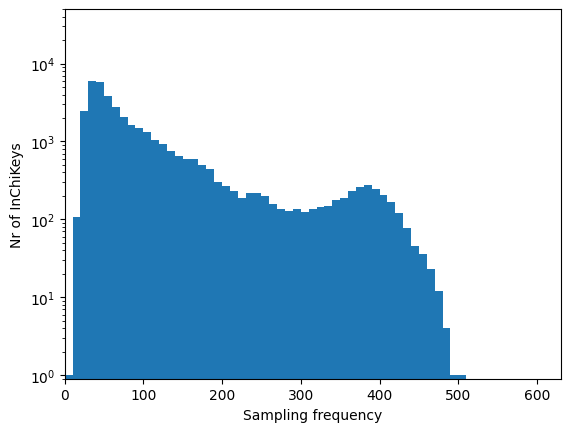

In [25]:
plt.hist(Counter(all_selected_indexes).values(), log=True, bins=range(0, 610, 10))
plt.xlim(left=0)
plt.ylim((0.9,50000))

plt.xlabel("Sampling frequency")
plt.ylabel("Nr of InChiKeys")
plt.savefig("sampling_algorithm_figures/SI2.1a.svg", bbox_inches="tight")
plt.show()

# Balanced inchikey selection
Below we do a balanced selection of inchikeys where we always sample the least sampled inchikey in each bin. And from the available inchikeys sample the least sampled inchikey. 

In [11]:
pair_generators_standard_order = {}

In [27]:
settings.average_inchikey_sampling_count = 100
settings.max_pair_resampling=1
settings.max_inchikey_sampling = 100000
# Store in a dictionary to ensure not overwriting in the notebook, when running different settings (makes it easy to format plots without the need to rerun)
pair_generators_standard_order[(settings.average_inchikey_sampling_count, 
                                      settings.max_pair_resampling, 
                                      settings.max_inchikey_sampling)] = get_inchikey_pairs(scores_matrix_standard_order[0], 
                                                                                            scores_matrix_standard_order[1], 
                                                                                            scores_matrix_standard_order[2], settings)

doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 31846.88it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.20it/s]


We plot some diagnostics plots, not all are relevant yet (or optimal), but it gives us the ability to in later optimization steps of the algorithms look back to see how certain aspects improved

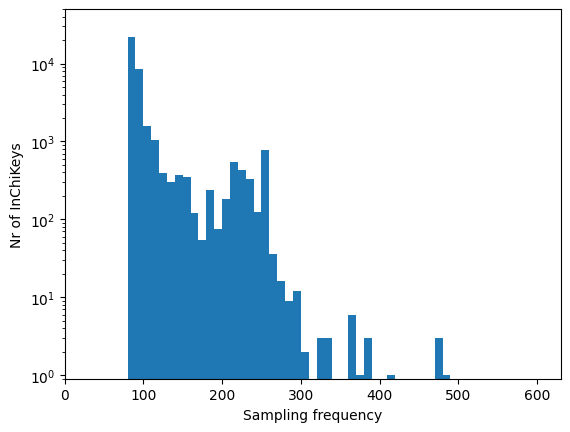

In [13]:
plt.hist(pair_generators_standard_order[(100, 1, 100000)].get_inchikey_counts().values(), log=True, bins=range(0, 610, 10))
plt.xlim(left=0)
plt.ylim((0.9,50000))

plt.xlabel("Sampling frequency")
plt.ylabel("Nr of InChiKeys")
plt.savefig("sampling_algorithm_figures/SI2.1b.svg", bbox_inches="tight")
plt.show()

In [14]:
settings.average_inchikey_sampling_count = 100
settings.max_pair_resampling=1
settings.max_inchikey_sampling = 250
# Store in a dictionary to ensure not overwriting in the notebook, when running different settings (makes it easy to format plots without the need to rerun)
pair_generators_standard_order[(settings.average_inchikey_sampling_count, 
                                      settings.max_pair_resampling, 
                                      settings.max_inchikey_sampling)] = get_inchikey_pairs(scores_matrix_standard_order[0], 
                                                                                            scores_matrix_standard_order[1], 
                                                                                            scores_matrix_standard_order[2], settings)

doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 32915.47it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.24it/s]


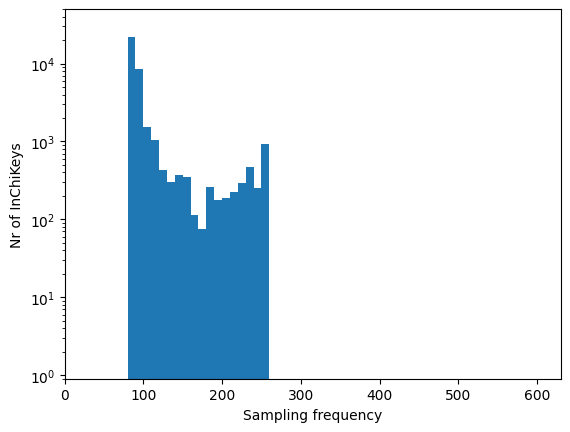

In [15]:
plt.hist(pair_generators_standard_order[(100, 1, 250)].get_inchikey_counts().values(), log=True, bins=range(0, 610, 10))
plt.xlim(left=0)
plt.ylim((0.9,50000))

plt.xlabel("Sampling frequency")
plt.ylabel("Nr of InChiKeys")
plt.show()

### Introduce a maximum inchikey frequency

In [16]:
settings.average_inchikey_sampling_count = 100
settings.max_pair_resampling=100000
settings.max_inchikey_sampling = 110
# Store in a dictionary to ensure not overwriting in the notebook, when running different settings (makes it easy to format plots without the need to rerun)
pair_generators_standard_order[(settings.average_inchikey_sampling_count, 
                                      settings.max_pair_resampling, 
                                      settings.max_inchikey_sampling)] =  get_inchikey_pairs(scores_matrix_standard_order[0], 
                                                                                            scores_matrix_standard_order[1], 
                                                                                            scores_matrix_standard_order[2], settings)

doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 33303.62it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.72it/s]


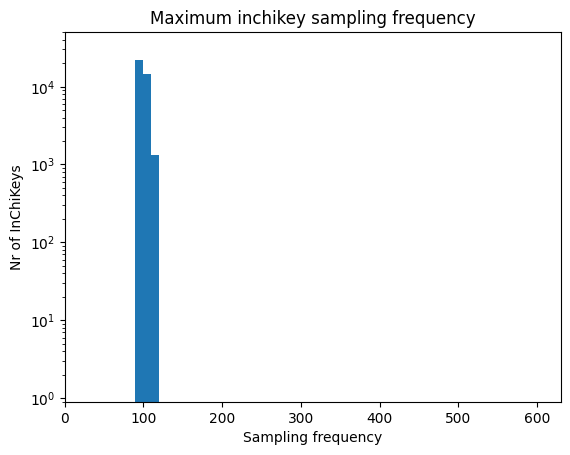

In [17]:
plt.hist(pair_generators_standard_order[(100, 100000, 110)].get_inchikey_counts().values(), log=True, bins=range(0, 610, 10))
plt.xlim(left=0)
plt.ylim((0.9,50000))

plt.title("Maximum inchikey sampling frequency")
plt.xlabel("Sampling frequency")
plt.ylabel("Nr of InChiKeys")
plt.savefig("sampling_algorithm_figures/SI2.1d.svg", bbox_inches="tight")
plt.show()

In [28]:
settings.average_inchikey_sampling_count = 100
settings.max_pair_resampling=100000
settings.max_inchikey_sampling = 100000
# Store in a dictionary to ensure not overwriting in the notebook, when running different settings (makes it easy to format plots without the need to rerun)
pair_generators_standard_order[(settings.average_inchikey_sampling_count, 
                                      settings.max_pair_resampling, 
                                      settings.max_inchikey_sampling)] = get_inchikey_pairs(scores_matrix_standard_order[0], 
                                                                                            scores_matrix_standard_order[1], 
                                                                                            scores_matrix_standard_order[2], settings)

doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 32083.21it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.67it/s]


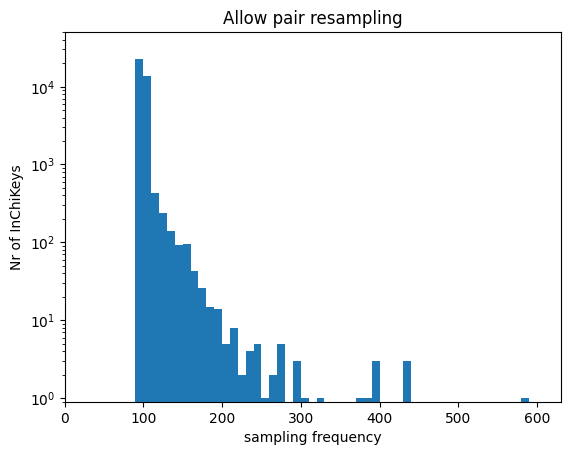

In [29]:
plt.hist(pair_generators_standard_order[(100, 100000, 100000)].get_inchikey_counts().values(), log=True, bins=range(0, 610, 10))
plt.xlim(left=0)
plt.ylim((0.9,50000))
plt.title("Allow pair resampling")
plt.xlabel("sampling frequency")
plt.ylabel("Nr of InChiKeys")
plt.savefig("sampling_algorithm_figures/SI2.1c.svg", bbox_inches="tight")
plt.show()

# function for diagnostic plots

In [30]:
def plot_diagnostic_plots(pair_generator, title):
    fig, axes = plt.subplots(3, 2, figsize=(10, 8))
    
    fig.suptitle(title)
    inchikey_frequencies = pair_generator.get_inchikey_counts().values()
    axes[0,0].hist(inchikey_frequencies, bins=range(min(inchikey_frequencies), max(inchikey_frequencies)))
    axes[0,0].set_xlabel("Sample frequency")
    axes[0,0].set_ylabel("Nr of inchikeys")
    
    # Plot average tanimoto score per inchikey 
    scores_per_inchikey = pair_generator.get_scores_per_inchikey().values()
    inchikey_average_sampling = [sum(scores)/len(scores) for scores in scores_per_inchikey]
    axes[0,1].hist(inchikey_average_sampling, bins=[i/100 for i in range(101)])
    axes[0,1].set_xlabel("Average tanimoto score per inchikey")
    axes[0,1].set_ylabel("Nr of inchikeys")
    axes[0,1].set_ylim((0,8000))

    # Plot highest oversampling
    max_count_per_bin = []
    most_sampled_bins = []
    for scores in scores_per_inchikey:
        counts, _ = np.histogram(scores, bins=[i/10 for i in range(11)])
        most_sampled_bins.append(np.argmax(counts))
        max_count_per_bin.append(max(counts)/len(scores))
        
    axes[1,0].hist(max_count_per_bin, bins=21)
    axes[1,0].set_xlabel("Fraction of pairs in a single bin")
    axes[1,0].set_ylabel("Nr of inchikey")

    axes[1,1].hist(most_sampled_bins, bins=range(11))
    axes[1,1].set_xlabel("Most sampled bin")
    axes[1,1].set_ylabel("Nr of inchikey")


    # Plot oversampling rate per pair
    oversampling_rates = Counter(pair_generator.selected_inchikey_pairs).values()
    axes[2,0].hist(oversampling_rates, bins = range(min(oversampling_rates), max(oversampling_rates)), log =True)
    axes[2,0].set_xlabel("Oversampling rate")
    axes[2,0].set_ylabel("Nr of pairs")

    # Plot total oversampling rate
    total_pairs = len(pair_generator.selected_inchikey_pairs)
    unique_pairs = len(set(pair_generator.selected_inchikey_pairs))
    axes[2,1].bar(["total pairs", "unique pairs"], [total_pairs, unique_pairs])
    axes[2,1].set_xlabel("Oversampling rate")
    axes[2,1].set_ylabel("Nr of pairs")
    plt.tight_layout()
    plt.show()

# Optimizing bin order
Above the bin order from high to low was used. However, this does not result in an optimal distribution of tanimoto scores per InChiKey.

### Determine number of InChiKeys without pairs per bin

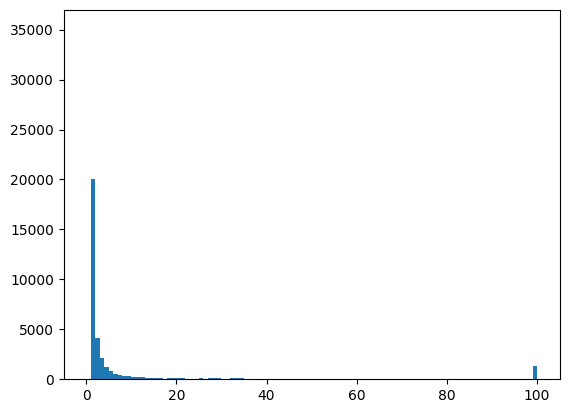

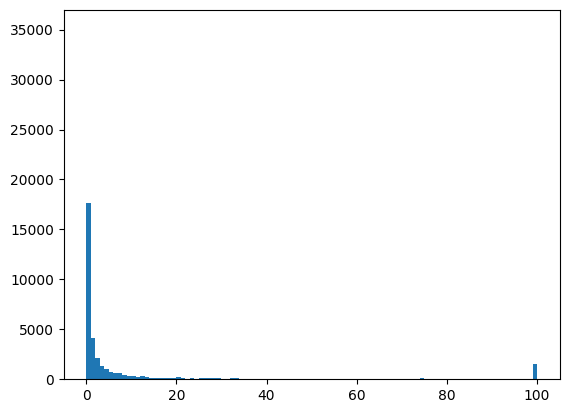

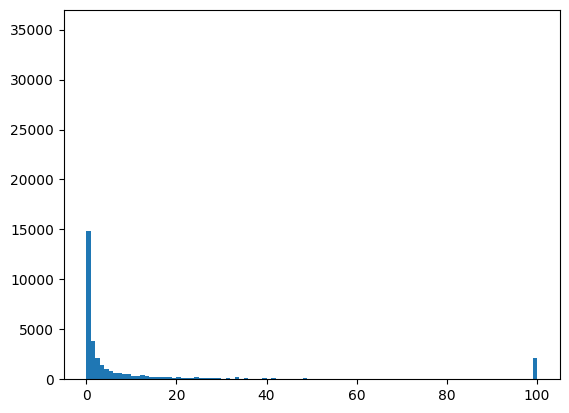

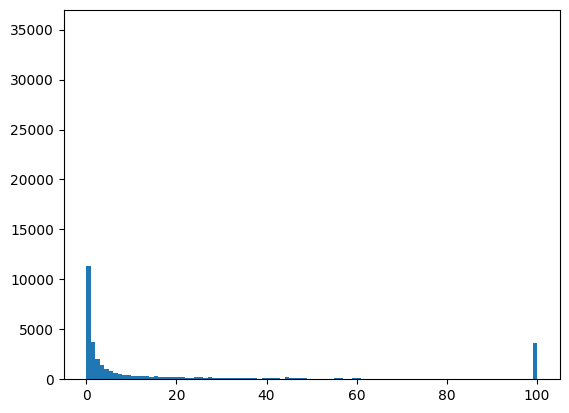

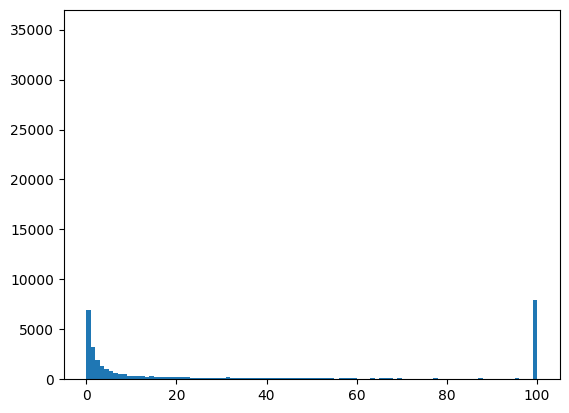

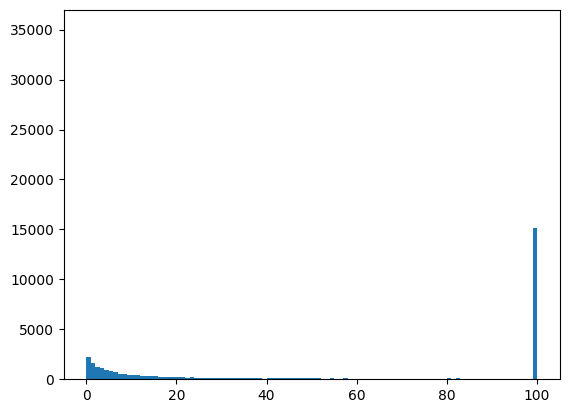

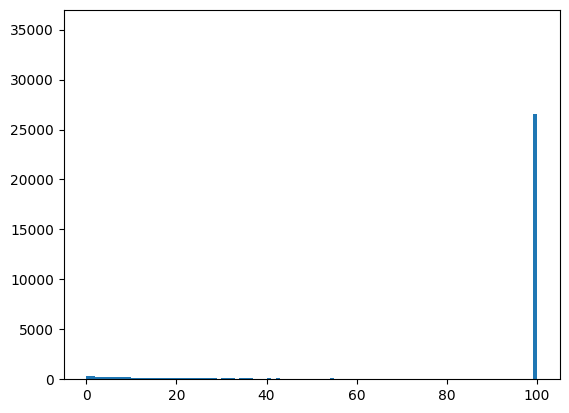

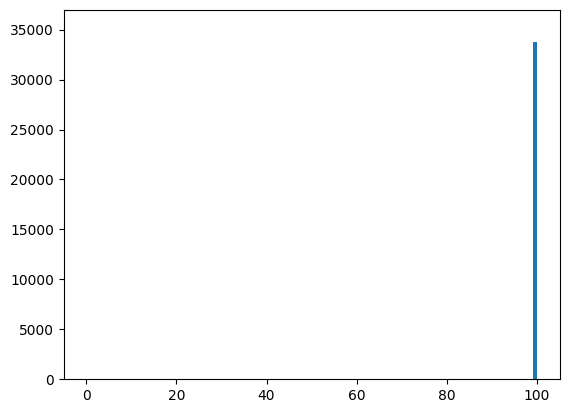

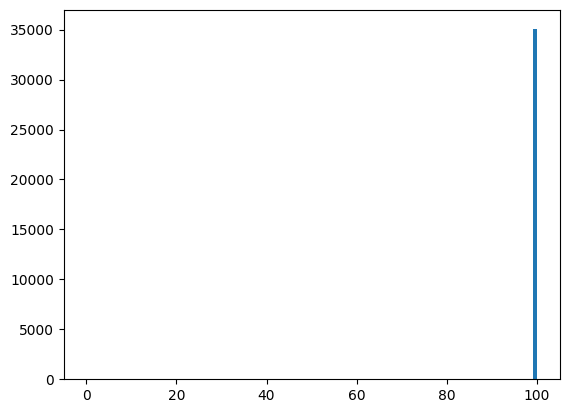

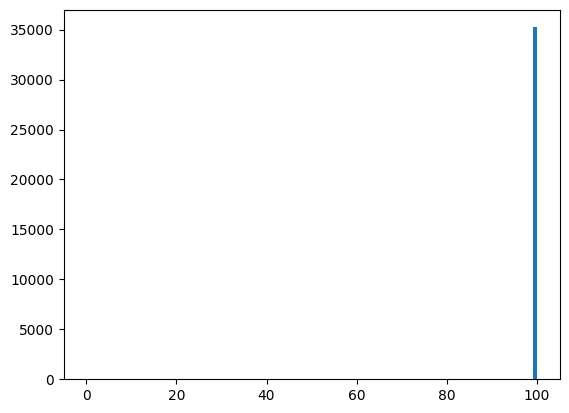

In [187]:
import random
nr_of_spectra_with_0_pairs_in_bin = []
for available_pairs_in_bin in available_pairs_per_bin_matrix:
    pairs = available_pairs_in_bin != -1
    nr_of_pairs_per_inchikey = np.sum(pairs, axis=1)
    # Optional plot complete distribution per bin
    plt.hist(nr_of_pairs_per_inchikey, bins=range(101))
    plt.ylim((0, 37000))
    plt.show()

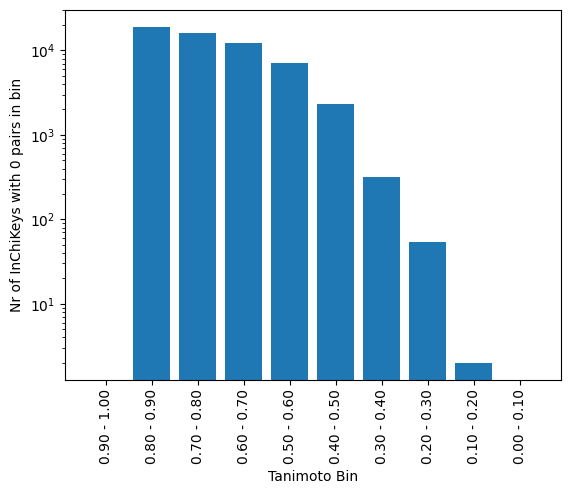

In [31]:
import random
nr_of_spectra_with_0_pairs_in_bin = []
for available_pairs_in_bin in available_pairs_per_bin_matrix:
    pairs = available_pairs_in_bin != -1
    nr_of_pairs_per_inchikey = np.sum(pairs, axis=1)
    # Optional plot complete distribution per bin
    # plt.hist(nr_of_pairs_per_inchikey, bins=range(101))
    # plt.ylim((0, 37000))
    # plt.show()
    nr_of_spectra_with_0_pairs_in_bin.append(np.sum(nr_of_pairs_per_inchikey == 0))
plt.bar([f"{i/10:.2f} - {i/10 + 0.1:.2f}" for i in reversed(range(10))], nr_of_spectra_with_0_pairs_in_bin, log=True)
plt.xticks(rotation=90)
plt.ylabel("Nr of InChiKeys with 0 pairs in bin")
plt.xlabel("Tanimoto Bin")
plt.savefig("sampling_algorithm_figures/SI2.2.svg", bbox_inches="tight")
plt.show()


# Try different bin orders

In [32]:
# Change bin order
def change_bin_order(scores_matrix_standard_order, bin_order):
    pairs_matrix = scores_matrix_standard_order[0].copy()[bin_order, :, :]
    scores_matrix = scores_matrix_standard_order[1].copy()[bin_order, :, :]
    return pairs_matrix, scores_matrix, scores_matrix_standard_order[2]

In [33]:
settings.average_inchikey_sampling_count = 100
settings.max_pair_resampling=100000
settings.max_inchikey_sampling = 110

In [34]:
pair_generator_per_bin_order = {}

### Run sampling algorithm with different sampling order over bins

In [35]:
for bin_order in [(0, 1, 2, 3, 4, 5, 6, 7, 8, 9,),
                  (1, 0, 2, 3, 4, 5, 6, 7, 8, 9,),
                  (1, 2, 0, 3, 4, 5, 6, 7, 8, 9,),
                  (1, 2, 3, 0, 4, 5, 6, 7, 8, 9,),
                  (1, 2, 3, 4, 0, 5, 6, 7, 8, 9,),
                  (1, 2, 3, 4, 5, 0, 6, 7, 8, 9,),
                  (1, 2, 3, 4, 5, 6, 0, 7, 8, 9,),
                  (1, 2, 3, 4, 5, 6, 7, 0, 8, 9,),
                  (1, 2, 3, 4, 5, 6, 7, 8, 0, 9,),
                  (1, 2, 3, 4, 5, 6, 7, 8, 9, 0,),
]:
    new_bin_order = change_bin_order(scores_matrix_standard_order, bin_order)
    pair_generator_per_bin_order[bin_order] =  get_inchikey_pairs(new_bin_order[0], 
                                                              new_bin_order[1], 
                                                              new_bin_order[2], settings)

doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 32394.73it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.70it/s]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 32479.88it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.68it/s]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 32484.79it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.65it/s]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 32302.17it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.64it/s]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 32499.68it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.63it/s]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 32365.98it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.68it/s]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 32559.00it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.70it/s]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 32517.54it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.72it/s]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 32597.93it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.71it/s]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 36615.53it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.72it/s]


### Plot difference from optimal distribution
The difference from the mean for the average per inchikey is plotted. Ideally each InChIKey has an average of 0.5 over all the sampled bins.
To test that the distribution is well over the different bins. (e.g. not half in 0-0.1 and half in 0.9-1.0, which would result in average of. 0.5) we detect the fraction of pairs concentrated in a single bin per InChiKey. Ideally this would be 0.1, perfectly equal distribution over 10 bins. 

In [36]:
absolute_diff_average_sampling = []
absolute_diff_highest_bin_ratio_of_pairs = []
for bin_order in [(0, 1, 2, 3, 4, 5, 6, 7, 8, 9,),
                  (1, 0, 2, 3, 4, 5, 6, 7, 8, 9,),
                  (1, 2, 0, 3, 4, 5, 6, 7, 8, 9,),
                  (1, 2, 3, 0, 4, 5, 6, 7, 8, 9,),
                  (1, 2, 3, 4, 0, 5, 6, 7, 8, 9,),
                  (1, 2, 3, 4, 5, 0, 6, 7, 8, 9,),
                  (1, 2, 3, 4, 5, 6, 0, 7, 8, 9,),
                  (1, 2, 3, 4, 5, 6, 7, 0, 8, 9,),
                  (1, 2, 3, 4, 5, 6, 7, 8, 0, 9,),
                  (1, 2, 3, 4, 5, 6, 7, 8, 9, 0,),
]:
    scores_per_inchikey = pair_generator_per_bin_order[bin_order].get_scores_per_inchikey().values()
    inchikey_average_sampling = np.array([sum(scores)/len(scores) for scores in scores_per_inchikey])
    absolute_diff_average_sampling.append(sum(abs(inchikey_average_sampling-0.5))/len(inchikey_average_sampling))

    max_count_per_bin = []
    for scores in scores_per_inchikey:
        counts, _ = np.histogram(scores, bins=[i/10 for i in range(11)])
        max_count_per_bin.append(max(counts)/len(scores))
    absolute_diff_highest_bin_ratio_of_pairs.append(sum(abs(np.array(max_count_per_bin)))/len(max_count_per_bin))


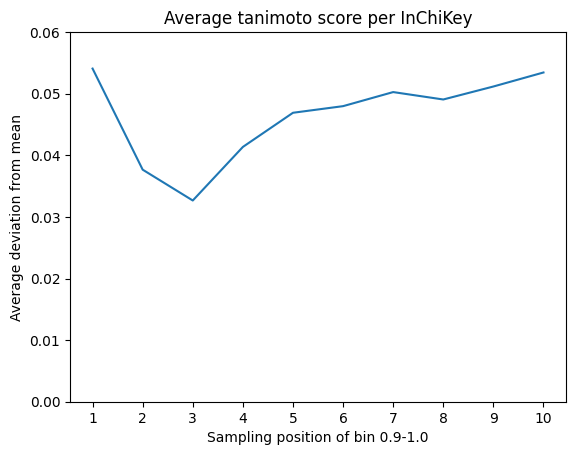

In [37]:
plt.plot(range(1, 11), absolute_diff_average_sampling)
plt.xticks(range(1, 11))
plt.ylim(0, 0.06)
plt.xlabel("Sampling position of bin 0.9-1.0")
plt.title("Average tanimoto score per InChiKey")
plt.ylabel("Average deviation from mean")
plt.savefig("sampling_algorithm_figures/SI2.3a.svg", bbox_inches="tight")
plt.show()

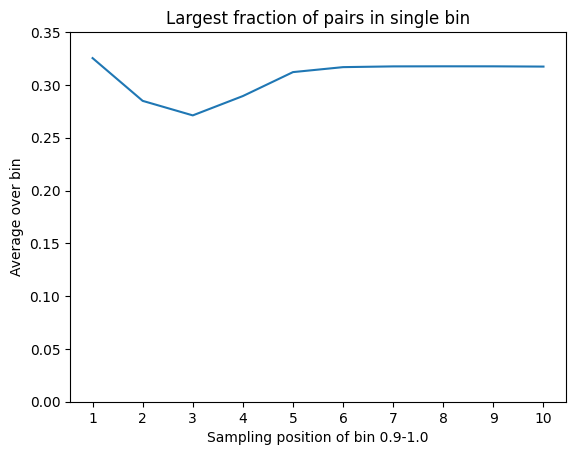

In [38]:
plt.plot(range(1, 11), absolute_diff_highest_bin_ratio_of_pairs)
plt.xticks(range(1, 11))
plt.ylim(0, 0.35)
plt.xlabel("Sampling position of bin 0.9-1.0")
plt.title("Largest fraction of pairs in single bin")
plt.ylabel("Average over bin")
plt.savefig("sampling_algorithm_figures/SI2.3b.svg", bbox_inches="tight")
plt.show()

### Plot RMSE metric
Same metric as above, but RMSE instead of abolute distance

In [39]:
rmse_average_sampling = []
rmse_highest_bin_ratio_of_pairs = []
for bin_order in [(0, 1, 2, 3, 4, 5, 6, 7, 8, 9,),
                  (1, 0, 2, 3, 4, 5, 6, 7, 8, 9,),
                  (1, 2, 0, 3, 4, 5, 6, 7, 8, 9,),
                  (1, 2, 3, 0, 4, 5, 6, 7, 8, 9,),
                  (1, 2, 3, 4, 0, 5, 6, 7, 8, 9,),
                  (1, 2, 3, 4, 5, 0, 6, 7, 8, 9,),
                  (1, 2, 3, 4, 5, 6, 0, 7, 8, 9,),
                  (1, 2, 3, 4, 5, 6, 7, 0, 8, 9,),
                  (1, 2, 3, 4, 5, 6, 7, 8, 0, 9,),
                  (1, 2, 3, 4, 5, 6, 7, 8, 9, 0,),
]:
    scores_per_inchikey = pair_generator_per_bin_order[bin_order].get_scores_per_inchikey().values()
    inchikey_average_sampling = np.array([sum(scores)/len(scores) for scores in scores_per_inchikey])
    rmse_average_sampling.append((sum((inchikey_average_sampling-0.5)**2)/len(inchikey_average_sampling))**0.5)

    max_count_per_bin = []
    for scores in scores_per_inchikey:
        counts, _ = np.histogram(scores, bins=[i/10 for i in range(11)])
        max_count_per_bin.append(max(counts)/len(scores))
    rmse_highest_bin_ratio_of_pairs.append((sum((np.array(max_count_per_bin)-0.1)**2)/len(max_count_per_bin))**0.5)

    

Text(0, 0.5, 'RMSE of average tanimoto score per InChiKey')

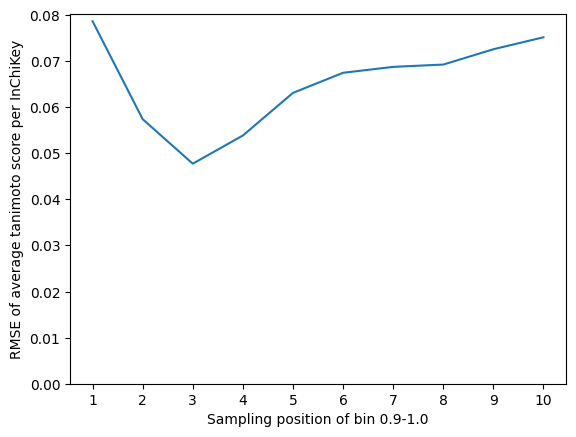

In [229]:
plt.plot(range(1, 11), rmse_average_sampling)
plt.xticks(range(1, 11))
plt.ylim(0)
plt.xlabel("Sampling position of bin 0.9-1.0")
plt.ylabel("RMSE of average tanimoto score per InChiKey")
plt.show()

Text(0, 0.5, 'RMSE of highest bin ratio per InChiKey')

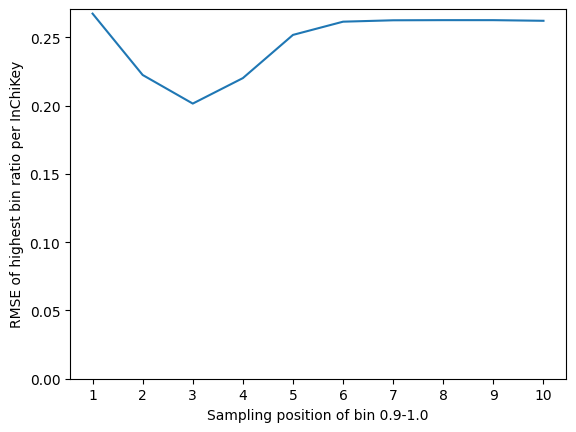

In [230]:
plt.plot(range(1, 11), rmse_highest_bin_ratio_of_pairs)
plt.xticks(range(1, 11))
plt.ylim(0)
plt.xlabel("Sampling position of bin 0.9-1.0")
plt.ylabel("RMSE of highest fraction of pairs in single bin per InChiKey")

### Nr of inchikeys per bin for different bin orders

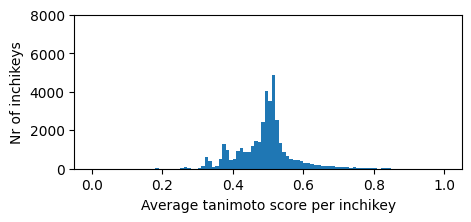

In [47]:
bin_order = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9,)
fig, axes = plt.subplots(1, 1, figsize=(5, 2))

scores_per_inchikey = pair_generator_per_bin_order[bin_order].get_scores_per_inchikey().values()
inchikey_average_sampling = [sum(scores)/len(scores) for scores in scores_per_inchikey]
axes.hist(inchikey_average_sampling, bins=[i/100 for i in range(101)])
axes.set_xlabel("Average tanimoto score per inchikey")
axes.set_ylabel("Nr of inchikeys")
axes.set_ylim((0,8000))
fig.savefig("sampling_algorithm_figures/SI2.4a.svg", bbox_inches="tight")
fig.show()

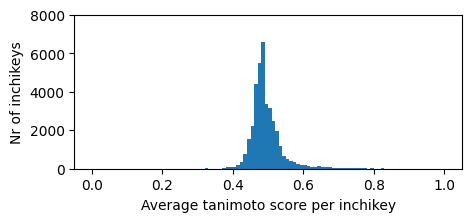

In [48]:
bin_order = (1, 2, 0, 3, 4, 5, 6, 7, 8, 9,)
fig, axes = plt.subplots(1, 1, figsize=(5, 2))
scores_per_inchikey = pair_generator_per_bin_order[bin_order].get_scores_per_inchikey().values()
inchikey_average_sampling = [sum(scores)/len(scores) for scores in scores_per_inchikey]
axes.hist(inchikey_average_sampling, bins=[i/100 for i in range(101)])
axes.set_xlabel("Average tanimoto score per inchikey")
axes.set_ylabel("Nr of inchikeys")
axes.set_ylim((0,8000))
fig.savefig("sampling_algorithm_figures/SI2.4b.svg", bbox_inches="tight")
fig.show()

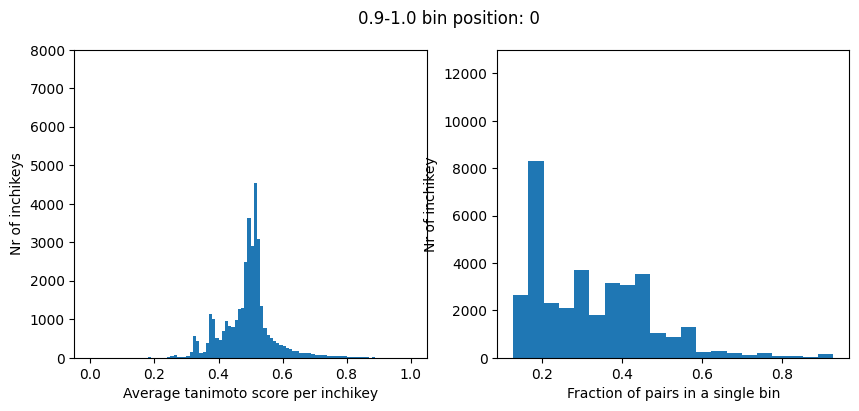

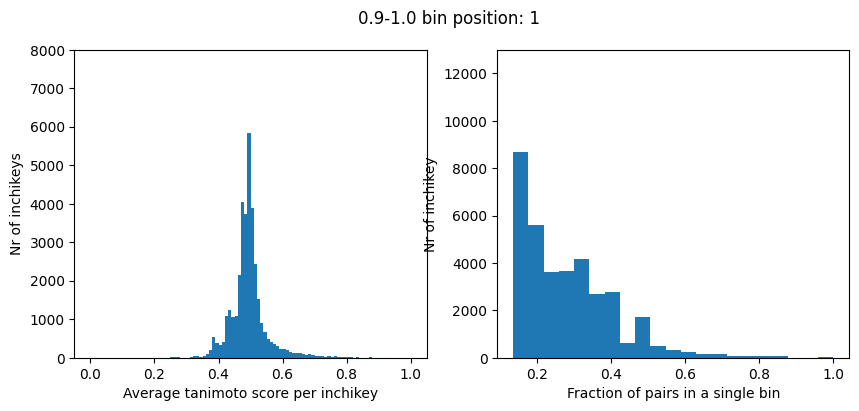

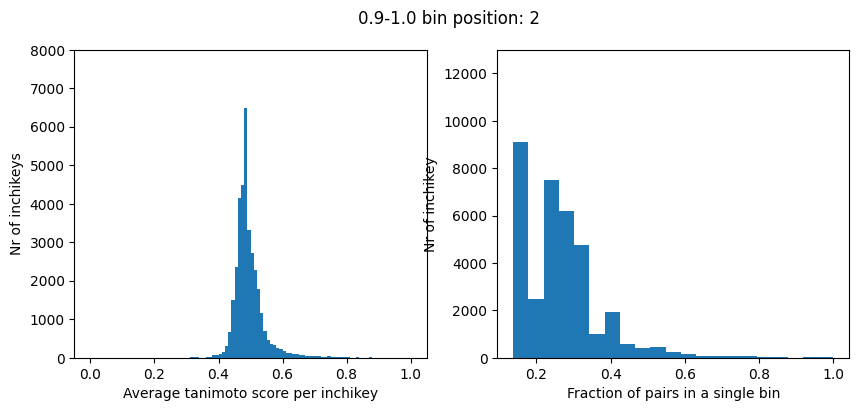

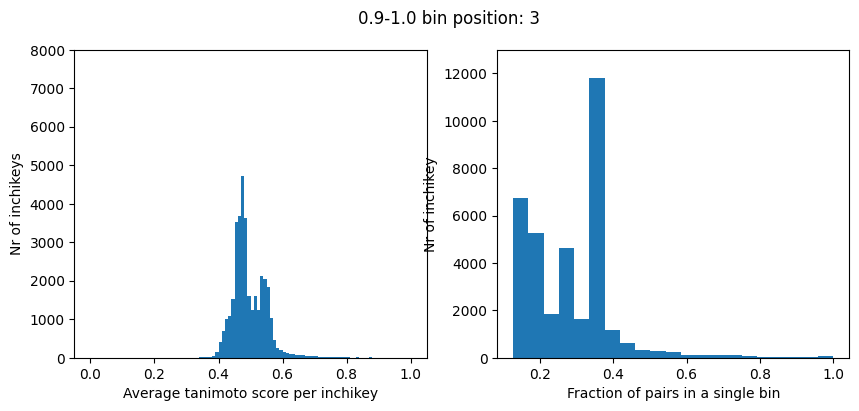

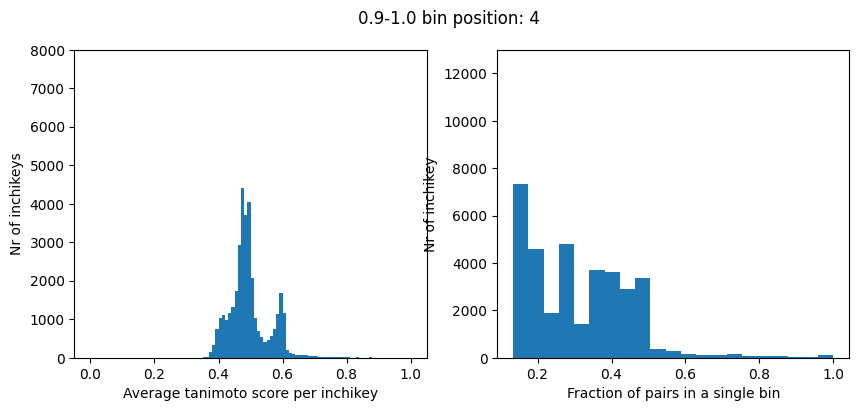

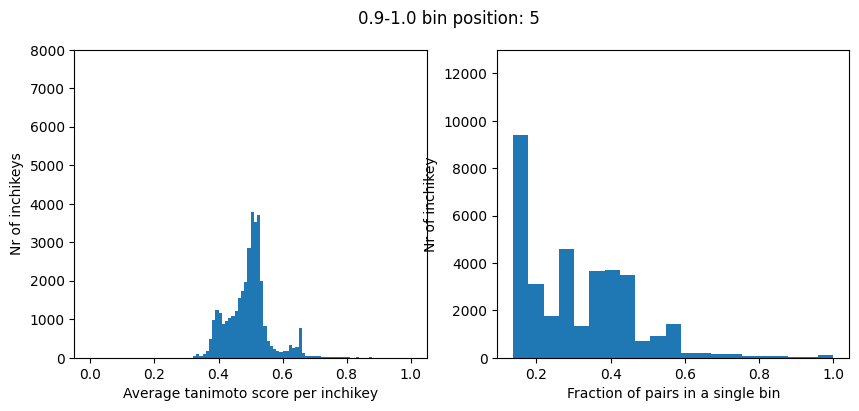

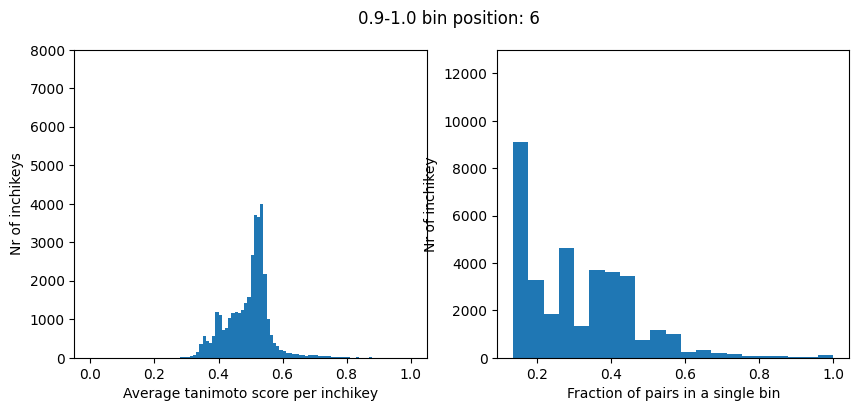

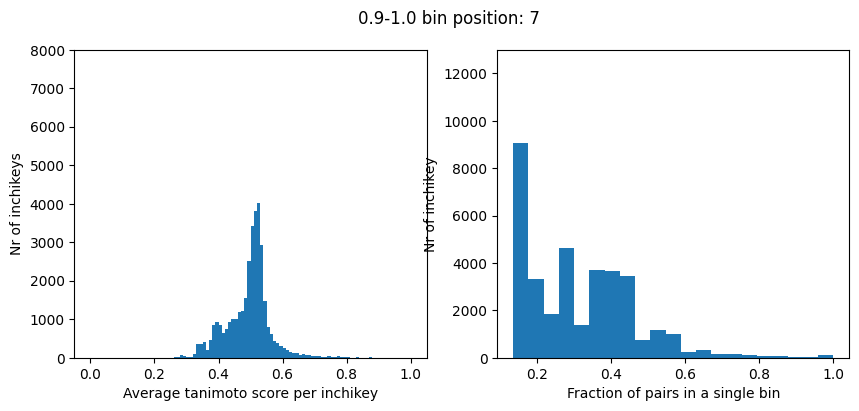

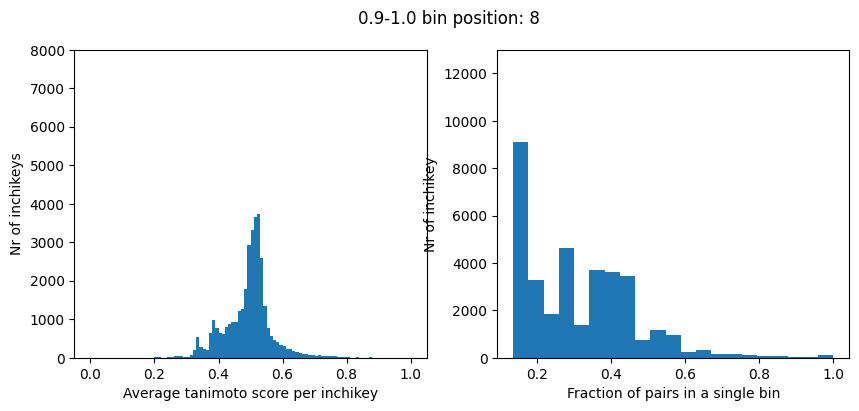

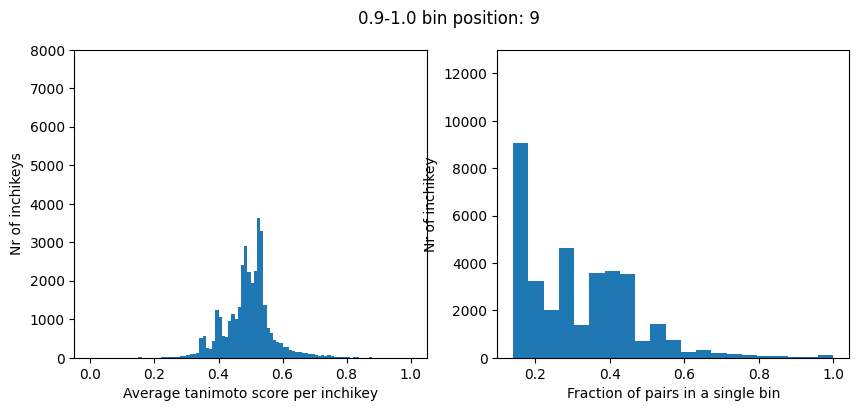

In [242]:
for bin_order in [(0, 1, 2, 3, 4, 5, 6, 7, 8, 9,),
                  (1, 0, 2, 3, 4, 5, 6, 7, 8, 9,),
                  (1, 2, 0, 3, 4, 5, 6, 7, 8, 9,),
                  (1, 2, 3, 0, 4, 5, 6, 7, 8, 9,),
                  (1, 2, 3, 4, 0, 5, 6, 7, 8, 9,),
                  (1, 2, 3, 4, 5, 0, 6, 7, 8, 9,),
                  (1, 2, 3, 4, 5, 6, 0, 7, 8, 9,),
                  (1, 2, 3, 4, 5, 6, 7, 0, 8, 9,),
                  (1, 2, 3, 4, 5, 6, 7, 8, 0, 9,),
                  (1, 2, 3, 4, 5, 6, 7, 8, 9, 0,),]:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    fig.suptitle(f"0.9-1.0 bin position: {bin_order.index(0)}")
    
    scores_per_inchikey = pair_generator_per_bin_order[bin_order].get_scores_per_inchikey().values()
    inchikey_average_sampling = [sum(scores)/len(scores) for scores in scores_per_inchikey]
    axes[0].hist(inchikey_average_sampling, bins=[i/100 for i in range(101)])
    axes[0].set_xlabel("Average tanimoto score per inchikey")
    axes[0].set_ylabel("Nr of inchikeys")
    axes[0].set_ylim((0,8000))

    max_count_per_bin = []
    most_sampled_bins = []
    for scores in scores_per_inchikey:
        counts, _ = np.histogram(scores, bins=[i/10 for i in range(11)])
        most_sampled_bins.append(np.argmax(counts))
        max_count_per_bin.append(max(counts)/len(scores))
    axes[1].hist(max_count_per_bin, bins=21)
    axes[1].set_xlabel("Fraction of pairs in a single bin")
    axes[1].set_ylabel("Nr of inchikey")
    axes[1].set_ylim((0, 13000))
    plt.show()


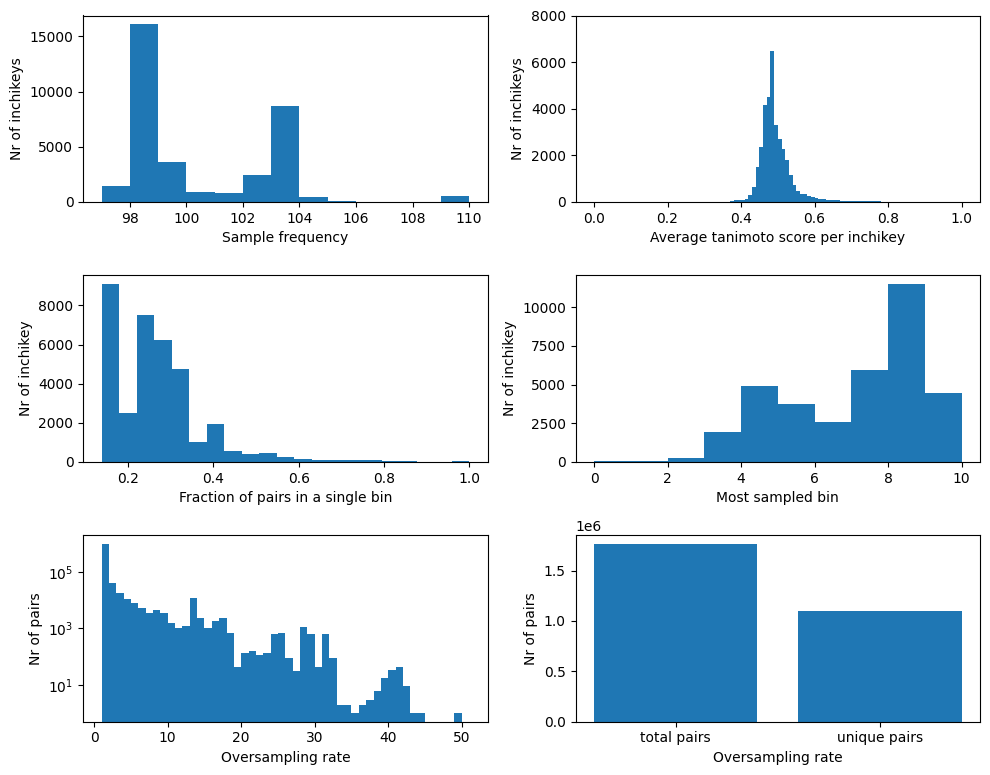

In [243]:
plot_diagnostic_plots(pair_generator_per_bin_order[(1, 2, 0, 3, 4, 5, 6, 7, 8, 9,)], "")

# Test average_inchikey_sampling_count
The average inchikeys sampled can be increased, this will result in more different pairs, but also longer sampling time. 


In [53]:

settings.max_pair_resampling=1000000

bin_order = (1, 2, 0, 3, 4, 5, 6, 7, 8, 9,)
new_bin_order = change_bin_order(scores_matrix_standard_order, bin_order)

pair_generator_average_sampling = {}
for average_sampling in (10, 50, 100, 200, 300, 400, 800, 1200, 2400):
    settings.average_inchikey_sampling_count = average_sampling
    settings.max_inchikey_sampling = average_sampling * 1.3  
    pair_generator_average_sampling[average_sampling] =  get_inchikey_pairs(new_bin_order[0], 
                                                                            new_bin_order[1], 
                                                                            new_bin_order[2], settings)

doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|███████████████████████████████████████████████████████████████████████████████████████████| 18808/18808 [00:00<00:00, 33209.87it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.14it/s]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|███████████████████████████████████████████████████████████████████████████████████████████| 94042/94042 [00:02<00:00, 33190.20it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.17it/s]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 33157.71it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.66it/s]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 376170/376170 [00:11<00:00, 33188.19it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.17it/s]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 564255/564255 [00:17<00:00, 33054.15it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.09s/it]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 752340/752340 [00:22<00:00, 32915.62it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.32s/it]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|███████████████████████████████████████████████████████████████████████████████████████| 1504680/1504680 [00:46<00:00, 32578.92it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.13s/it]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|███████████████████████████████████████████████████████████████████████████████████████| 2257020/2257020 [01:09<00:00, 32394.81it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.99s/it]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|███████████████████████████████████████████████████████████████████████████████████████| 4514040/4514040 [03:54<00:00, 19266.47it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.61s/it]


In [356]:
average_sampling = 2400
settings.average_inchikey_sampling_count = average_sampling
settings.max_inchikey_sampling = average_sampling * 1.3
pair_generator_average_sampling[average_sampling] =  get_inchikey_pairs(new_bin_order[0], 
                                                                        new_bin_order[1], 
                                                                        new_bin_order[2], settings)

doing balanced selection


Balanced sampling of inchikey pairs (per bin):  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 3282965/4229520 [05:38<01:26, 10943.25it/s]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [313]:
number_of_unique_pairs = []
for average_sampling in (10, 50, 100, 200, 300, 400, 800):
    number_of_unique_pairs.append(len(set(pair_generator_average_sampling[average_sampling].selected_inchikey_pairs)))


Text(0.5, 0, 'Average nr of pairs per InChiKey')

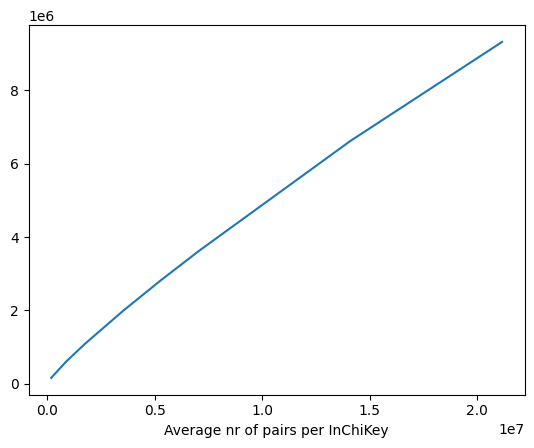

In [353]:
number_of_unique_pairs = []
total_number_of_pairs = []
for average_sampling in (10, 50, 100, 200, 300, 400, 800, 1200):
    number_of_unique_pairs.append(len(set(pair_generator_average_sampling[average_sampling].selected_inchikey_pairs)))
    total_number_of_pairs.append(average_sampling*35246/2)
plt.plot(total_number_of_pairs, number_of_unique_pairs)
plt.xlabel("Average nr of pairs per InChiKey")


In [54]:
sampling_count_per_bin = {}
for bin_nr in range(10):
    bin_label = f"{bin_nr/10:.2f} - {bin_nr/10 + 0.1:.2f}"
    sampling_count_per_bin[bin_label] = []
    
for average_sampling in tqdm((10, 50, 100, 200, 300, 400, 800, 1200, 2400)):
    scores_for_unique_pairs = [score for _, _, score in set(pair_generator_average_sampling[average_sampling].selected_inchikey_pairs)]
    for bin_nr in range(10):
        bin_label = f"{bin_nr/10:.2f} - {bin_nr/10 + 0.1:.2f}" 
        sampling_count_per_bin[bin_label].append(np.histogram(scores_for_unique_pairs, bins=[i/10 for i in range(11)])[0][bin_nr])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:04<00:00, 20.45s/it]


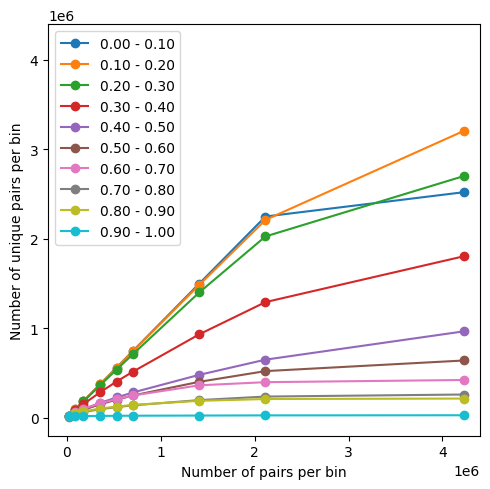

In [55]:
plt.figure(figsize=(5, 5))

for bin_nr in range(10):
    bin_label = f"{bin_nr/10:.2f} - {bin_nr/10 + 0.1:.2f}" 
    sampling_count_for_bin = sampling_count_per_bin[bin_label]
    plt.plot([i * 35246/2 / 10 for i in (10, 50, 100, 200, 300, 400, 800, 1200, 2400)], sampling_count_for_bin, "o-", label = bin_label)

plt.legend()
plt.xlabel("Number of pairs per bin")
plt.ylabel("Number of unique pairs per bin")
plt.xlim(-200000, 4400000)
plt.ylim(-200000, 4400000)

plt.tight_layout()
plt.savefig("sampling_algorithm_figures/SI2.6a.svg", bbox_inches="tight")
plt.show()
# plt.subplots_adjust(right=0.75) 

### Plot diagnostic plots 

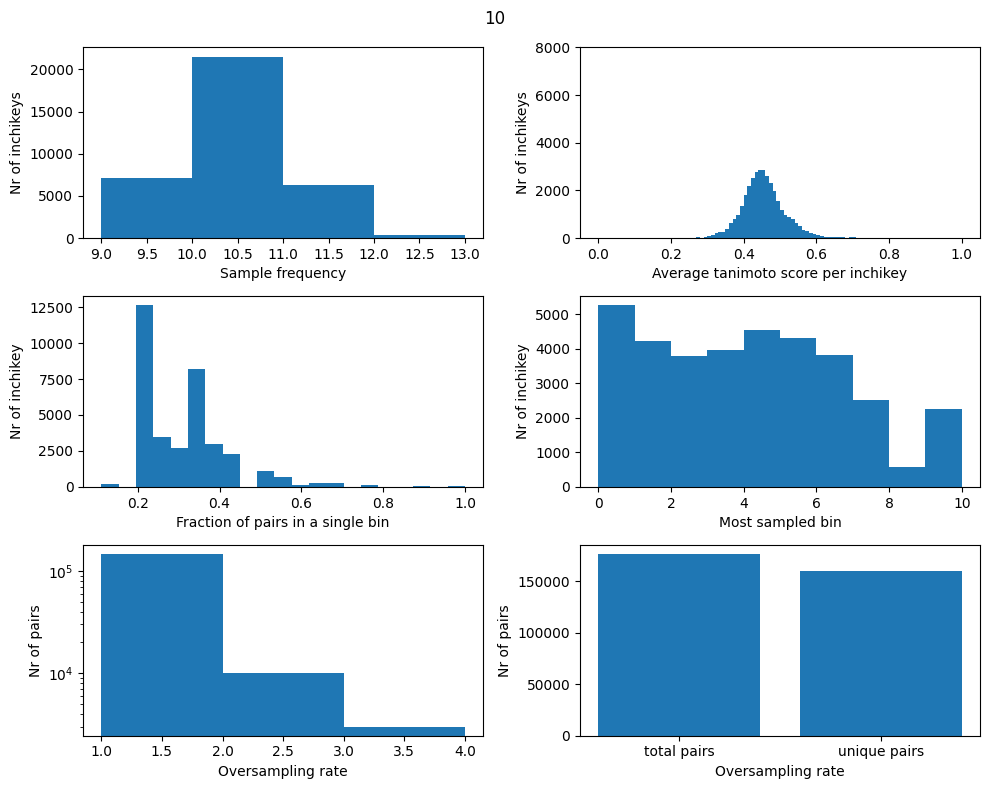

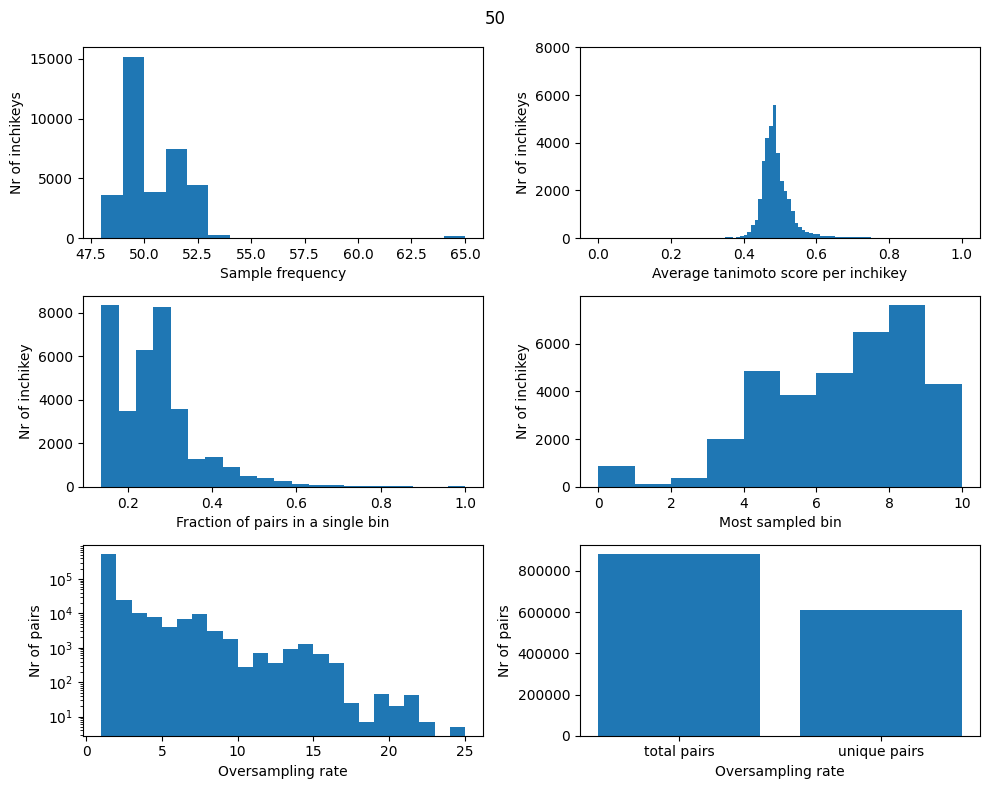

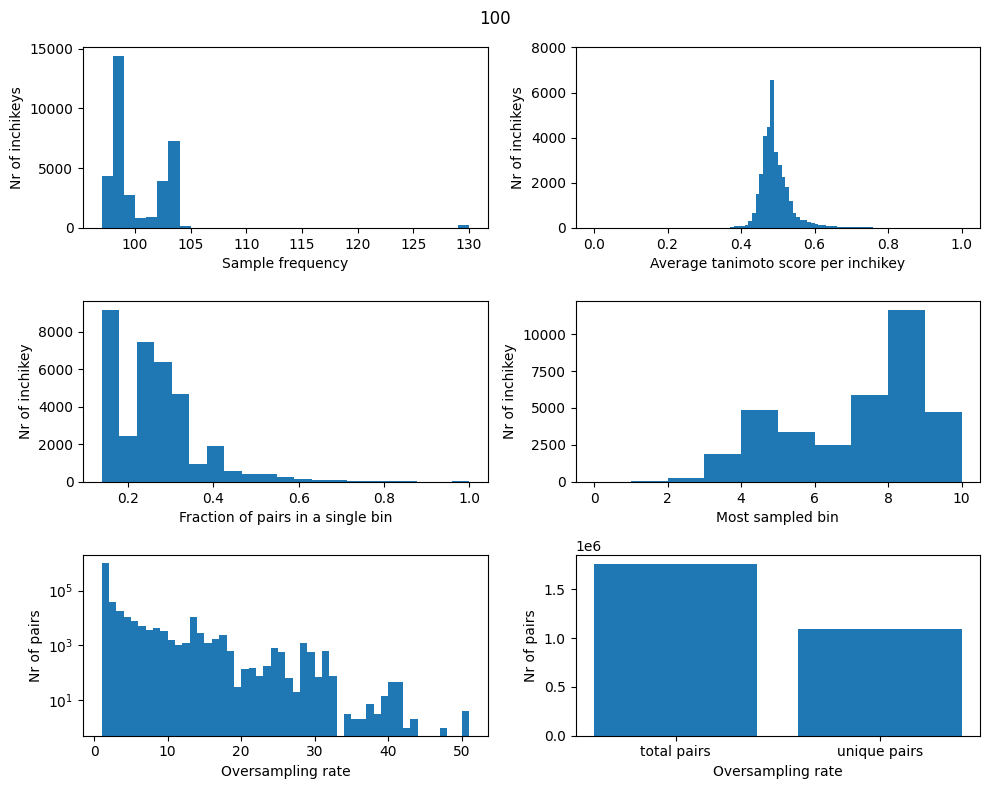

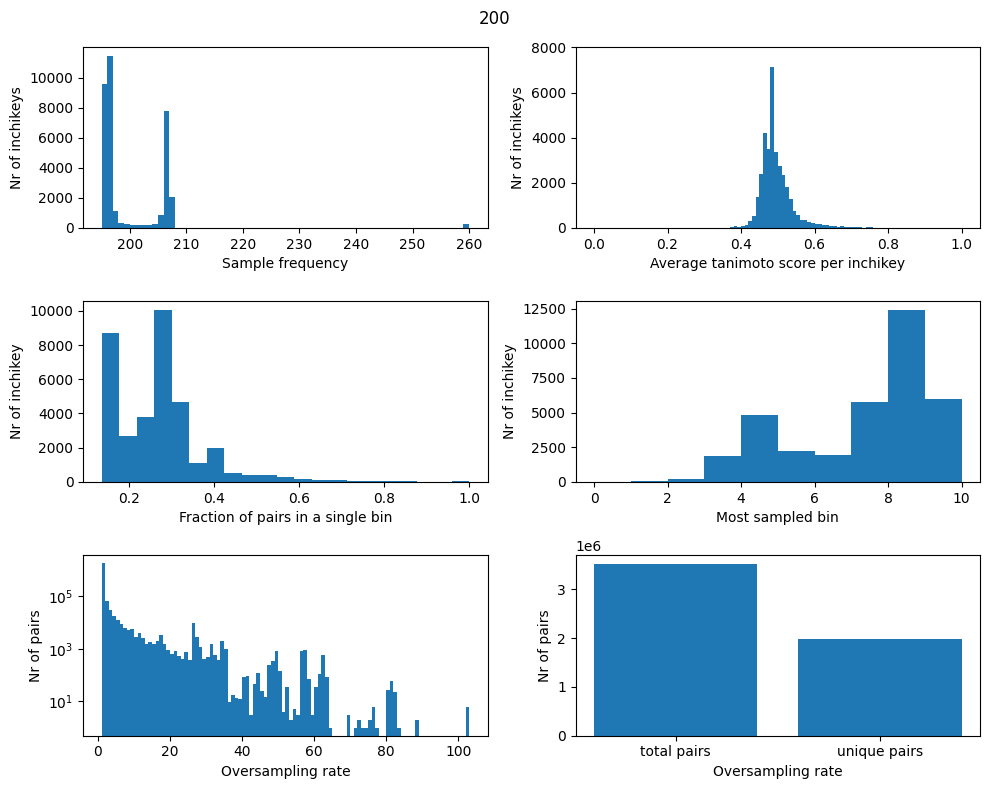

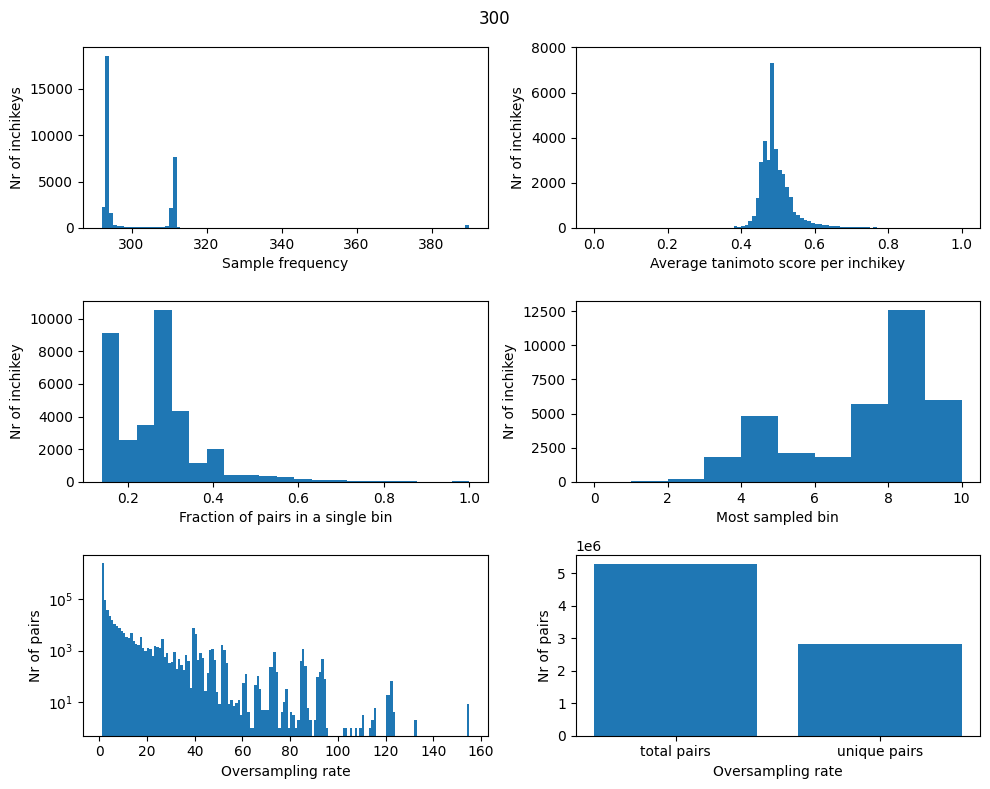

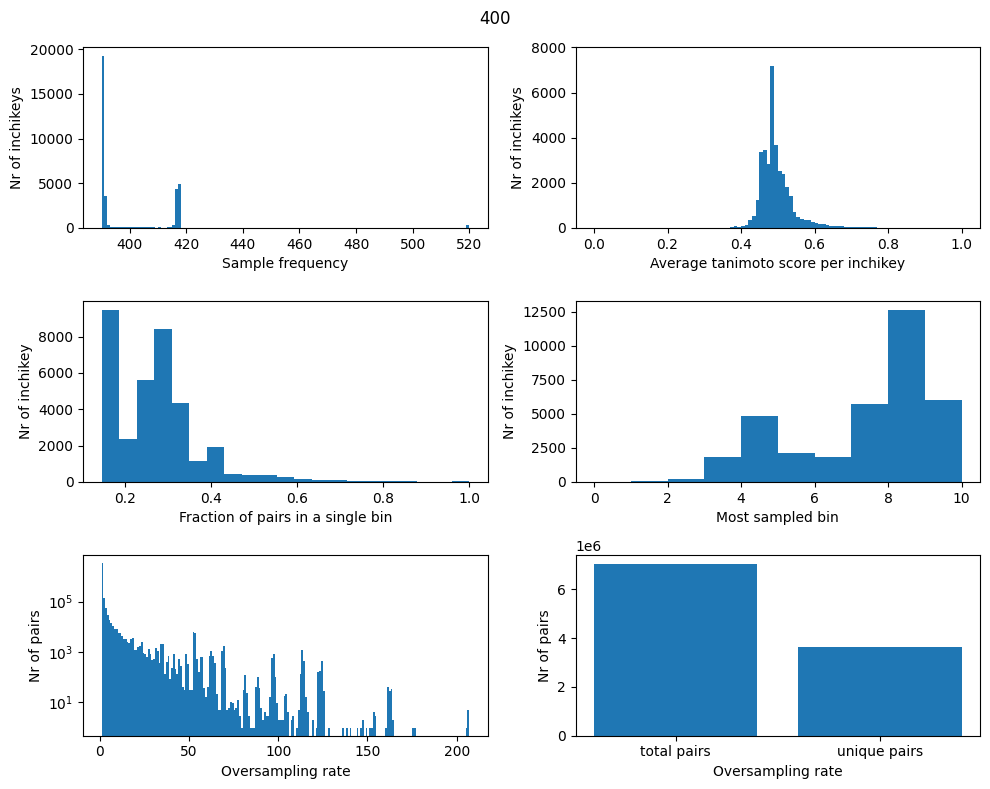

In [286]:
for average_sampling in (10, 50, 100, 200, 300, 400):
    plot_diagnostic_plots(pair_generator_average_sampling[average_sampling], str(average_sampling))

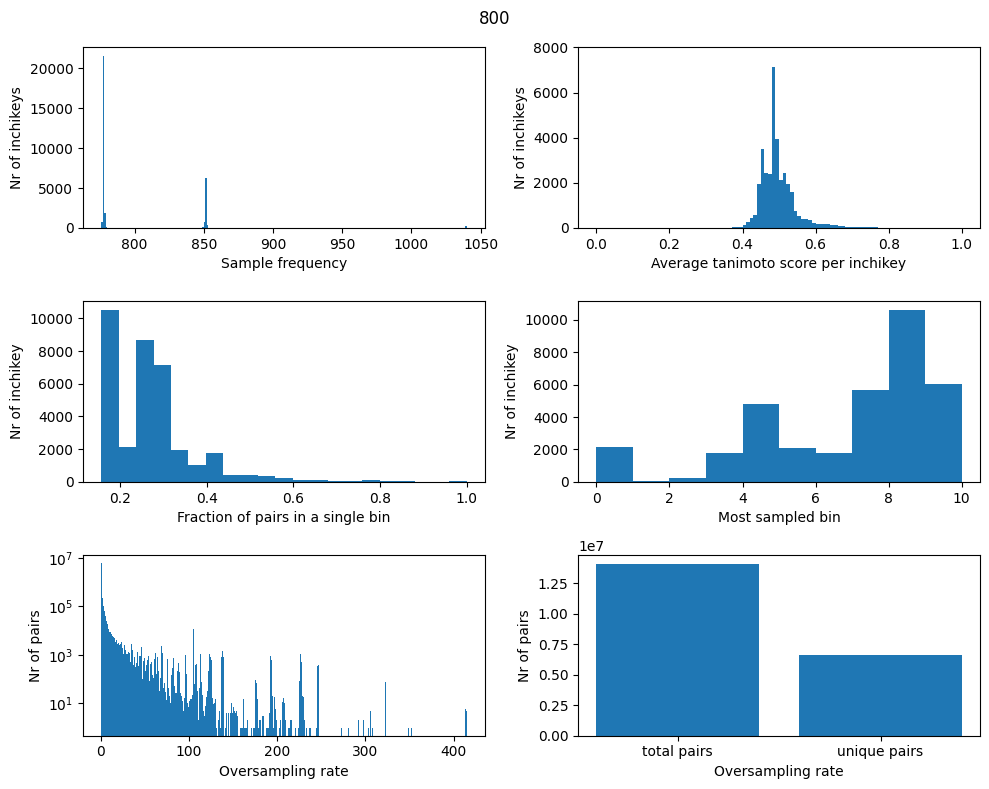

In [350]:
plot_diagnostic_plots(pair_generator_average_sampling[800], str(800))

# Test maximum resampling
Resampling is needed to get a good balance of InChiKey sampling frequency and a good balance over pairs. Here we test the effect of limiting the resampling frequency.

In [50]:
settings.average_inchikey_sampling_count = 100
settings.max_inchikey_sampling = 110
bin_order = (1, 2, 0, 3, 4, 5, 6, 7, 8, 9,)
new_bin_order = change_bin_order(scores_matrix_standard_order, bin_order)

pair_generator_resampling_max = {}
for max_pair_resampling in (10, 20, 30, 40, 50, 60):
    settings.max_pair_resampling=max_pair_resampling
    pair_generator_resampling_max[max_pair_resampling] =  get_inchikey_pairs(new_bin_order[0], 
                                                                             new_bin_order[1], 
                                                                             new_bin_order[2], settings)

doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 32232.72it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.64it/s]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 32641.71it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.66it/s]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 32639.97it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.65it/s]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 32526.50it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.65it/s]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 32424.81it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.64it/s]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 32540.77it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.65it/s]


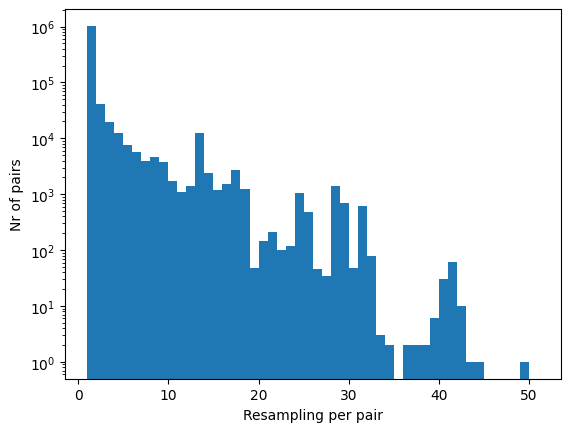

In [61]:
# Plot oversampling rate per pair
oversampling_rates = Counter(pair_generator_resampling_max[60].selected_inchikey_pairs).values()
plt.hist(oversampling_rates, bins = range(min(oversampling_rates), max(oversampling_rates)), log =True)
plt.xlabel("Resampling per pair")
plt.ylabel("Nr of pairs")
# plt.title("No maximum pair resampling rate")
plt.savefig("sampling_algorithm_figures/SI2.5a.svg", bbox_inches="tight")
plt.show()

In [52]:
for max_pair_resampling in (15, 25, 5):
    settings.max_pair_resampling=max_pair_resampling
    pair_generator_resampling_max[max_pair_resampling] =  get_inchikey_pairs(new_bin_order[0], 
                                                                             new_bin_order[1], 
                                                                             new_bin_order[2], settings)

doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 32427.66it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.68it/s]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 32565.77it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.67it/s]


doing balanced selection


Balanced sampling of inchikey pairs (per bin): 100%|█████████████████████████████████████████████████████████████████████████████████████████| 188085/188085 [00:05<00:00, 32545.63it/s]


converting to a pairs list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.66it/s]


In [56]:
absolute_diff_average_sampling_max_resampling = []
absolute_diff_highest_bin_ratio_of_pairs_max_resampling = []
nr_of_unique_pairs = []

for max_pair_resampling in (5, 10, 15, 20, 25, 30, 40, 50, 60):
    scores_per_inchikey = pair_generator_resampling_max[max_pair_resampling].get_scores_per_inchikey().values()
    inchikey_average_sampling = np.array([sum(scores)/len(scores) for scores in scores_per_inchikey])
    absolute_diff_average_sampling_max_resampling.append(sum(abs(inchikey_average_sampling-0.5))/len(inchikey_average_sampling))

    max_count_per_bin = []
    for scores in scores_per_inchikey:
        counts, _ = np.histogram(scores, bins=[i/10 for i in range(11)])
        max_count_per_bin.append(max(counts)/len(scores))
    absolute_diff_highest_bin_ratio_of_pairs_max_resampling.append(sum(abs(np.array(max_count_per_bin)))/len(max_count_per_bin))
    nr_of_unique_pairs.append(len(set(pair_generator_resampling_max[max_pair_resampling].selected_inchikey_pairs)))


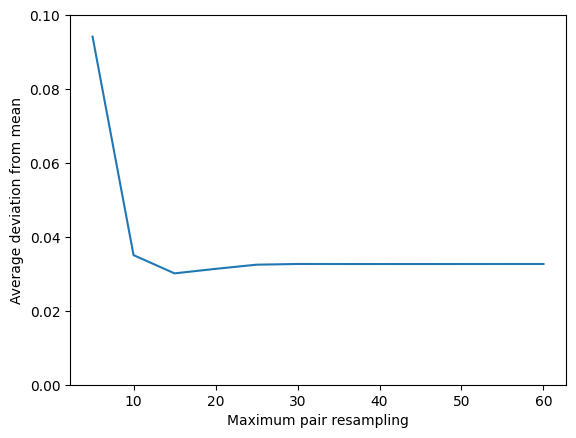

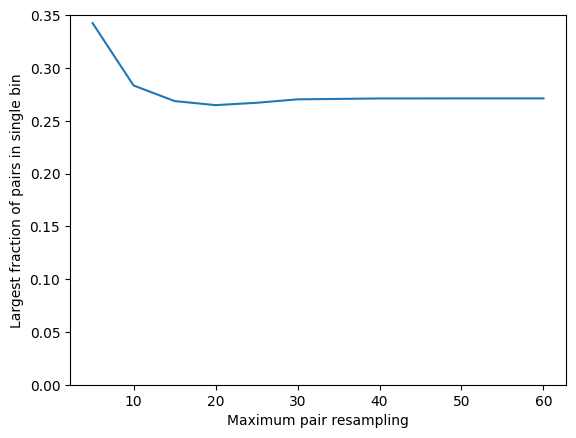

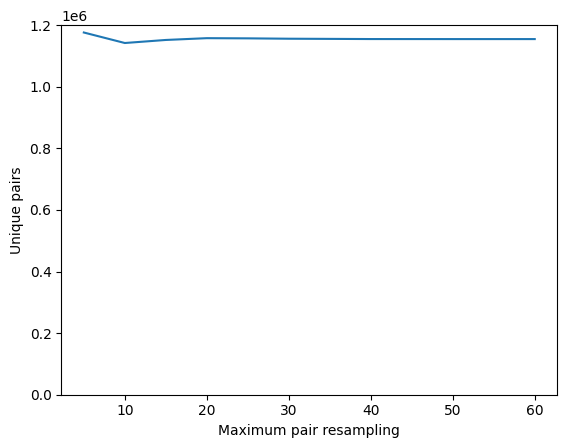

In [63]:
plt.plot((5, 10, 15, 20, 25, 30, 40, 50, 60), absolute_diff_average_sampling_max_resampling)
# plt.xticks(range(1, 11))
plt.ylim(0,0.10)
plt.xlabel("Maximum pair resampling")
# plt.title("Average tanimoto score per InChiKey")
plt.ylabel("Average deviation from mean")
plt.savefig("sampling_algorithm_figures/SI2.5c.svg", bbox_inches="tight")
plt.show()

plt.plot((5, 10, 15, 20, 25, 30, 40, 50, 60), absolute_diff_highest_bin_ratio_of_pairs_max_resampling)
# plt.xticks(range(1, 11))
plt.ylim(0, 0.35)
plt.xlabel("Maximum pair resampling")
# plt.title("Largest fraction of pairs in single bin")

plt.ylabel("Largest fraction of pairs in single bin")
plt.savefig("sampling_algorithm_figures/SI2.5d.svg", bbox_inches="tight")
plt.show()

plt.plot((5, 10, 15, 20, 25, 30, 40, 50, 60), nr_of_unique_pairs)
# plt.xticks(range(1, 11))
plt.ylim(0, 1200000)
plt.xlabel("Maximum pair resampling")
plt.ylabel("Unique pairs")
plt.savefig("sampling_algorithm_figures/SI2.5b.svg", bbox_inches="tight")
plt.show()

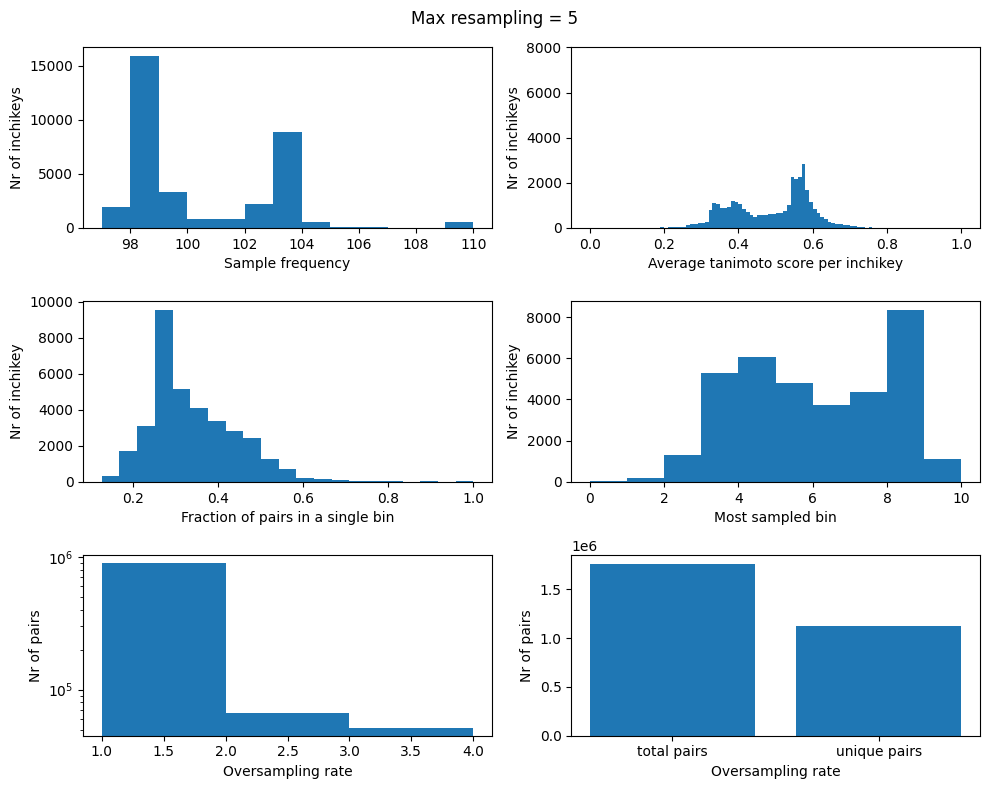

In [289]:
plot_diagnostic_plots(pair_generator_resampling_max[5], "Max resampling = 5")

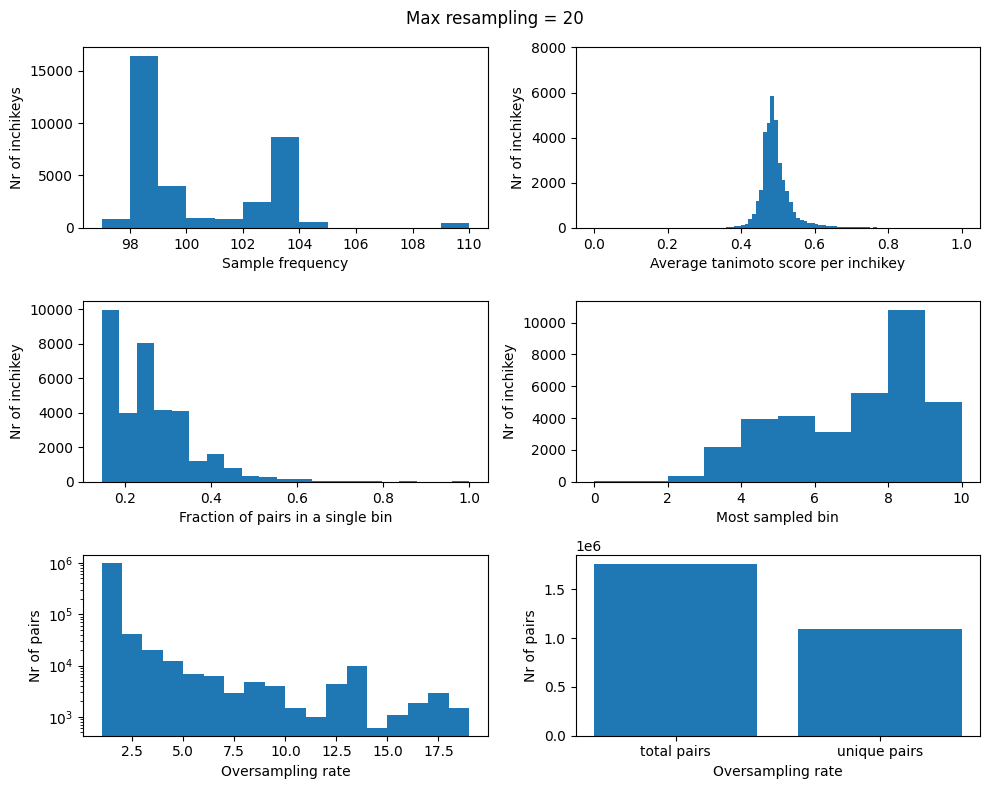

In [254]:
plot_diagnostic_plots(pair_generator_resampling_max[20], "Max resampling = 20")

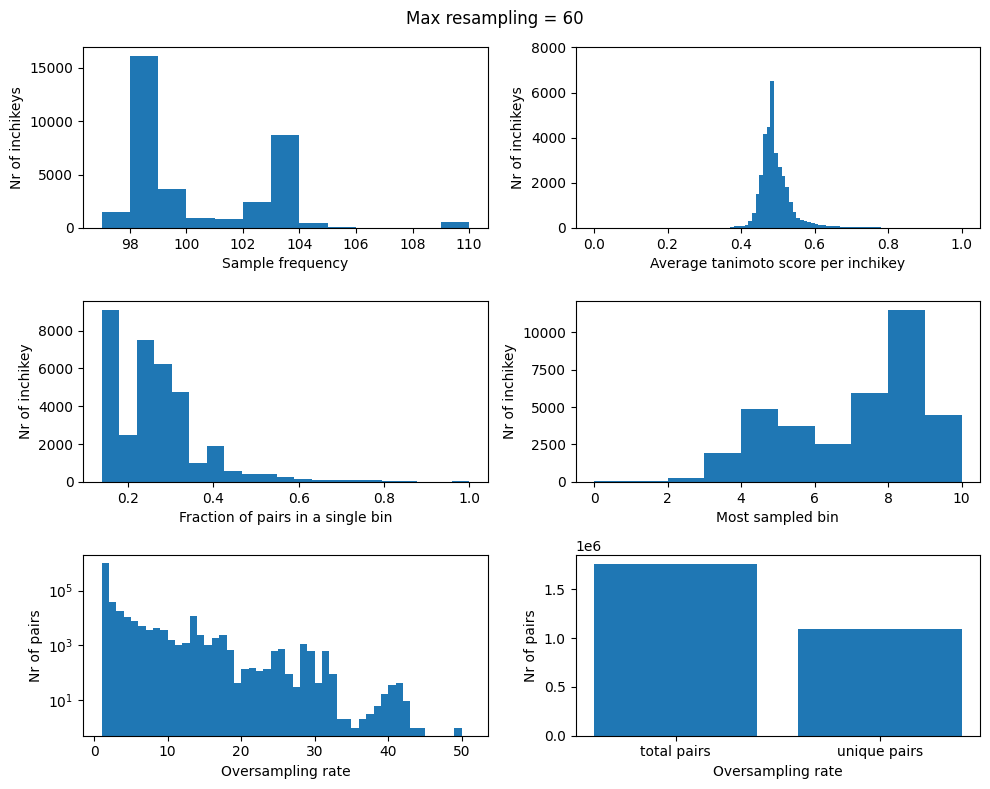

In [247]:
plot_diagnostic_plots(pair_generator_resampling_max[60], "Max resampling = 60")

# Additional tests
Below some functions for analyzing the most extreme cases of not well distributed InChiKeys over the tanimoto scores. This might be an argument for setting a maximum number an InChiKey can be sampled in a single bin (instead of a maximum number of sampling in total). We did not implement this, since this was the case for a low amount of spectra.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1762300/1762300 [00:01<00:00, 1106789.36it/s]


0.7921640024735377


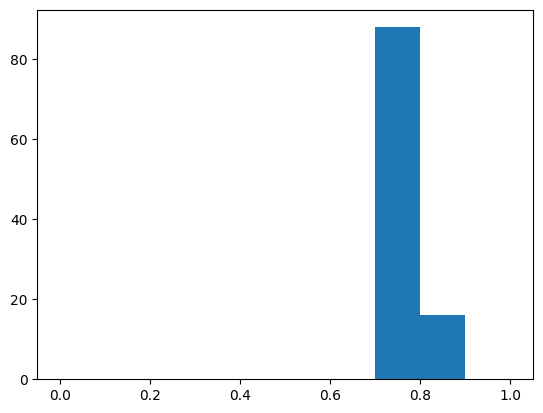

0.8279986824744787


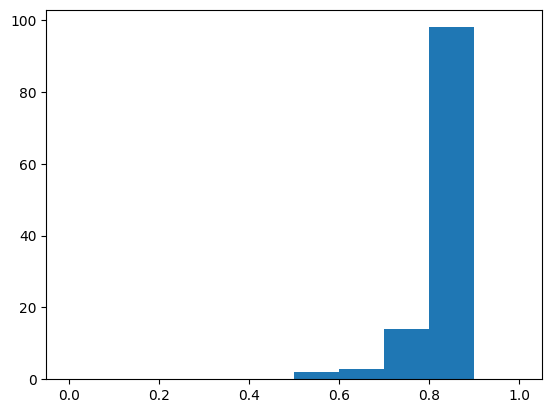

0.7629329759095397


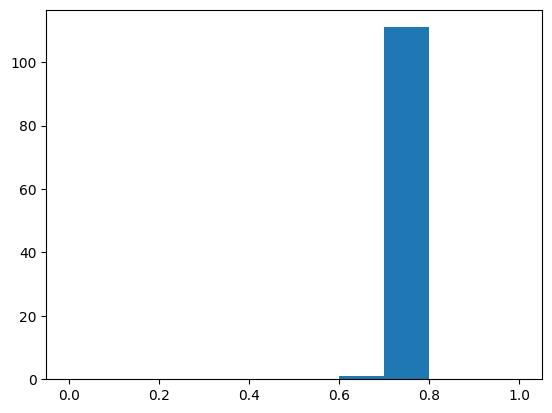

0.7584495793941409


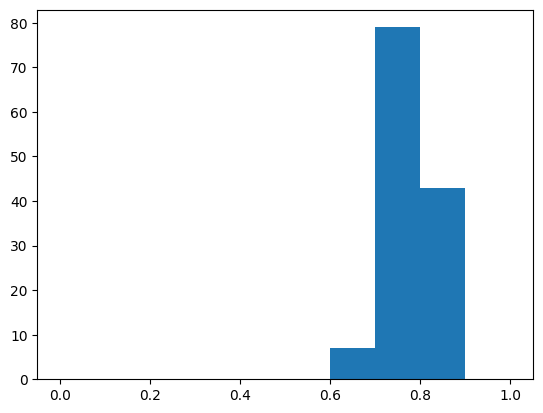

0.7971870633316975


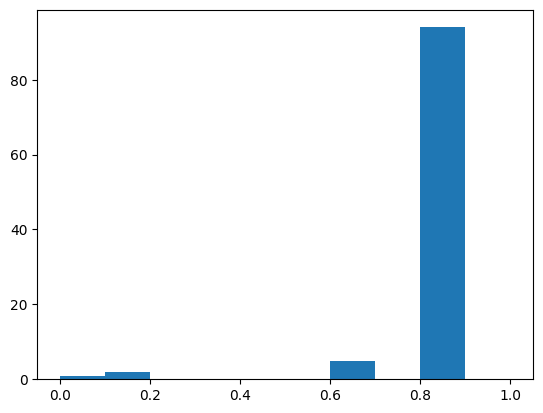

0.7679404713669602


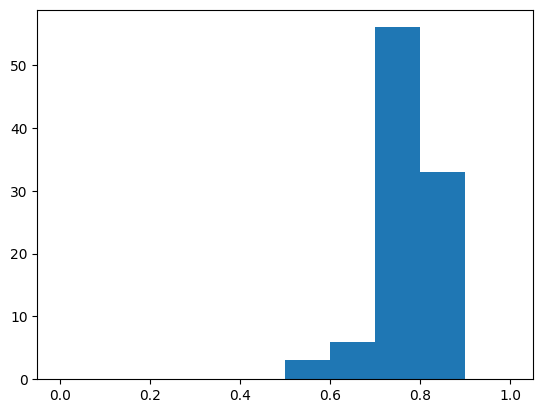

0.7702721639197002


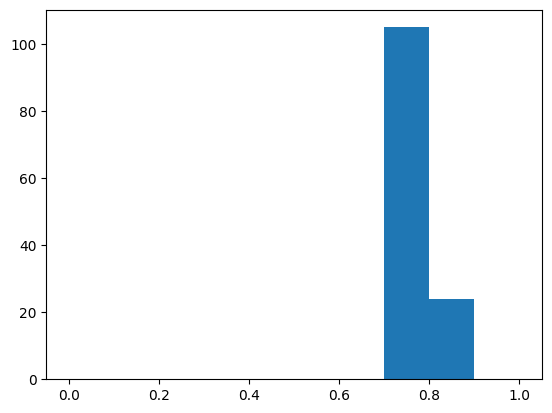

0.8320179261705455


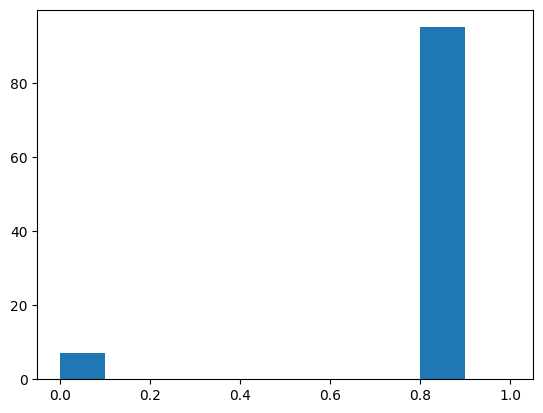

0.7704243910374101


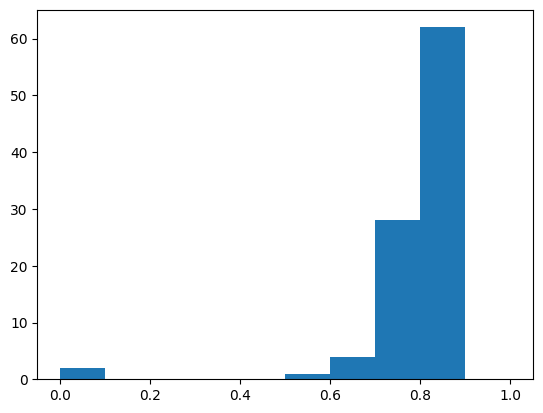

0.7643051759577265


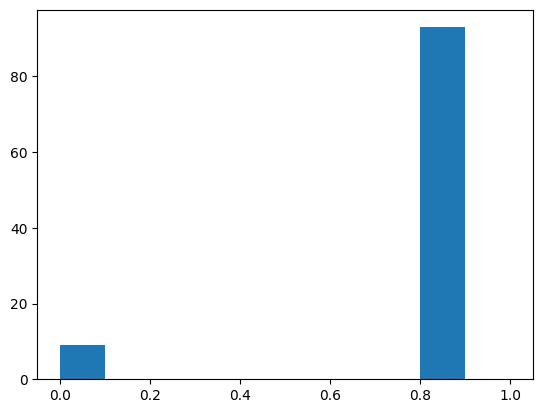

0.7620174201946814


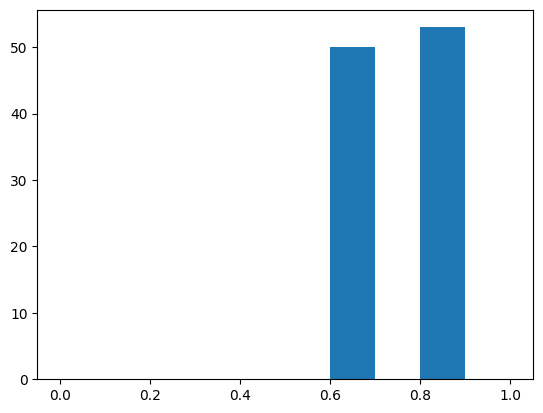

0.7557459053458627


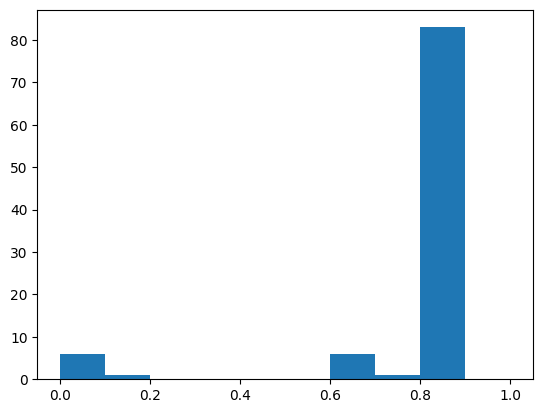

0.7591658317524453


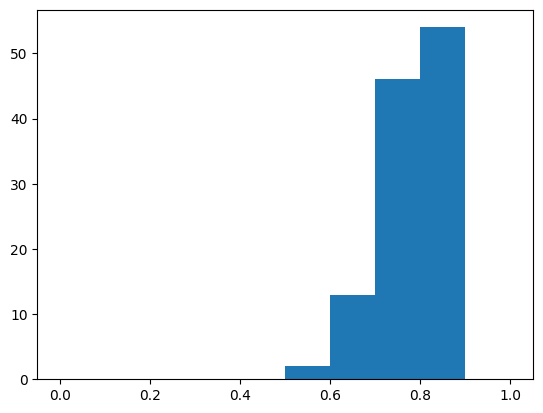

0.7507899634597838


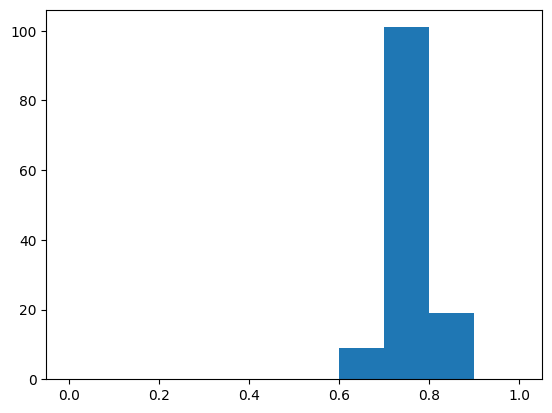

0.7986815397469502


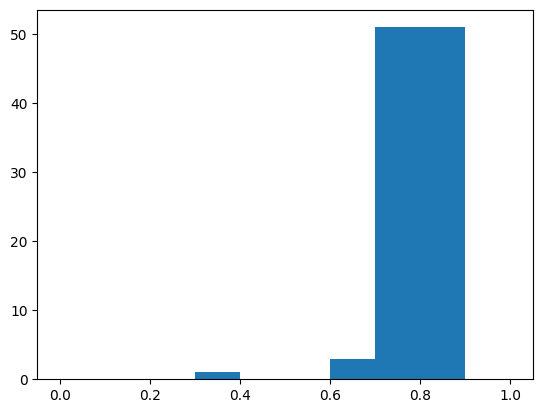

0.8239371517654692


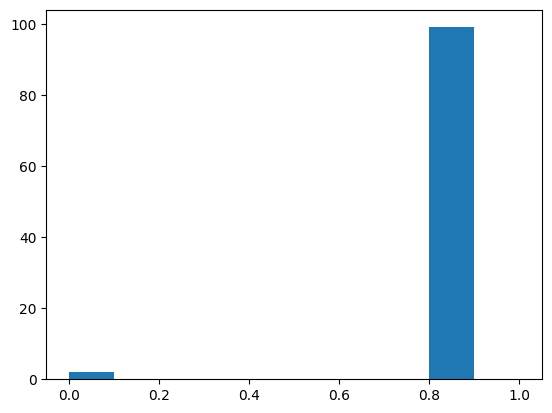

0.7629386896685678


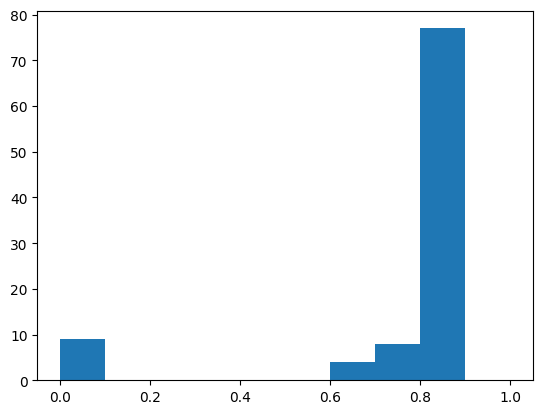

0.7674681063770323


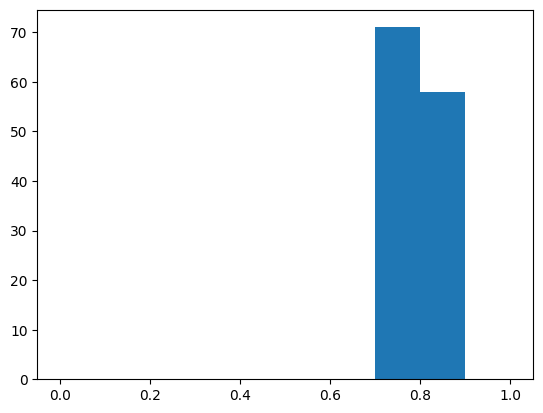

0.8752798360127669


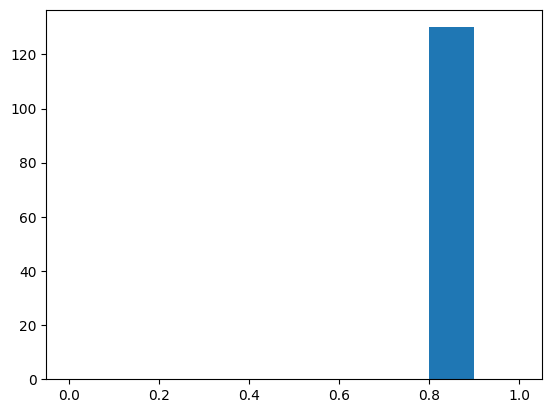

0.7599397999371669


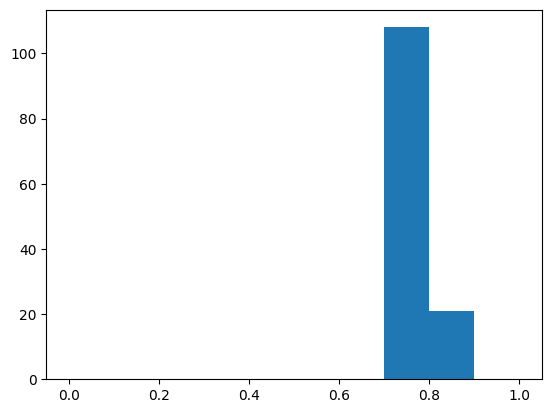

0.8002096312914708


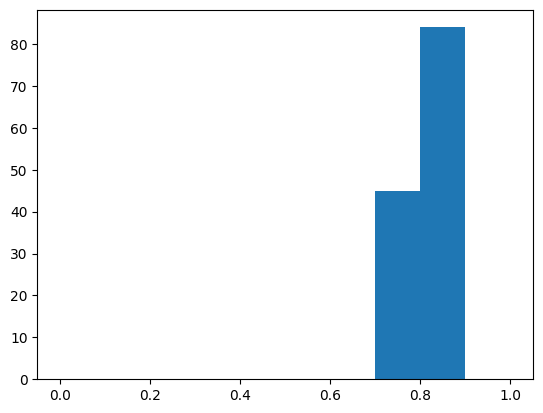

0.8009572157235904


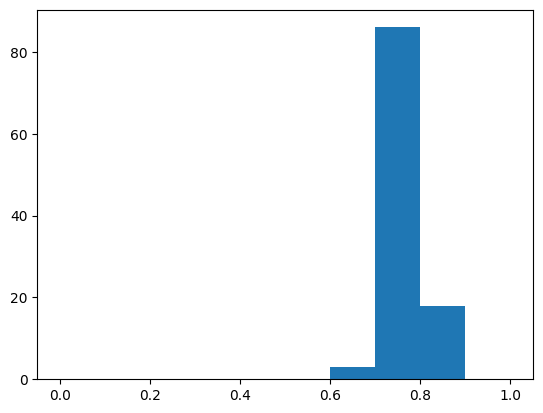

0.7846667790605176


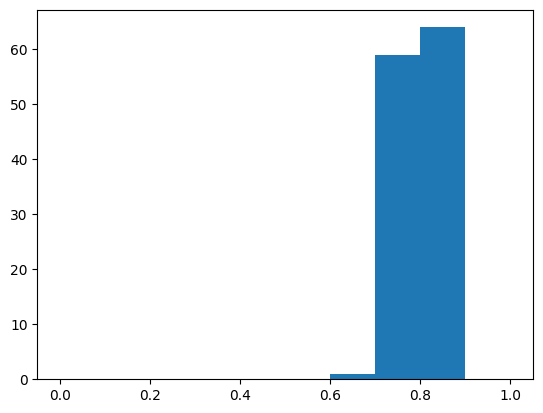

0.8331787710966065


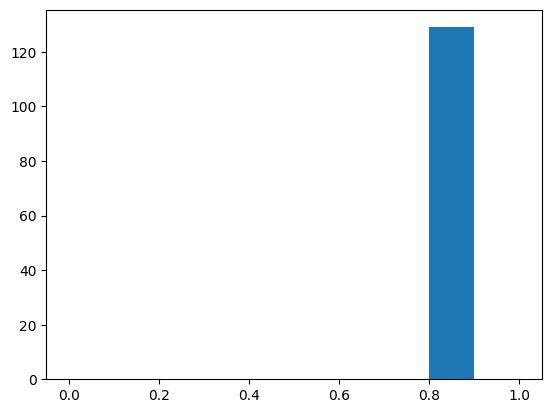

0.7578036595234828


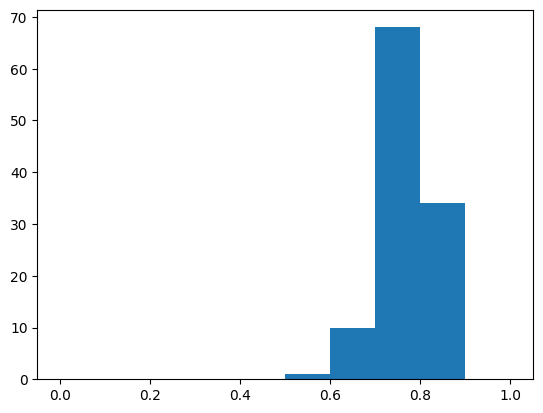

0.7899511010915625


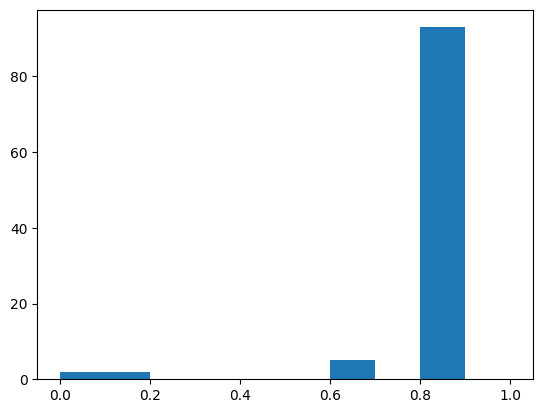

0.8007786842279656


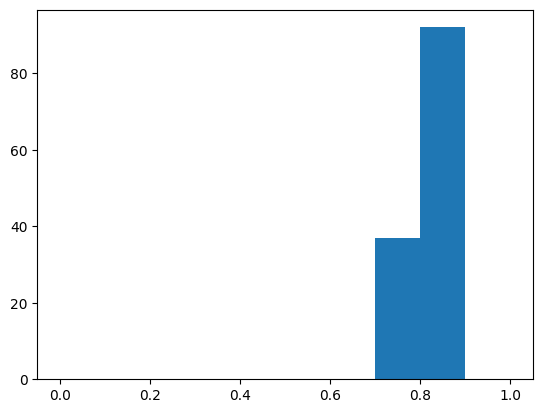

0.793169288074269


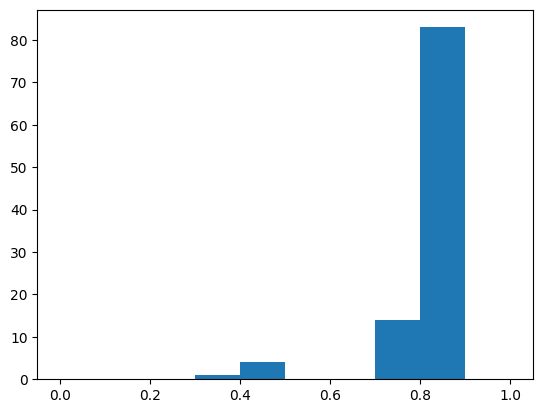

0.8089058055158924


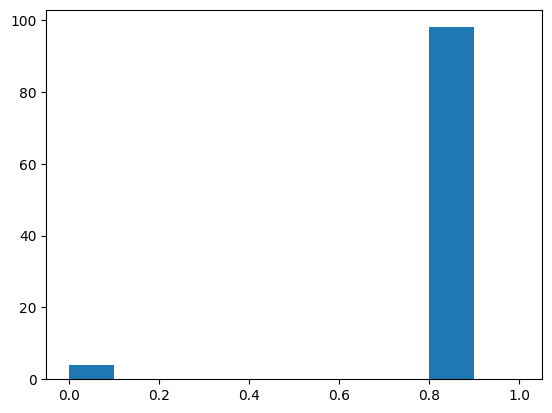

0.7713780714354167


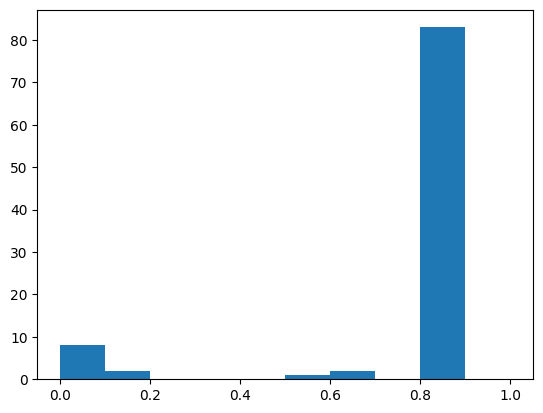

0.8021088537481642


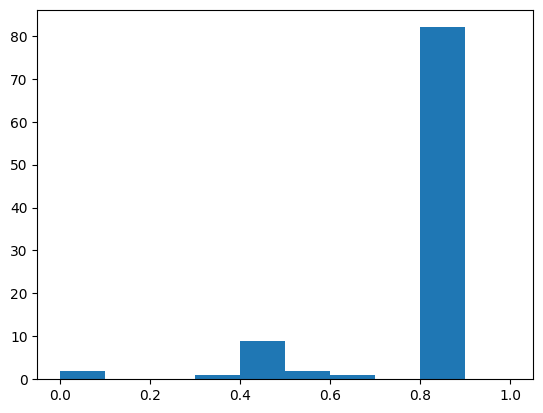

0.8033082110822694


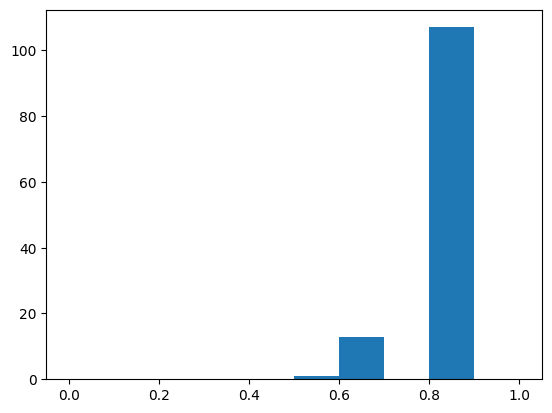

0.7516013188795609


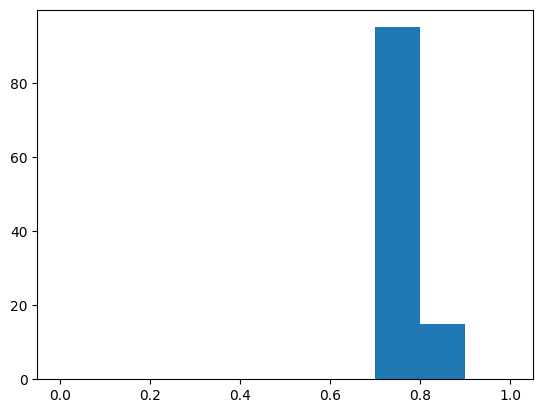

0.775009053579548


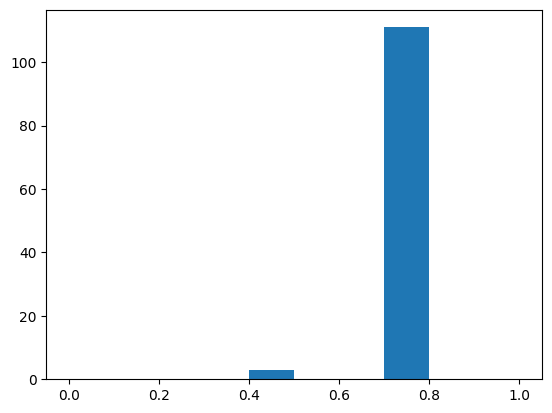

0.7505434409516757


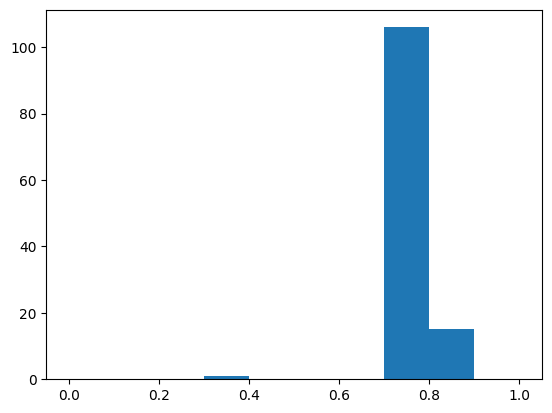

0.8023460562839064


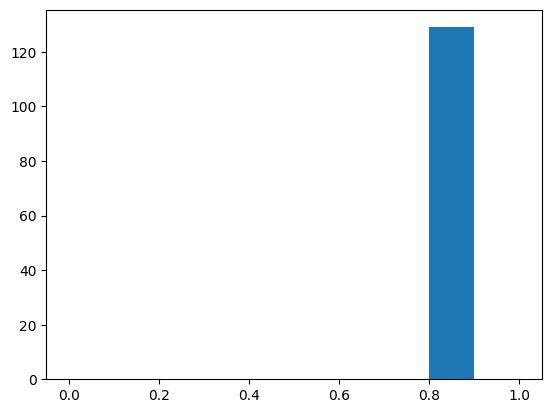

0.7898100096928445


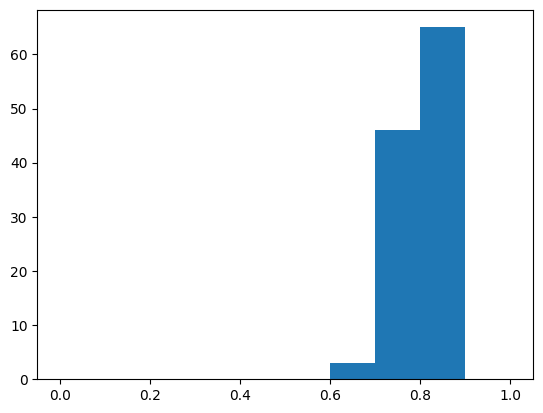

0.8368024881495986


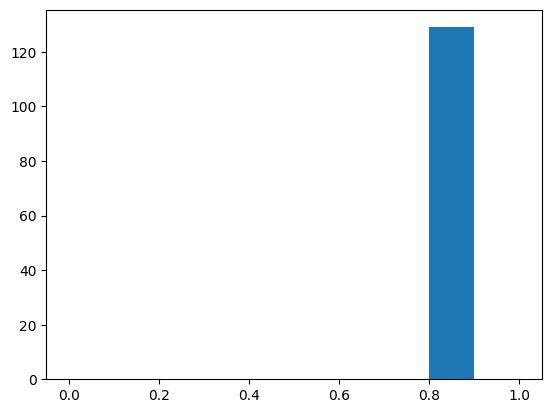

0.8150158372036246


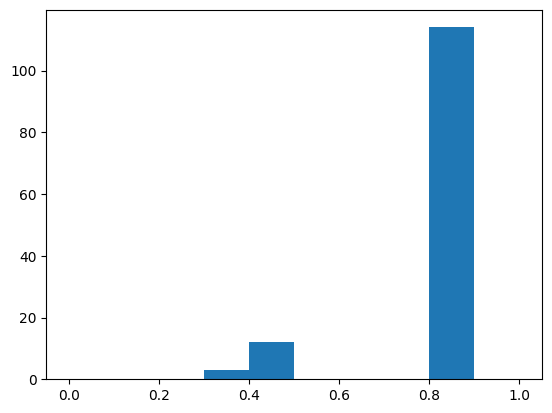

0.8863388962745666


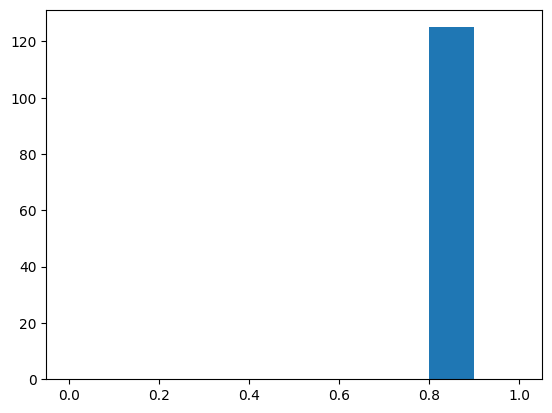

0.7743330762936519


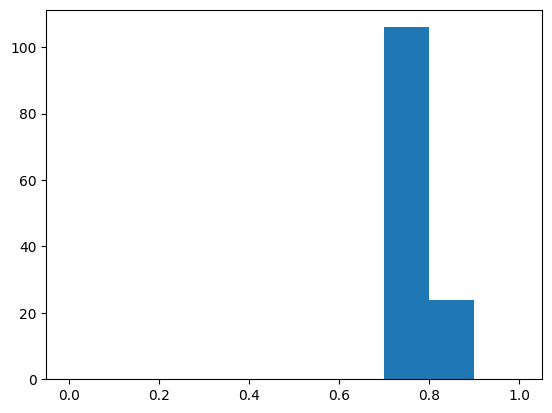

0.7874446011506594


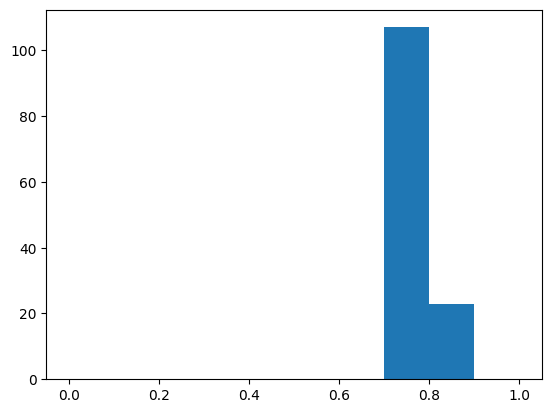

0.7506268555803817


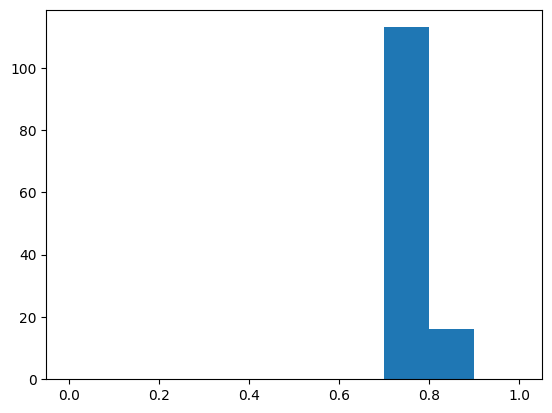

0.8288125506902145


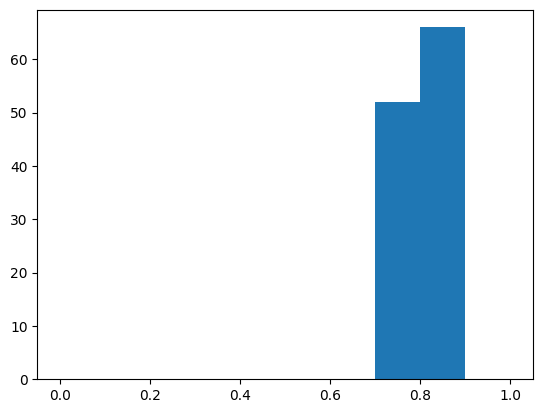

0.7806758765102357


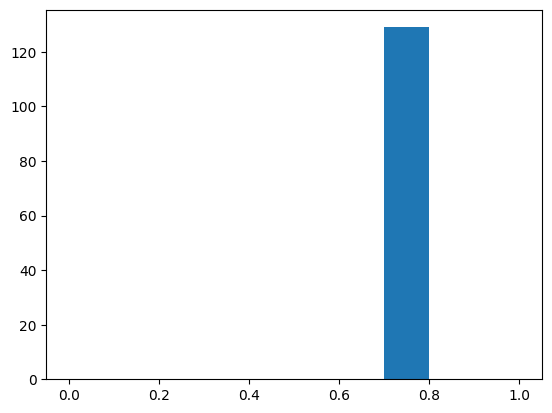

0.7735258913779444


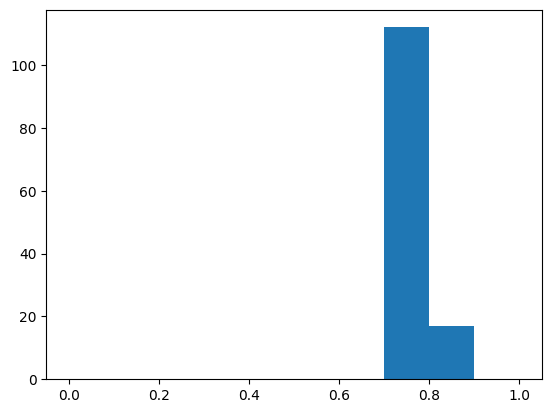

0.7847144579918114


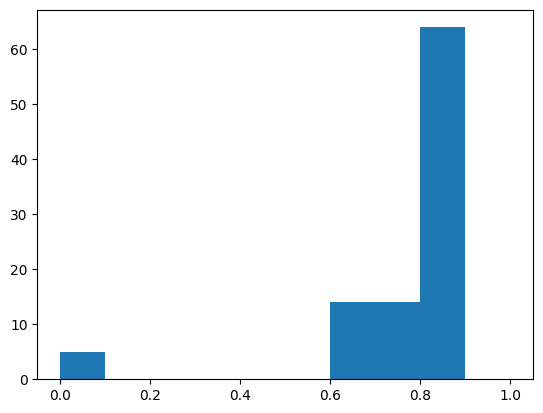

0.7667613960042292


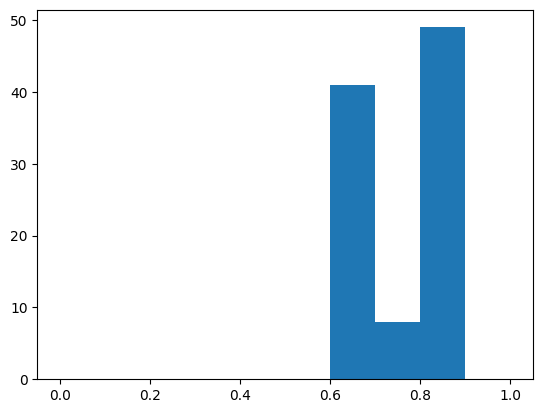

0.7635978721655332


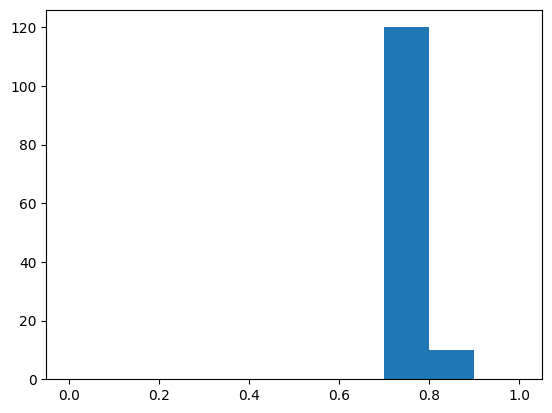

0.7750984896985136


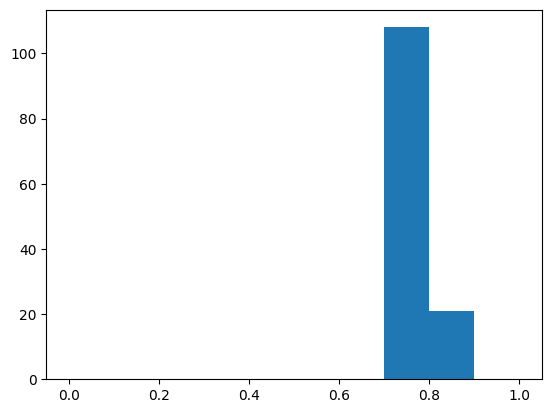

0.7529456185740094


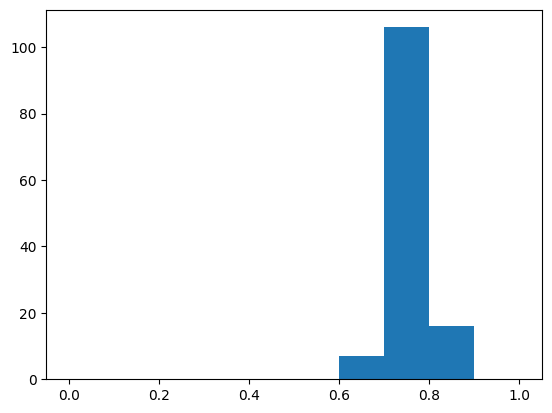

0.7674645124406544


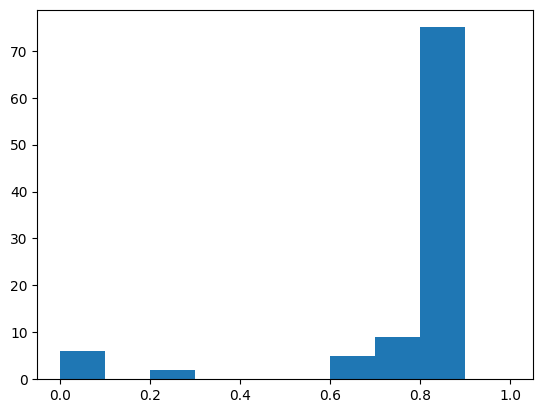

0.8009143688882044


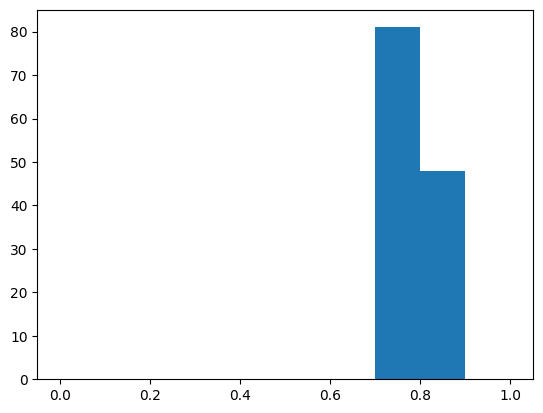

0.8007728526579965


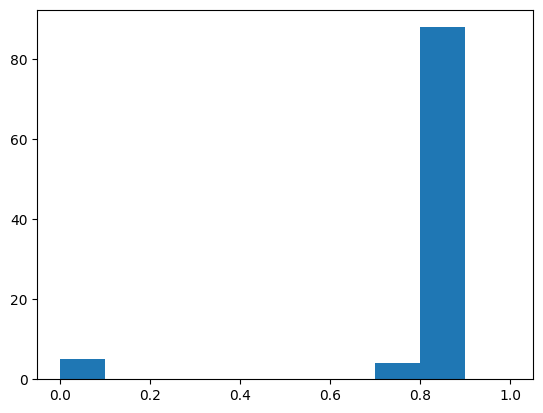

0.8111033333364384


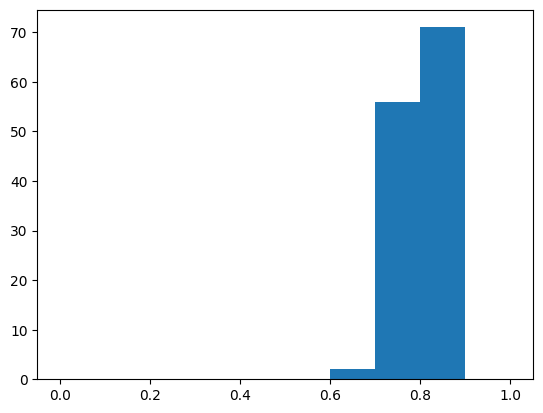

0.7591455337676135


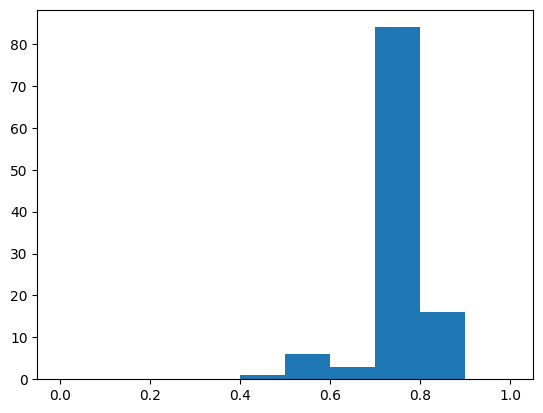

0.7777105225966527


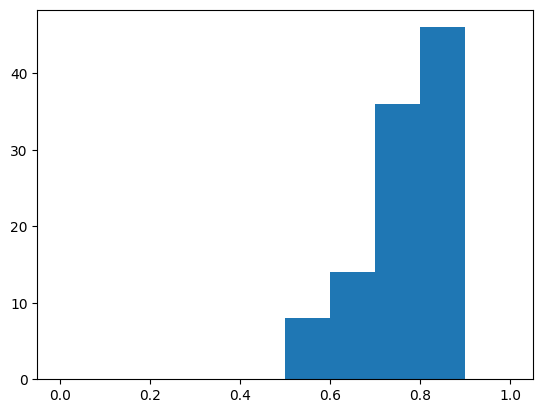

0.7702016100402951


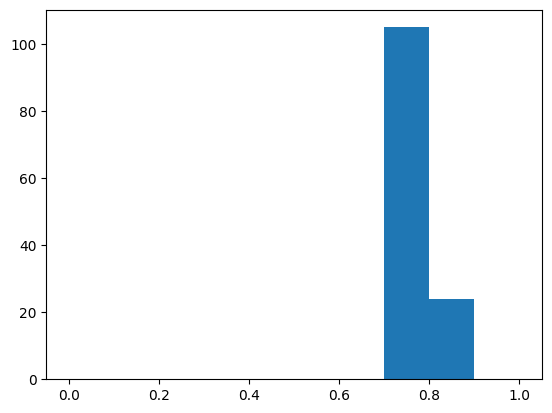

0.7869689634213081


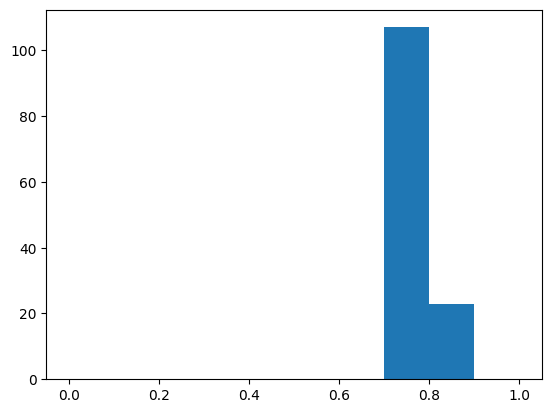

0.8765683922656747


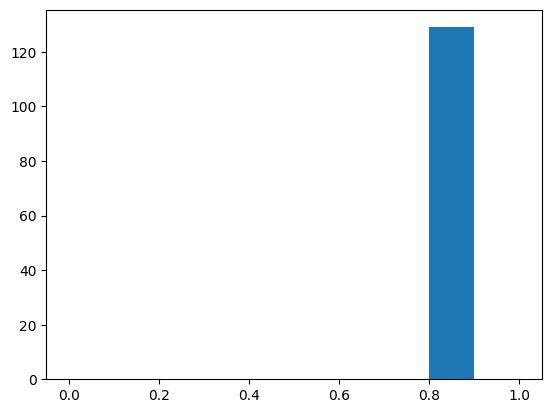

0.7570500510223841


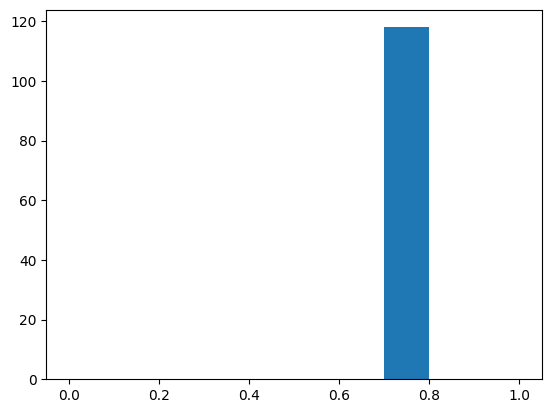

0.7714736216208514


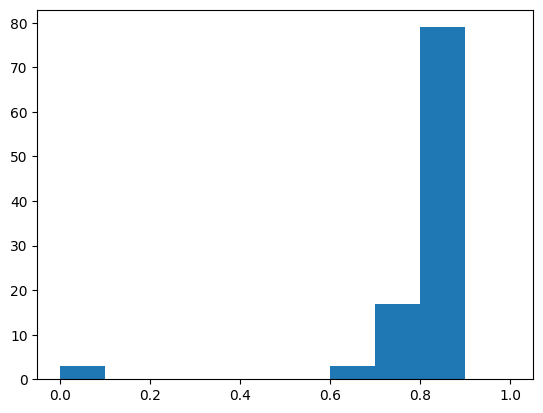

0.7969125622481692


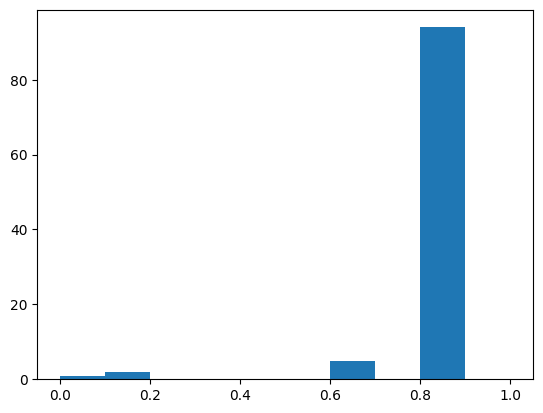

0.8009696399221325


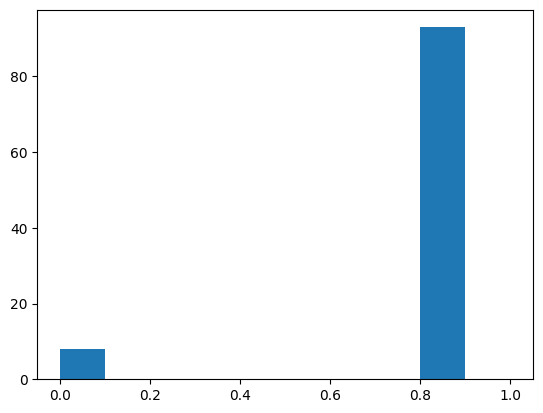

0.7625034932018251


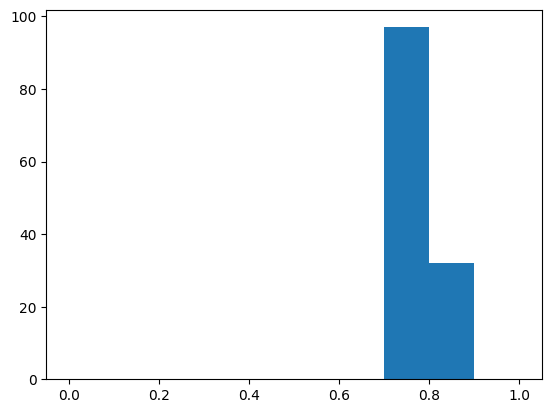

0.7756851451231701


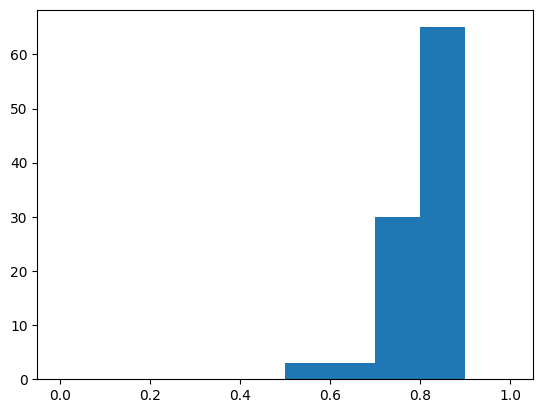

0.7655244557432426


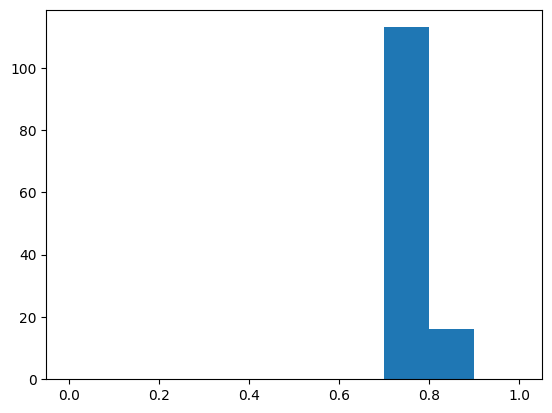

0.7810456033022899


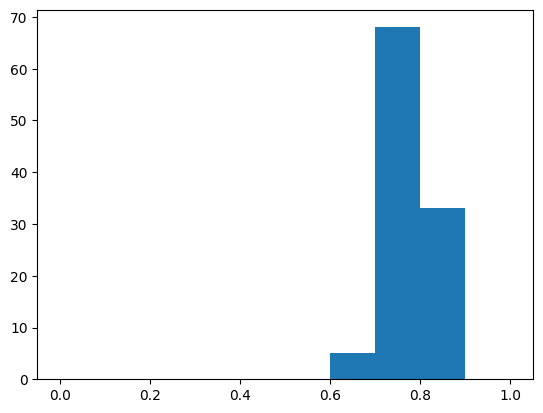

0.7502696233073084


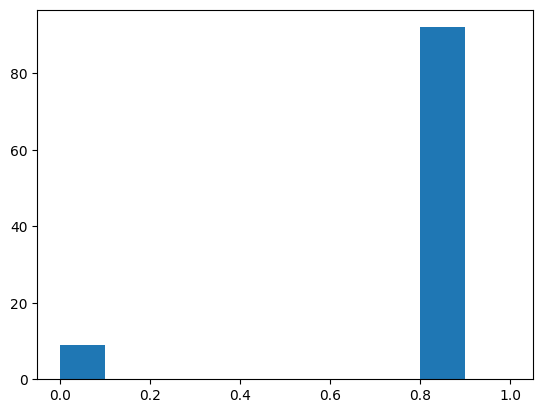

0.8792632864427197


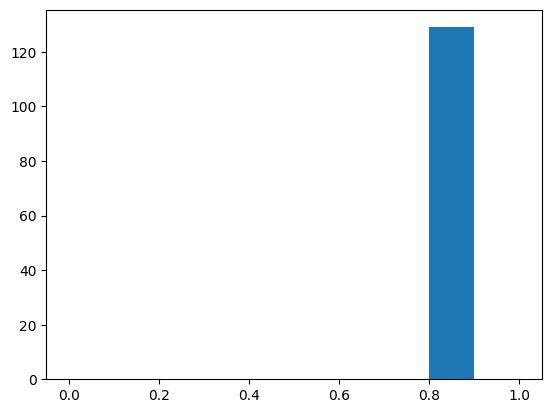

0.7753150920782771


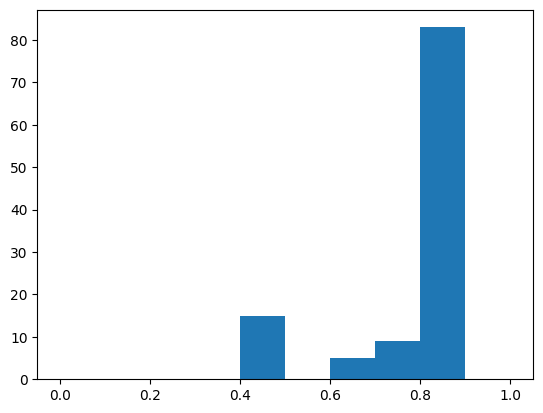

0.7985993420769428


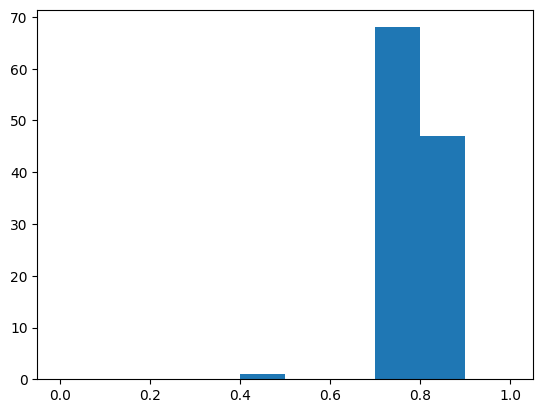

0.7509776432384816


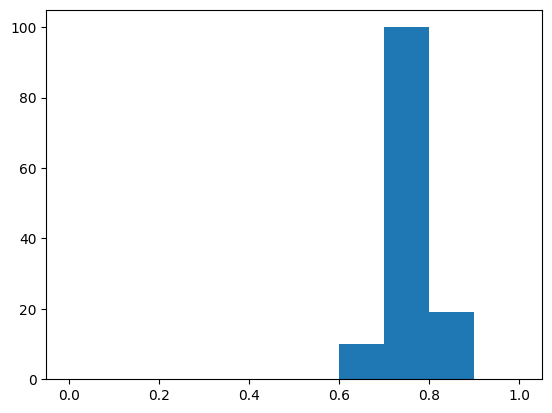

0.7647338154196155


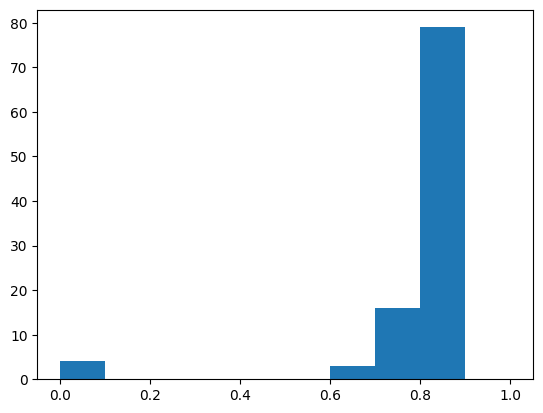

0.7556119863966516


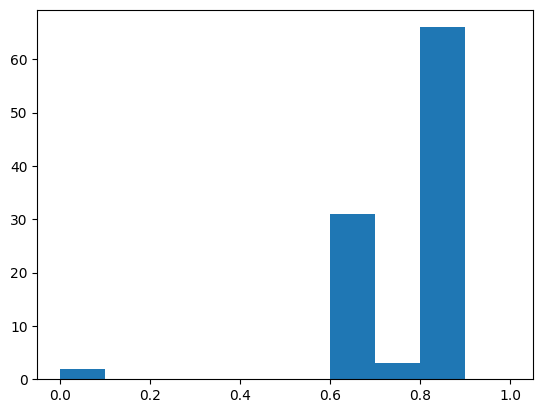

0.7882930978324062


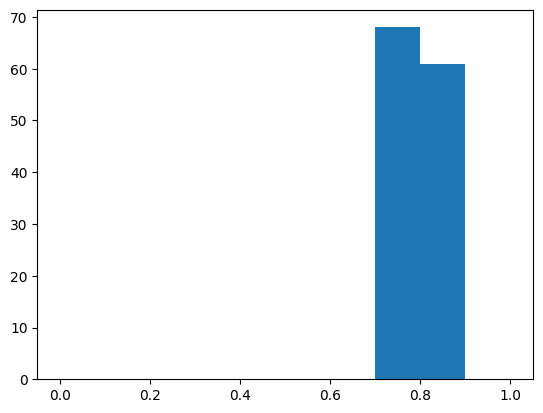

0.8811550972073577


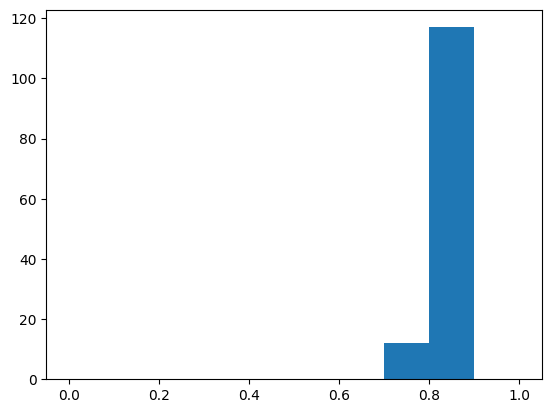

0.7520627560790138


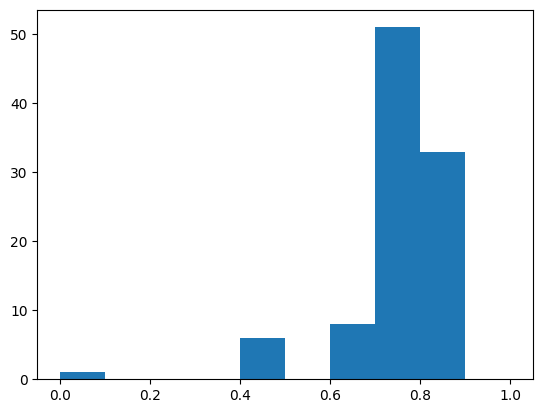

0.8452888536453247


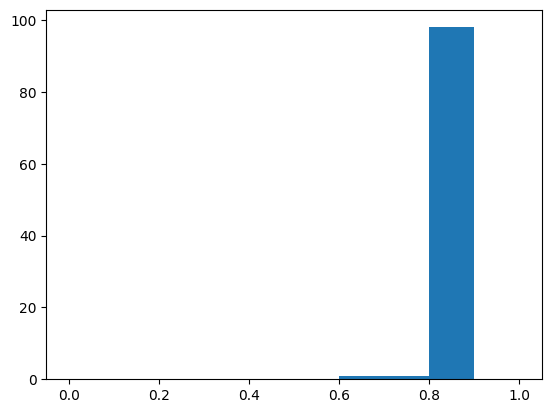

0.810396442313989


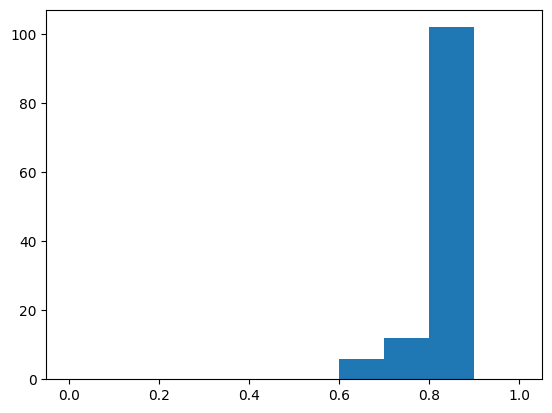

0.7511790371635585


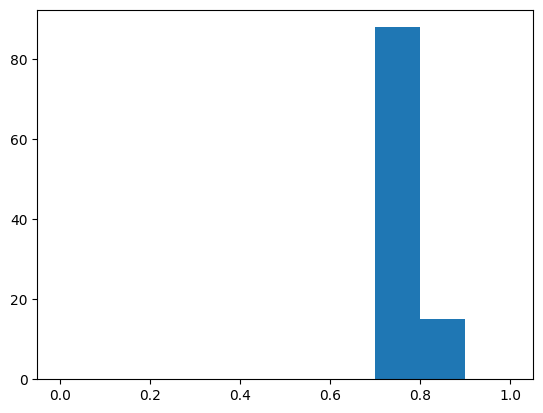

0.7691731836444647


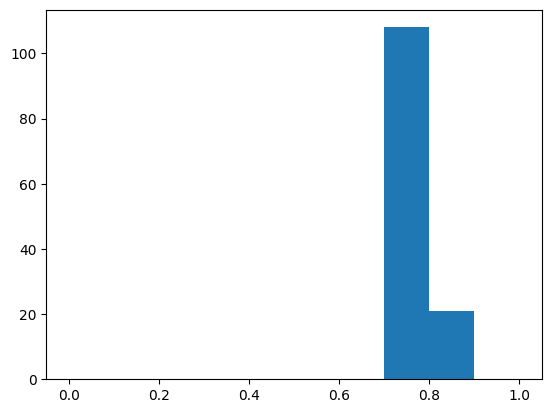

0.7716921931221372


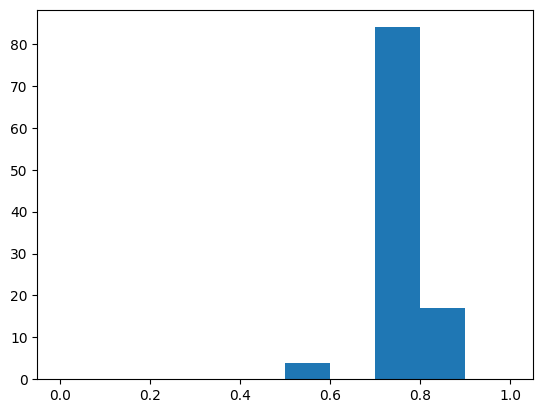

0.8099931374538777


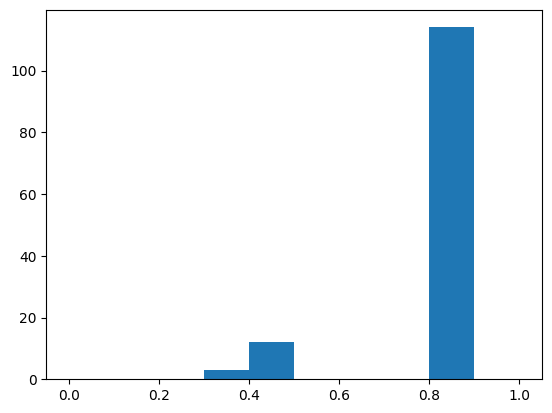

0.8678048220715782


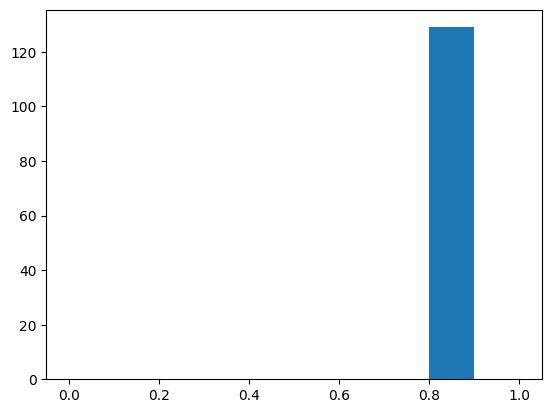

0.7868183525709006


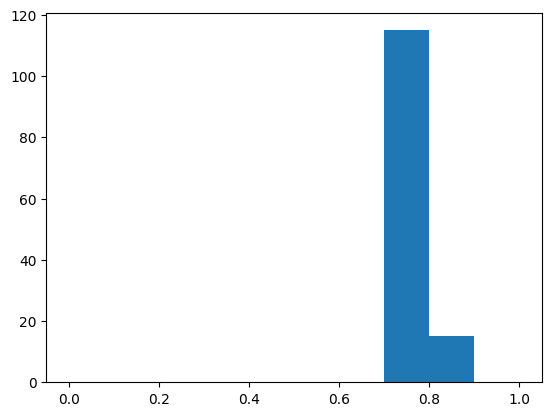

0.7505674112973542


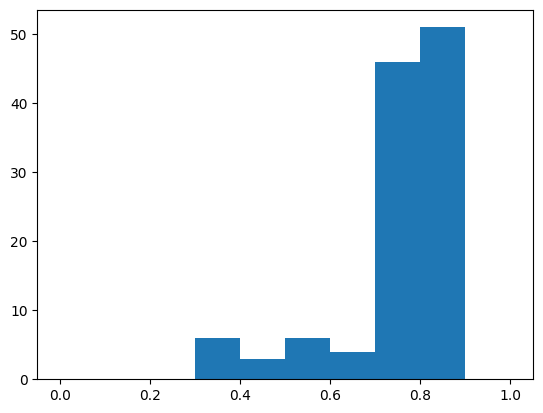

0.7859851656591191


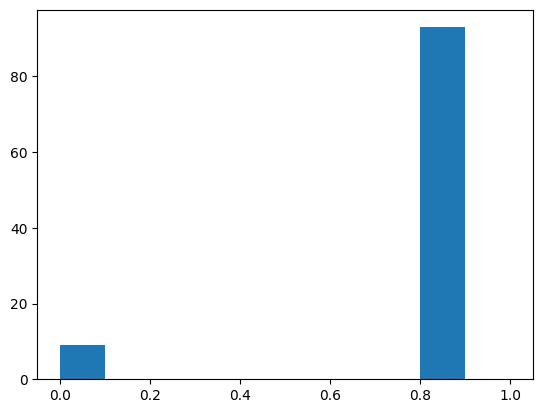

0.8519920180010241


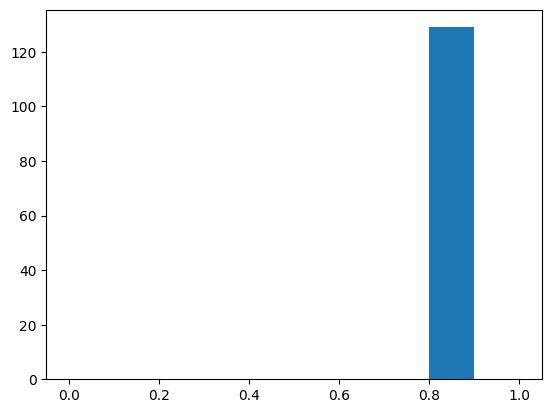

0.7629519333349211


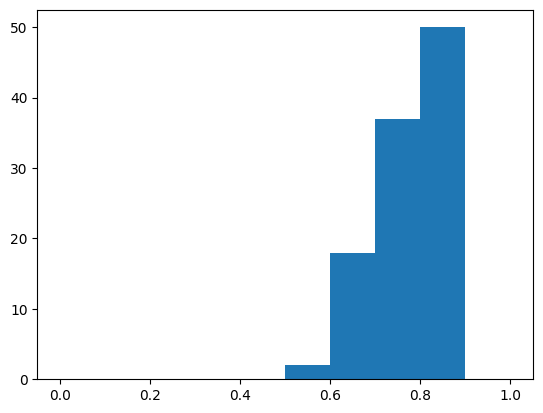

0.8782652510229008


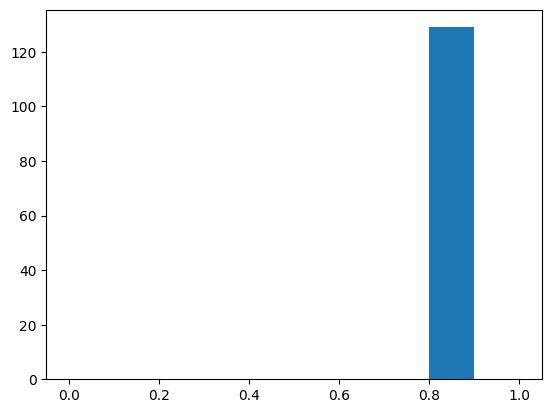

0.7802942884984867


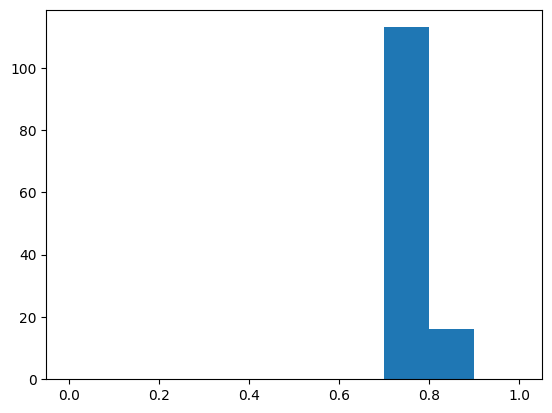

0.8146809038862718


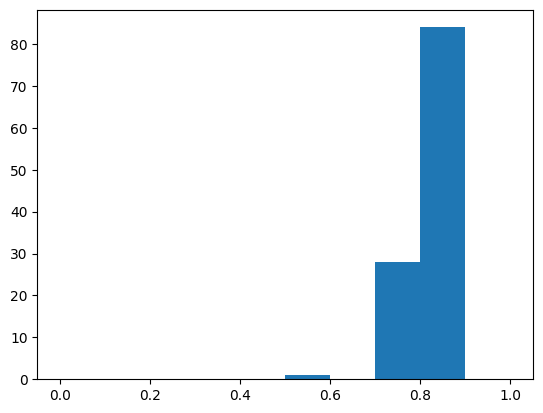

0.8348624188770619


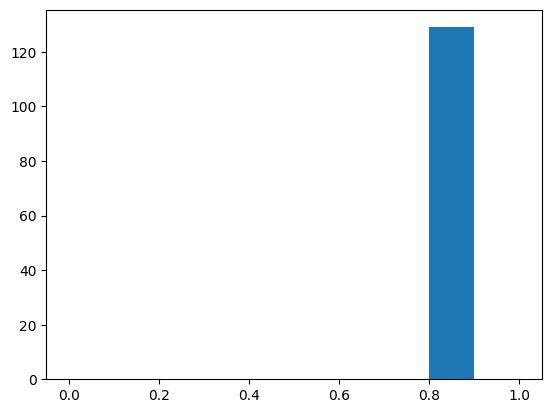

0.7898298160848665


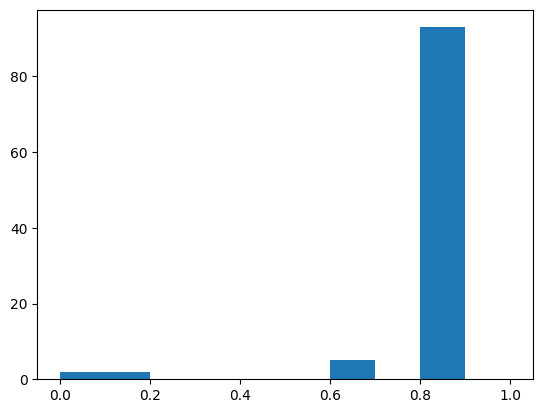

0.875


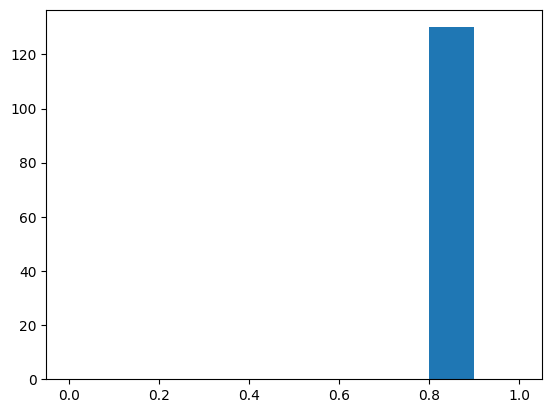

0.7828516816908075


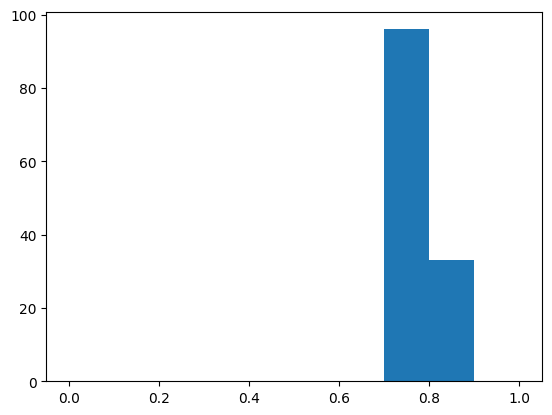

0.7502736510469181


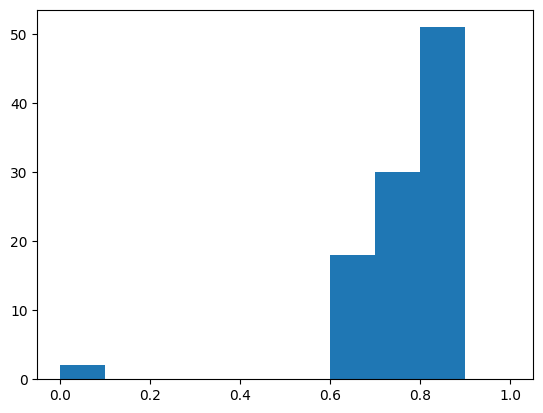

0.7899476580467879


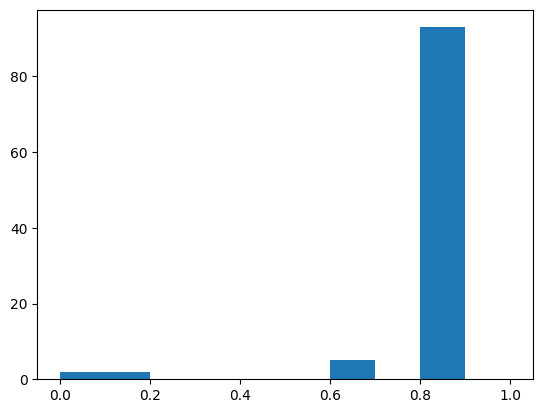

0.8117077052593231


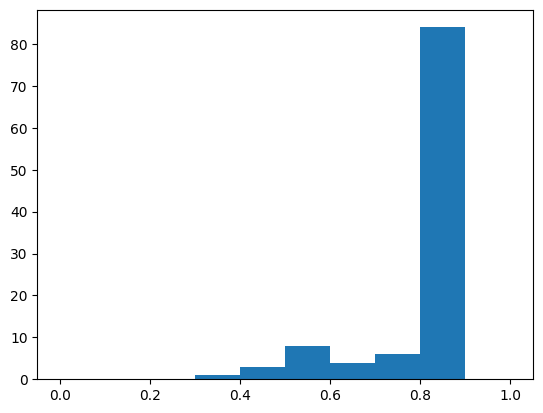

0.7503249136344442


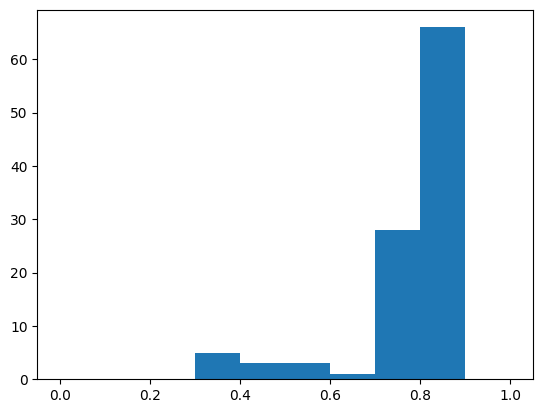

0.7841264172457159


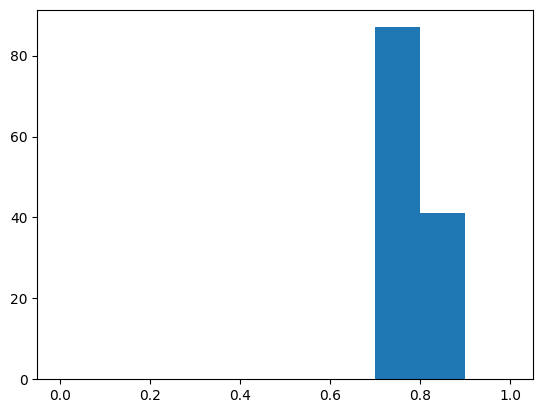

0.8014578120066569


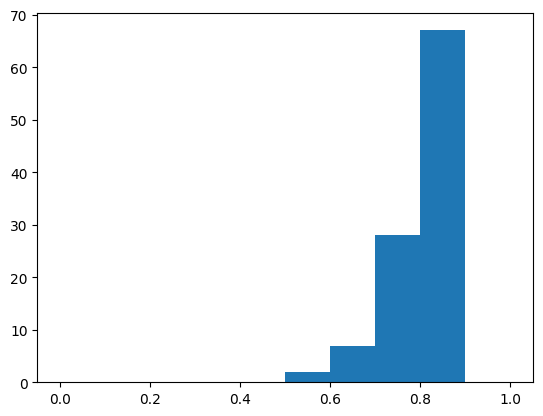

0.7549949145866829


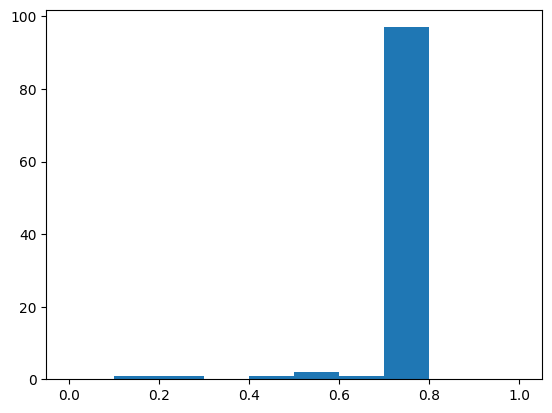

0.7887359300226557


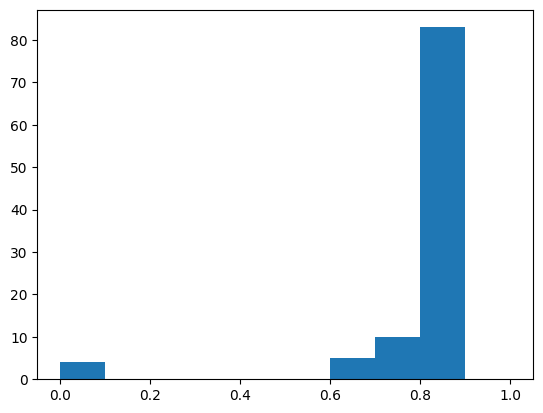

0.8731210002532372


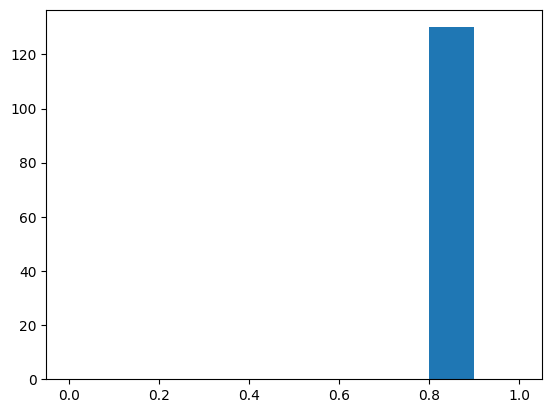

0.780317771615404


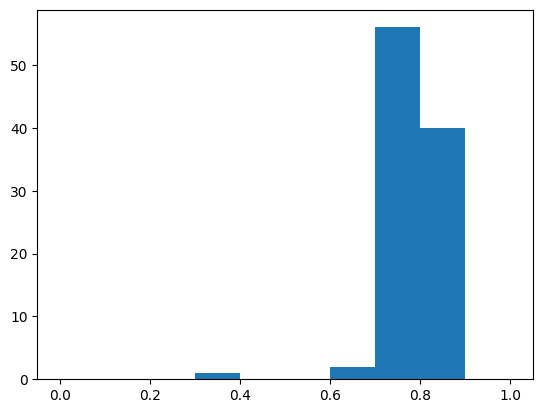

0.7970612768595126


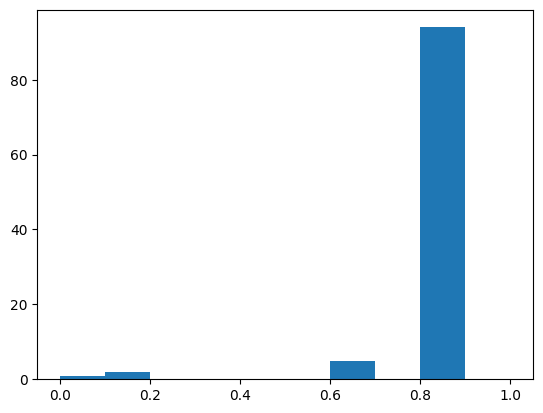

0.7959820248340208


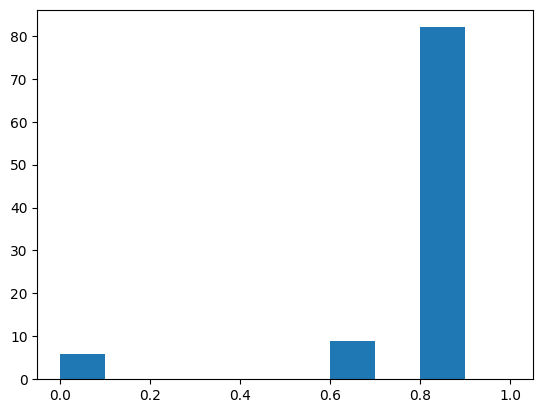

0.7973941490631695


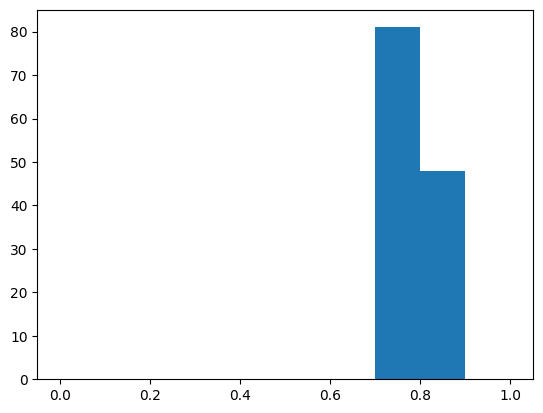

0.7535664513129596


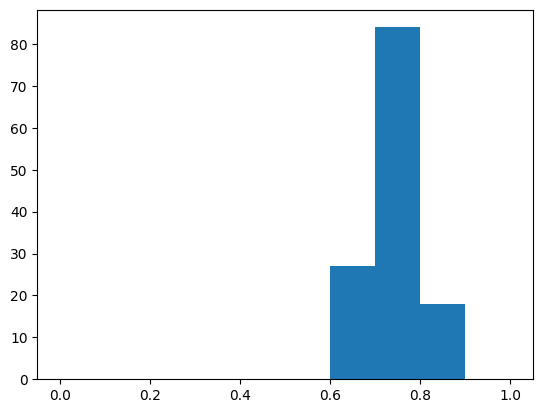

0.7563926050829333


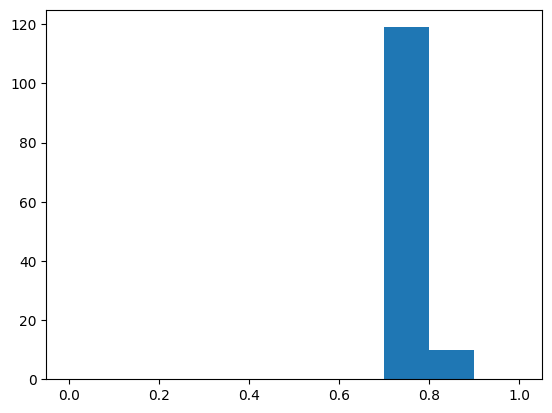

0.7969501999517282


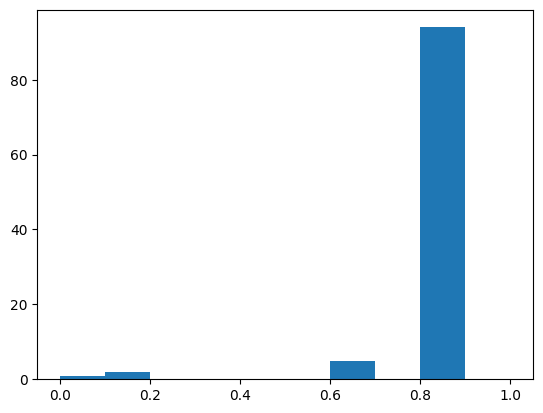

0.8572488115384028


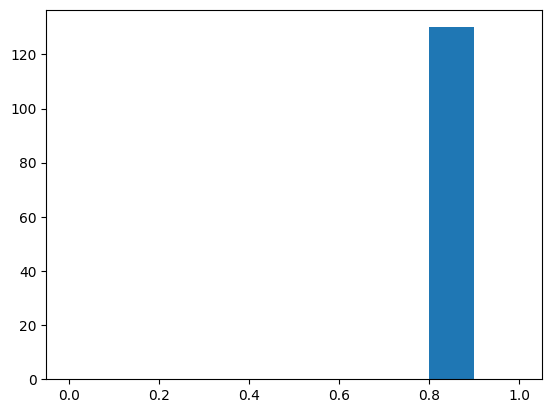

0.7911348195039025


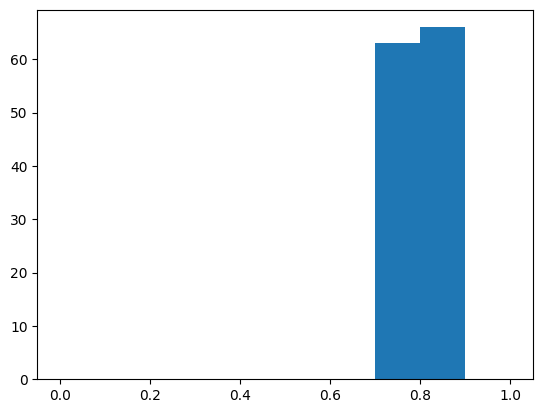

0.8663555697877278


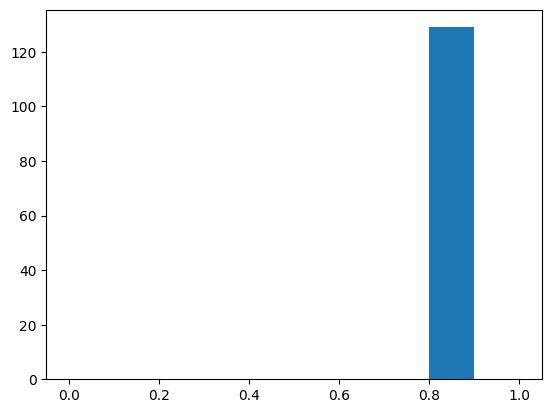

0.8114897443466828


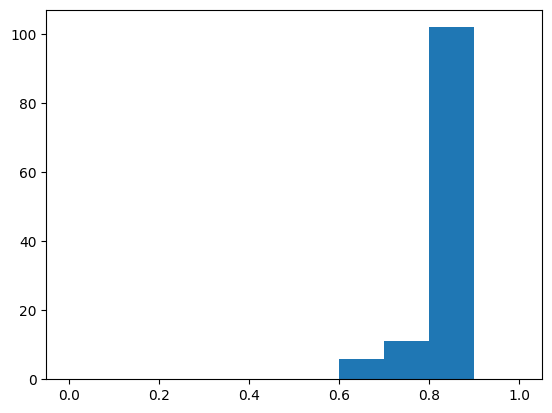

0.8398213839346125


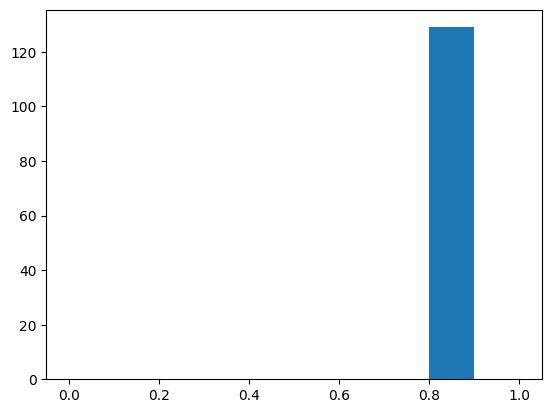

0.7711280852325203


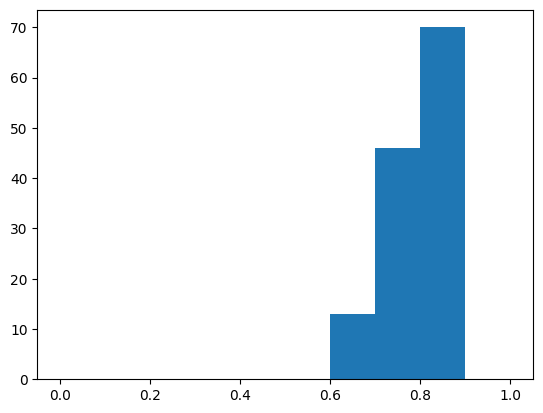

0.8761796406073163


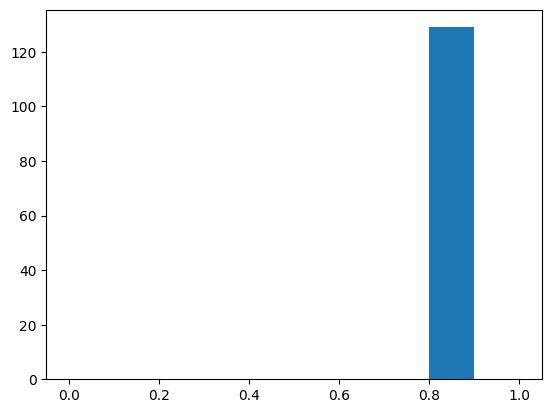

In [368]:

from matplotlib import pyplot as plt
from tqdm import tqdm


def plot_distribution_per_inchikey_within_average_score_range(selected_pairs, minimum=0.8, maximum=1.1):
    inchikey_scores = {}
    for inchikey_1, inchikey_2, score in tqdm(selected_pairs):
        if inchikey_1 in inchikey_scores:
            inchikey_scores[inchikey_1].append(score)
        else:
            inchikey_scores[inchikey_1] = []
        if inchikey_2 in inchikey_scores:
            inchikey_scores[inchikey_2].append(score)
        else:
            inchikey_scores[inchikey_2] = []
    shuffled_inchikeys = list(inchikey_scores.keys())
    random.shuffle(shuffled_inchikeys)
    for inchikey in shuffled_inchikeys:
        scores = inchikey_scores[inchikey]
        if  maximum > sum(scores)/len(scores) > minimum:
            print(sum(scores)/len(scores))
            plt.hist(scores, bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9,1.001])
            plt.show()
plot_distribution_per_inchikey_within_average_score_range(pair_generator_average_sampling[100].selected_inchikey_pairs, minimum=0.75, maximum=1.1)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1762300/1762300 [00:01<00:00, 1083454.91it/s]


0.7235964000687118


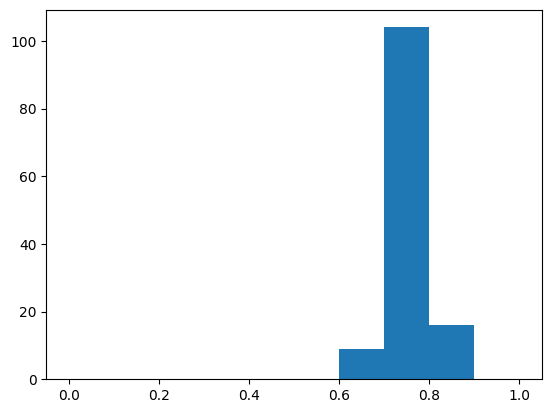

0.875


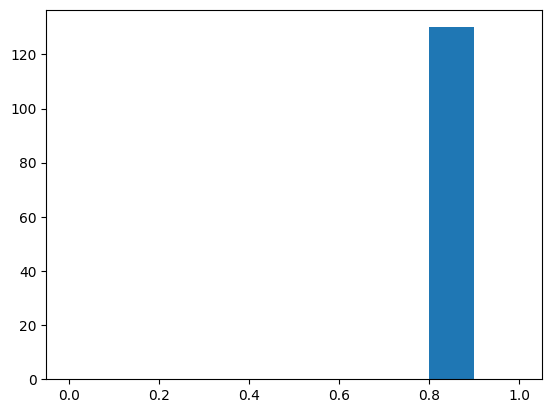

0.6650794721389002


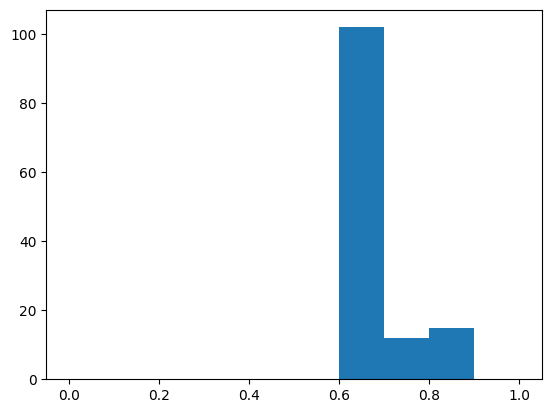

0.7563926050829333


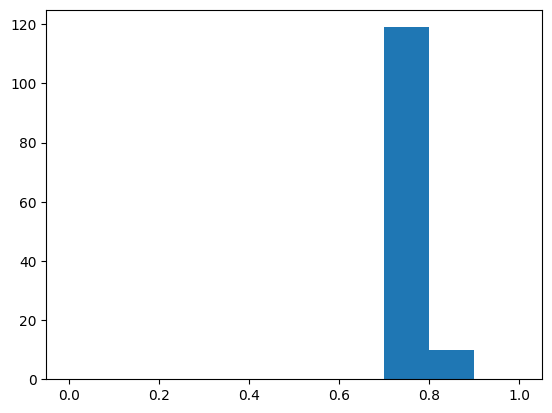

0.6832971150435291


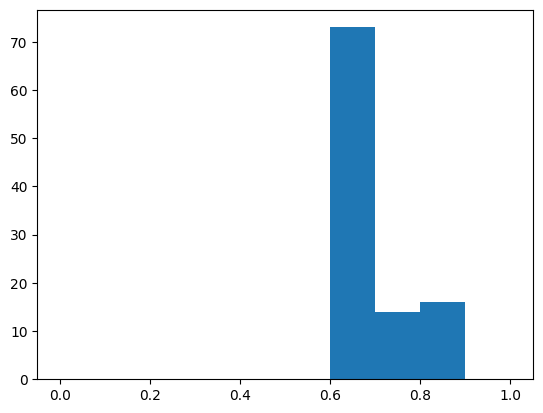

0.7395419663237047


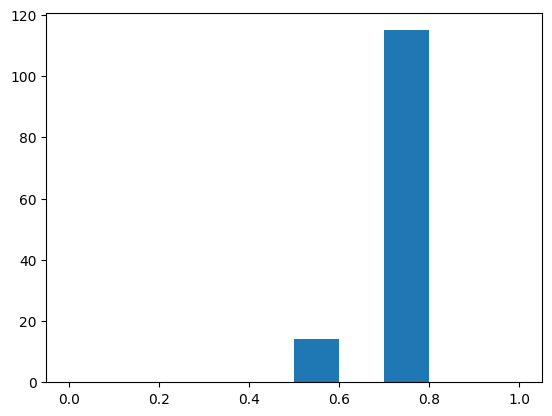

0.7535664513129596


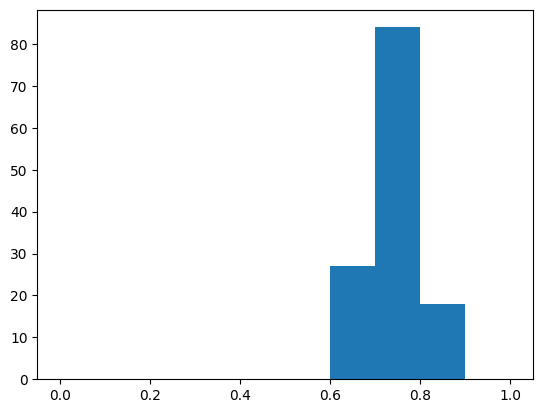

0.6615878606951514


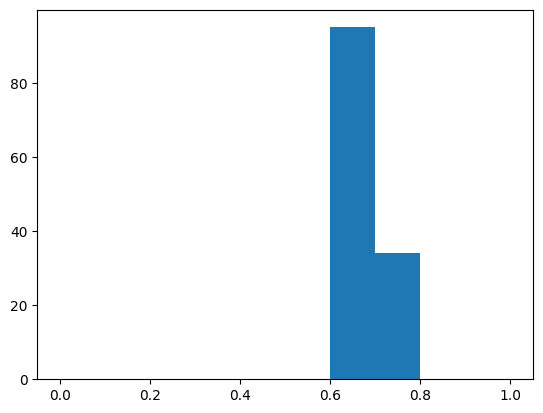

0.6928422098358472


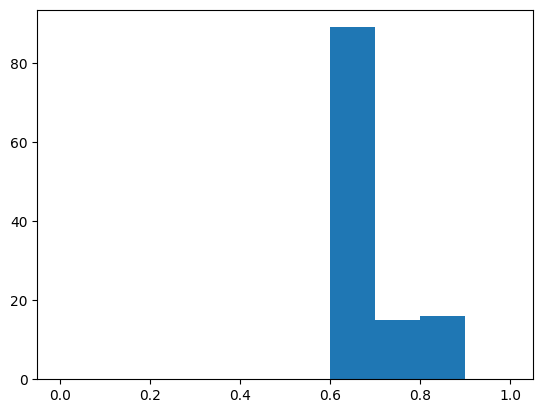

0.7735258913779444


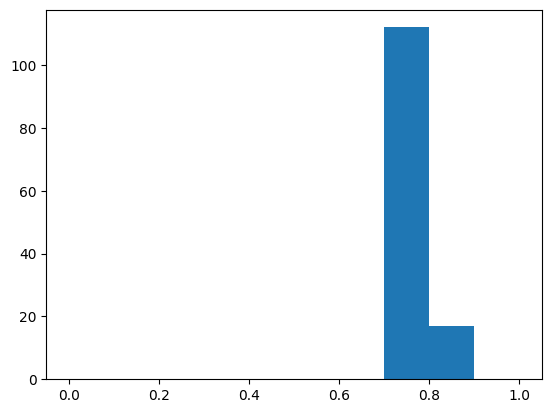

0.6781894315120786


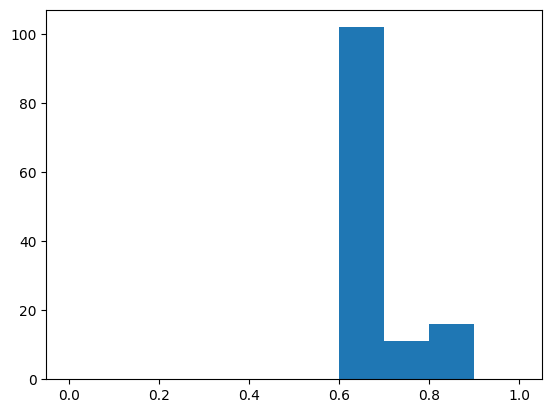

0.7268584084141162


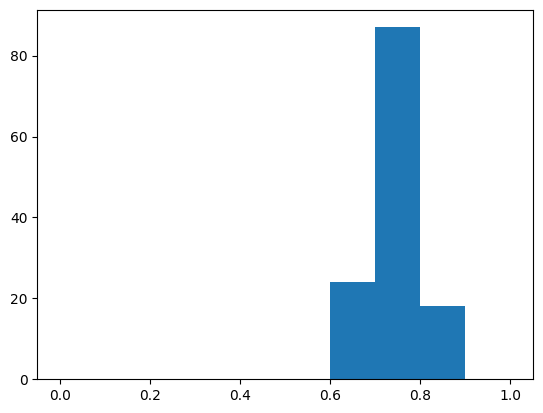

0.7702721639197002


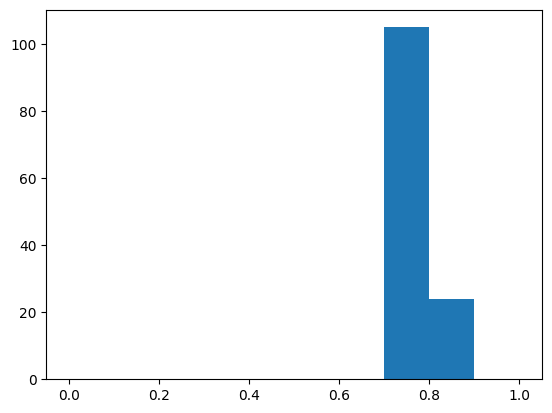

0.7750984896985136


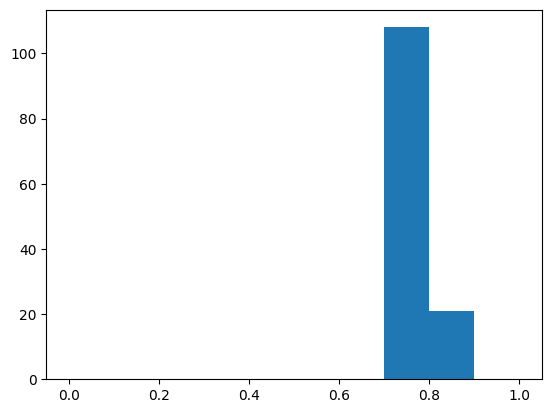

0.8761796406073163


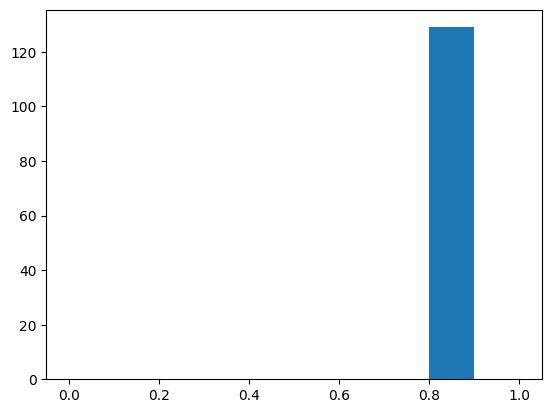

0.7103275176166564


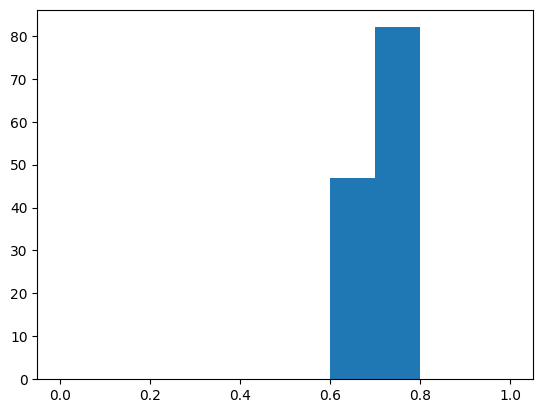

0.7882930978324062


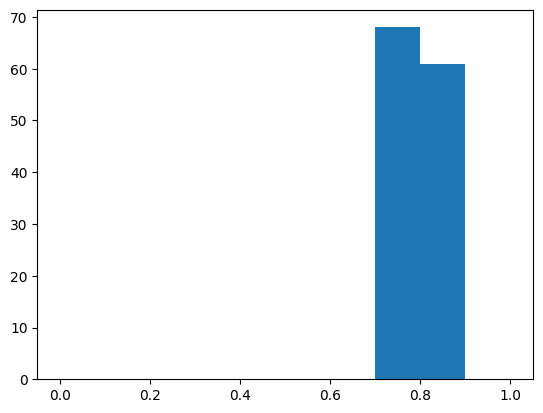

0.7069271802902222


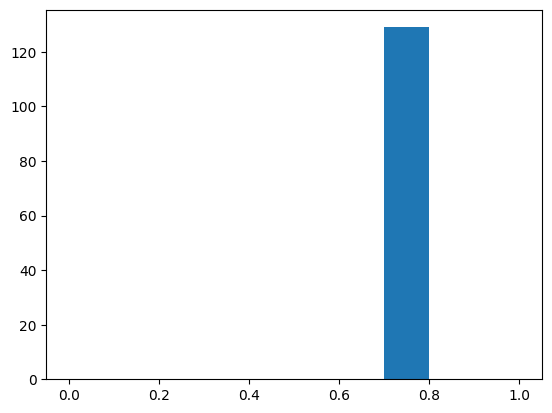

0.5753434000089187


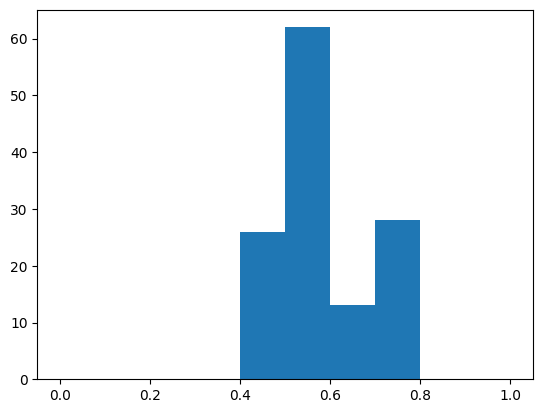

0.7089506172216855


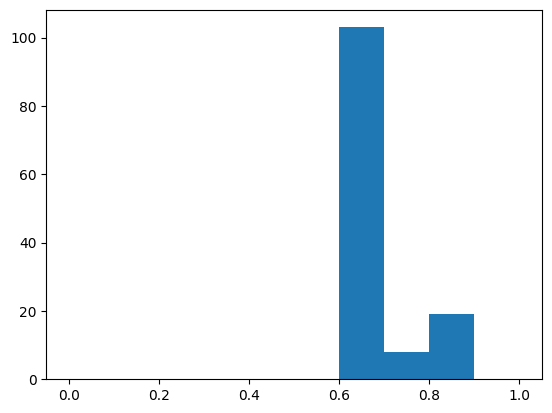

0.7802942884984867


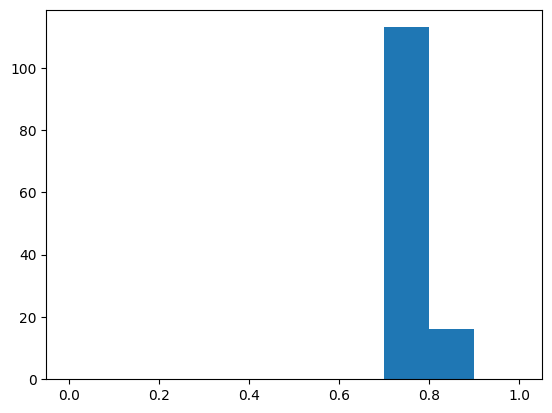

0.6978005720573721


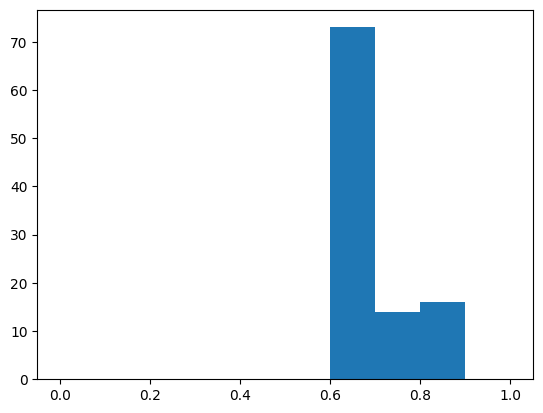

0.7691731836444647


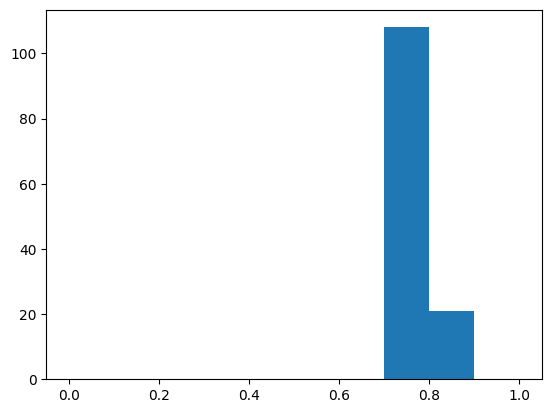

0.6955219060182571


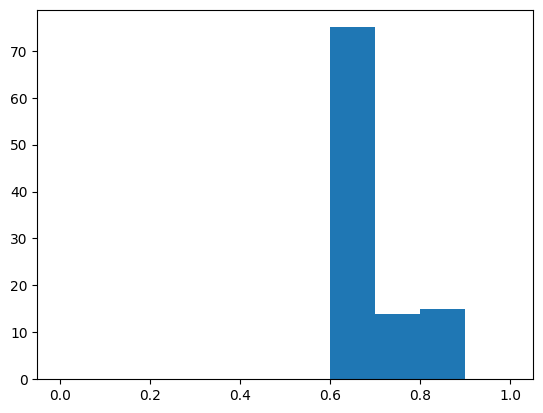

0.695385070341938


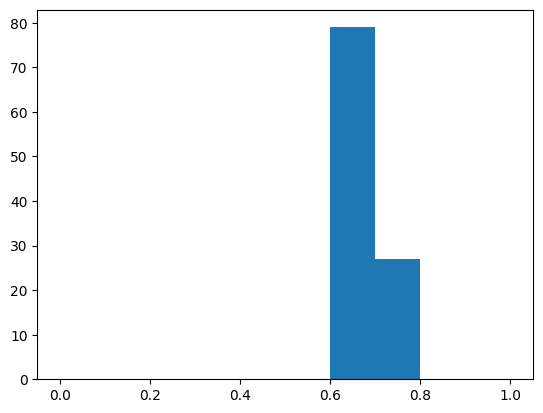

0.8572488115384028


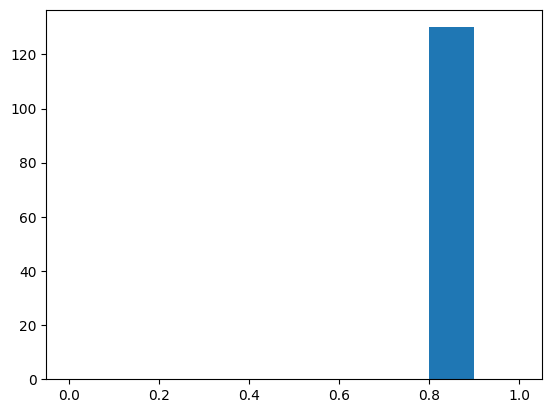

0.7430930051717672


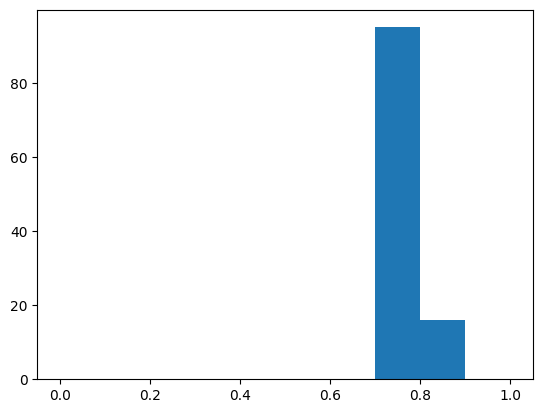

0.7131782876428707


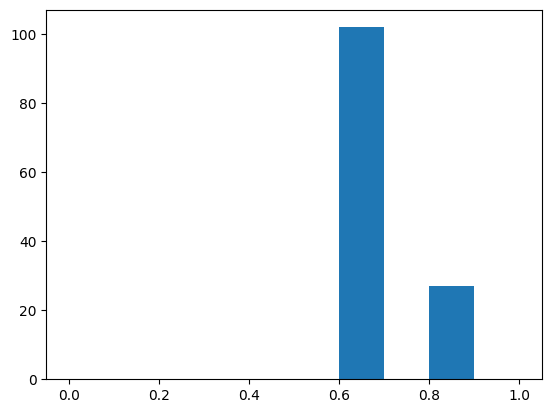

0.7529456185740094


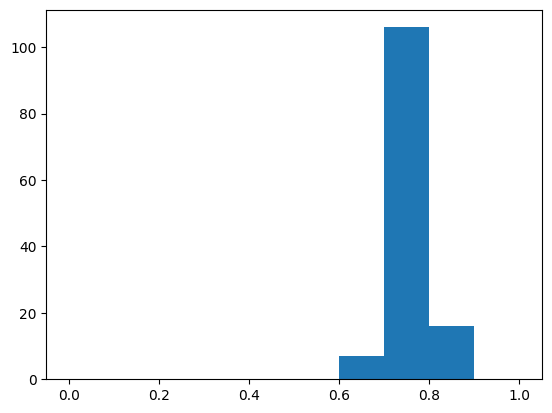

0.7129976543096396


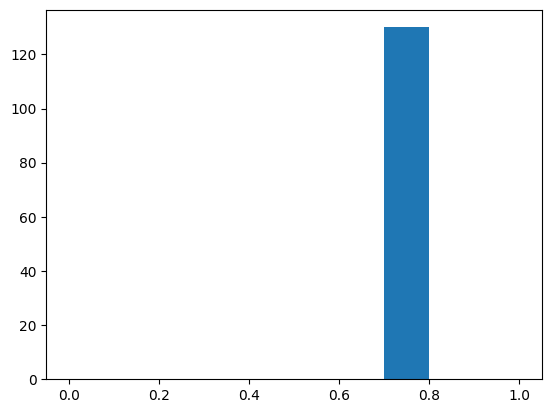

0.7434159474329906


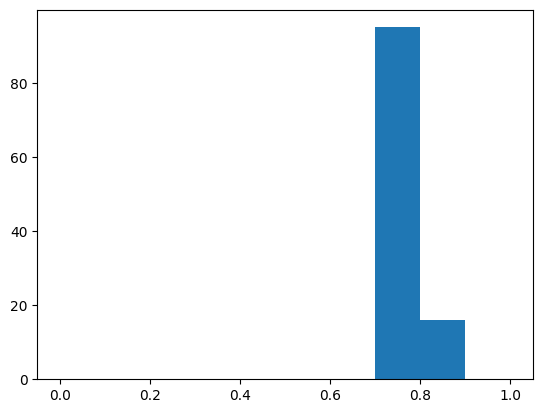

0.6961404417468383


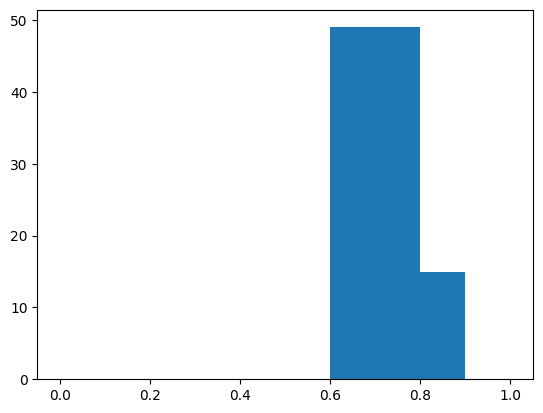

0.7511790371635585


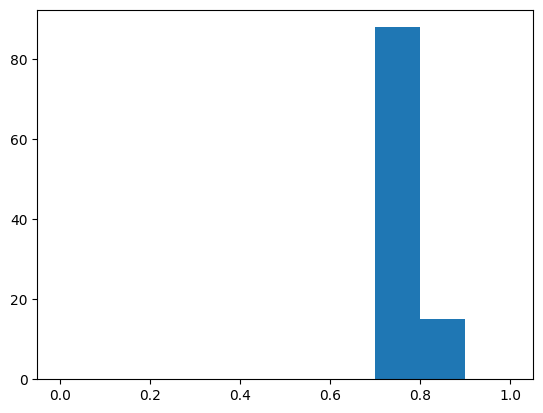

0.6681880641353223


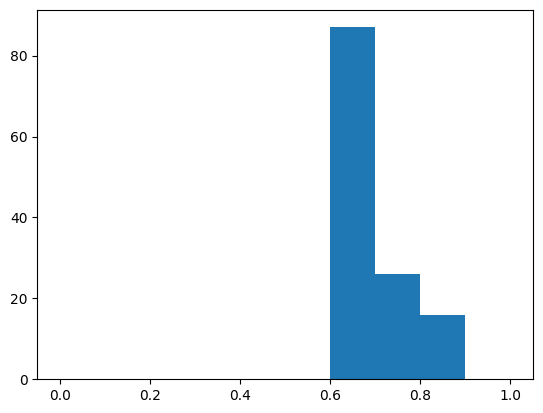

0.6947856397591821


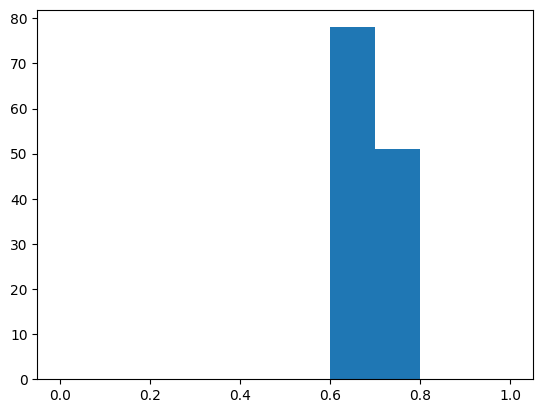

0.6138912276325063


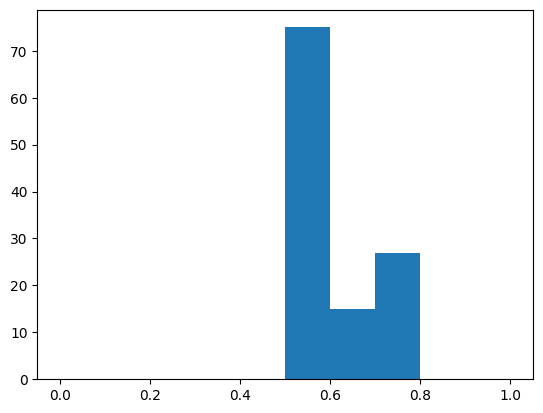

0.7220658147057821


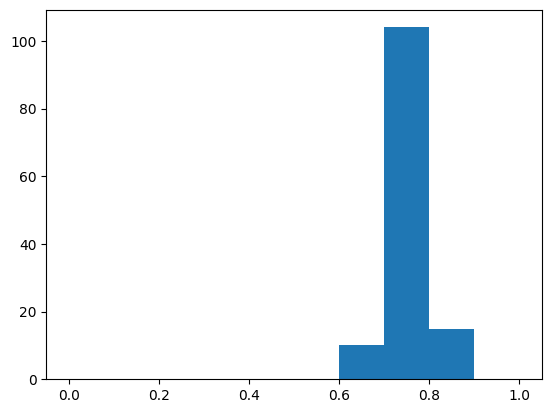

0.6822189129600229


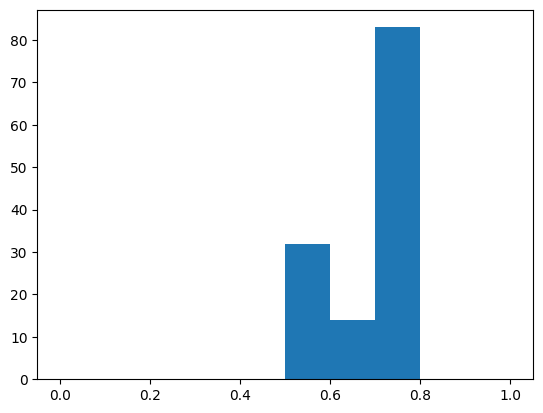

0.6868198675702709


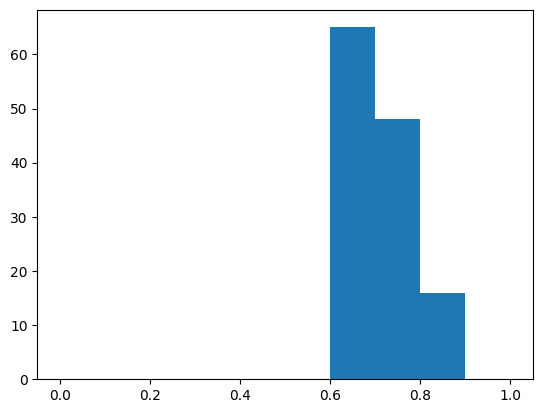

0.7921640024735377


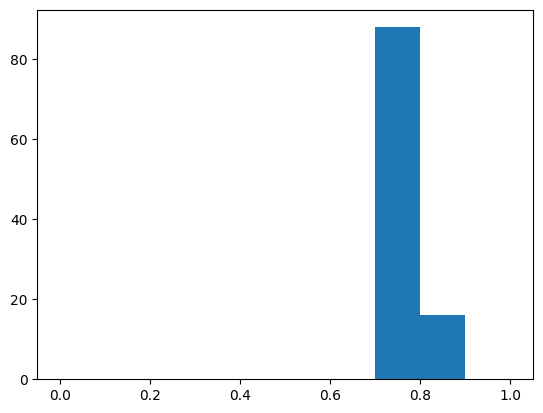

0.8288125506902145


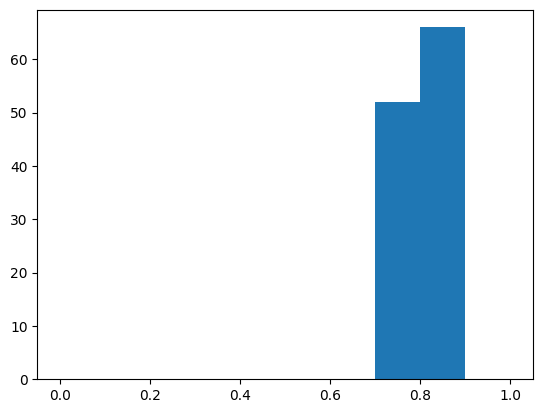

0.8678048220715782


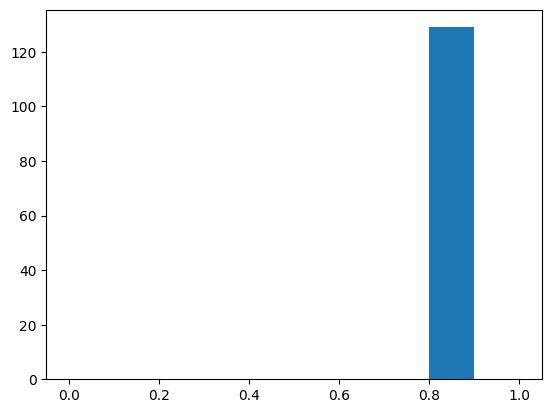

0.6862631440162659


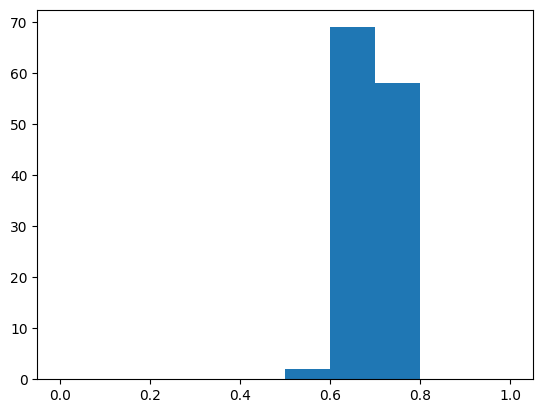

0.7333308538565269


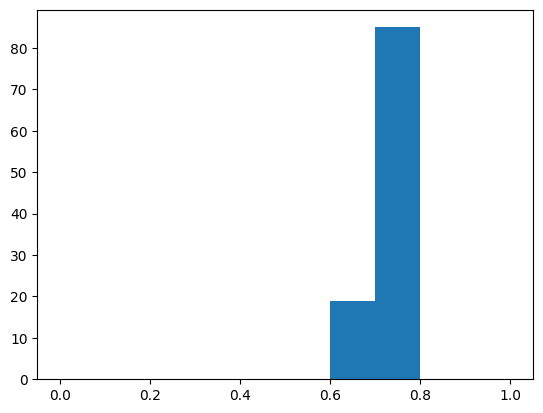

0.6958400106229702


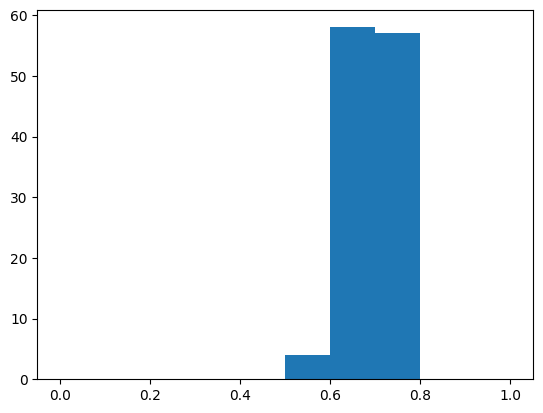

0.7828516816908075


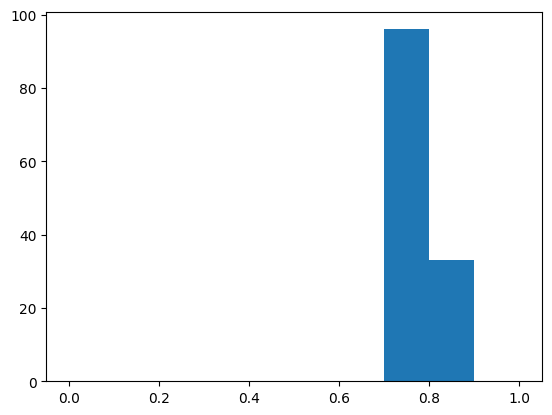

0.7263395071029664


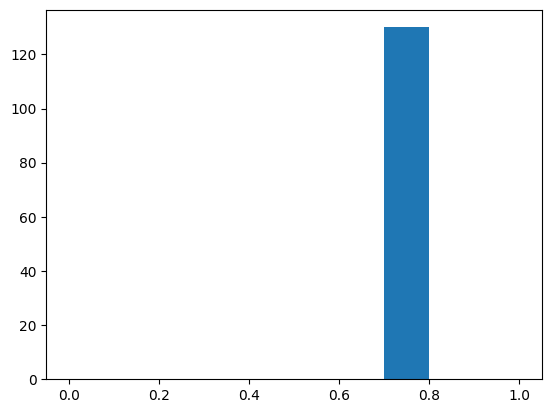

0.8752798360127669


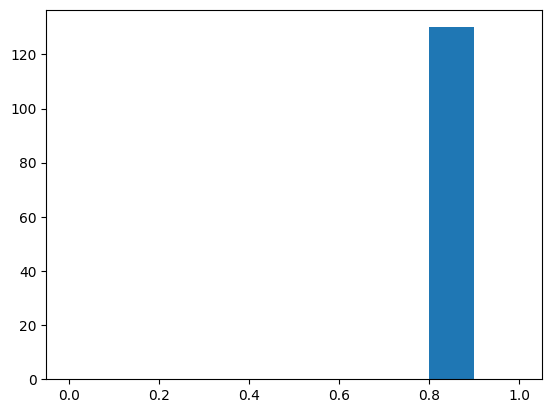

0.8331787710966065


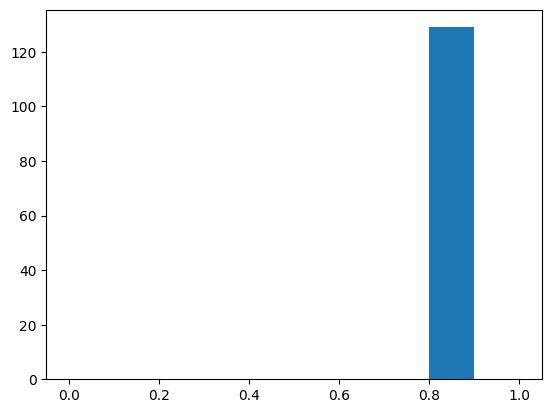

0.749477485440812


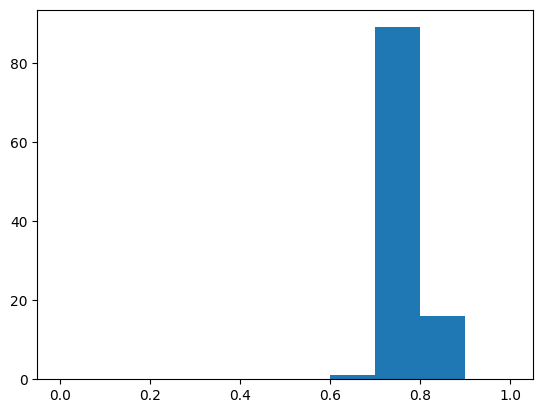

0.7743330762936519


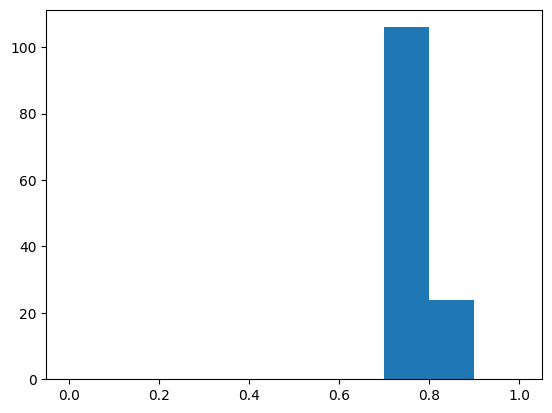

0.72411997960164


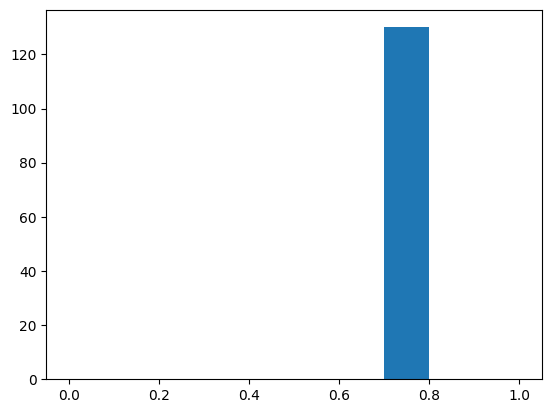

0.7620174201946814


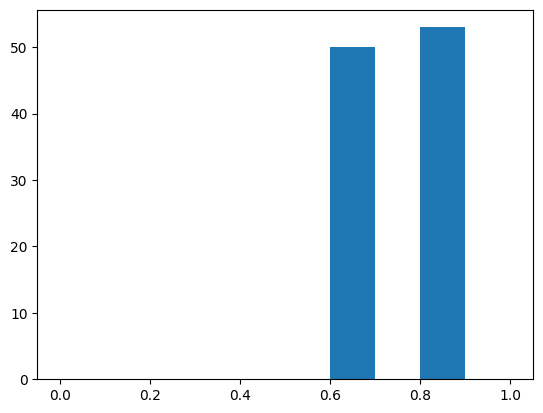

0.5845274698826693


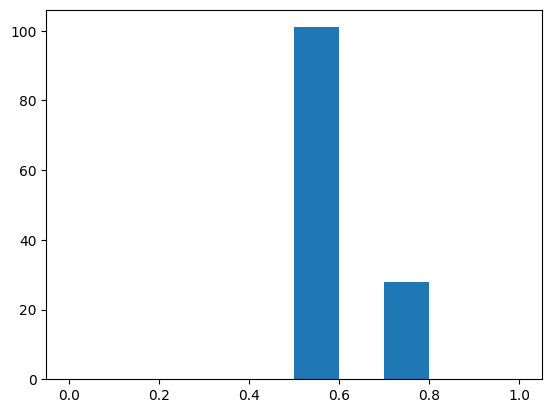

0.8146809038862718


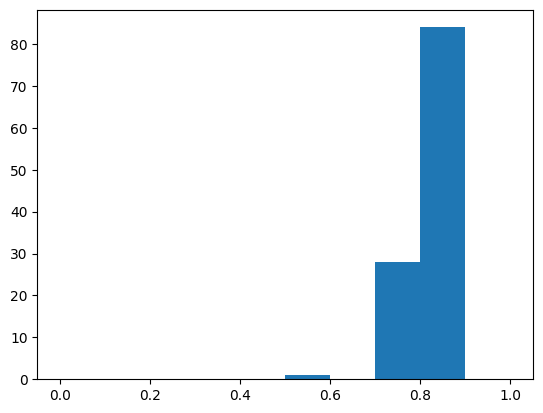

0.8731210002532372


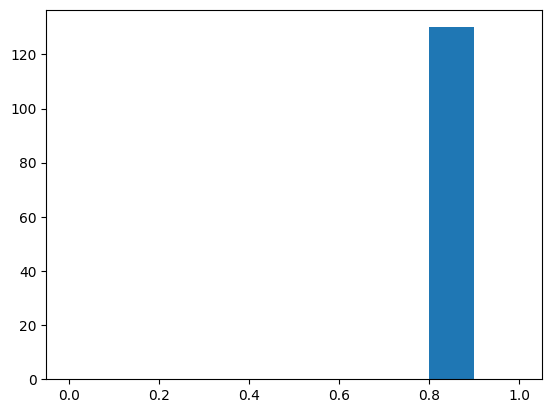

0.8368024881495986


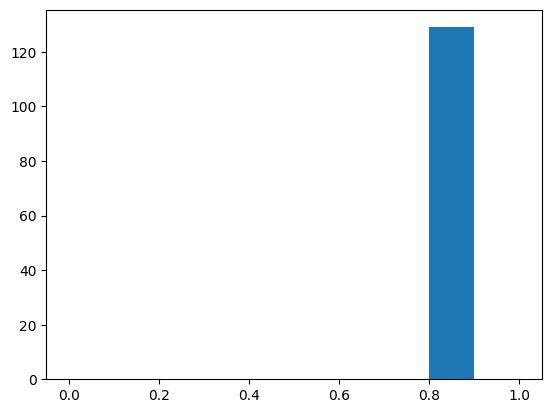

0.673656301442967


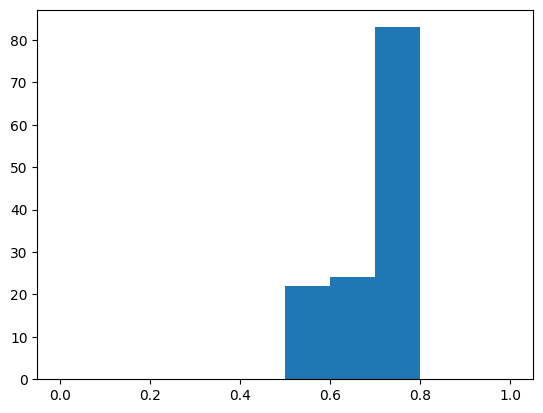

0.7264320350610293


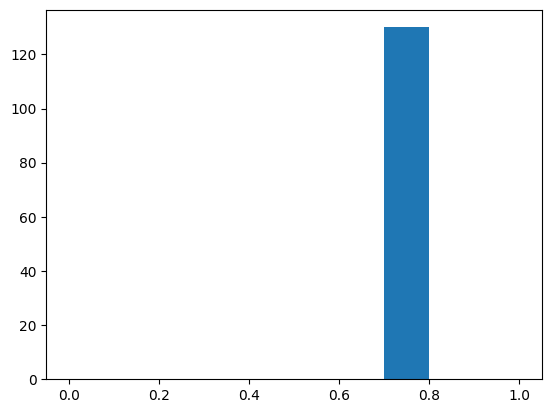

0.7090770056614509


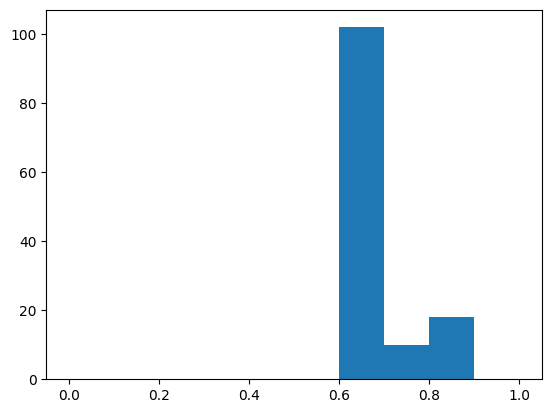

0.6813201409275249


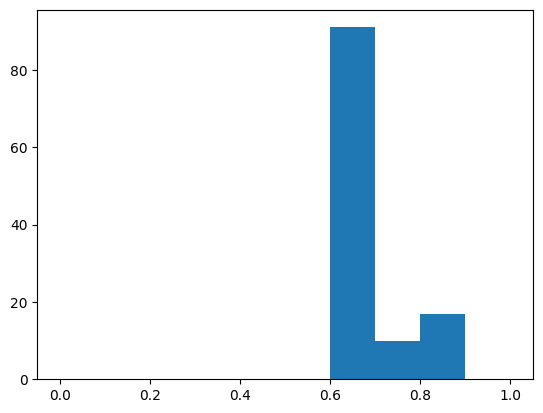

0.6089612929395927


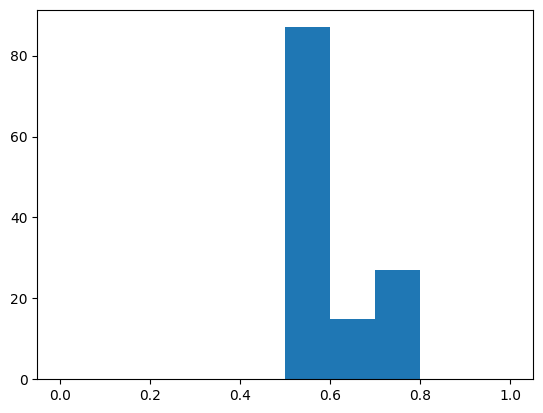

0.7625034932018251


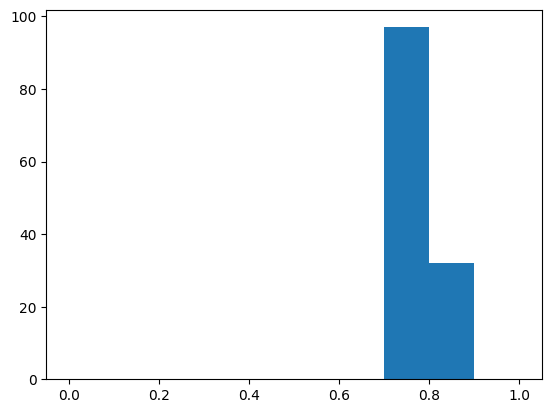

0.7868183525709006


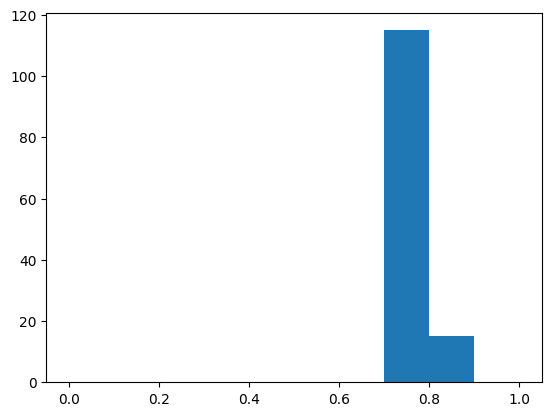

0.7507899634597838


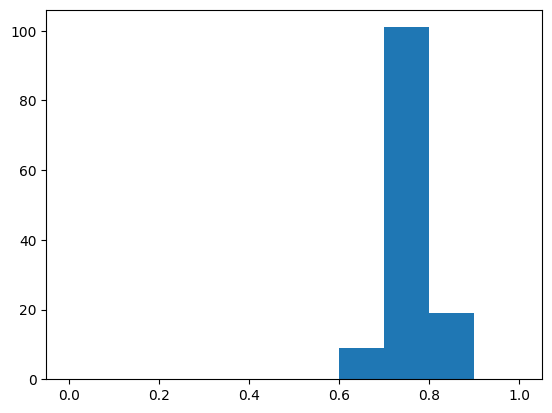

0.7599397999371669


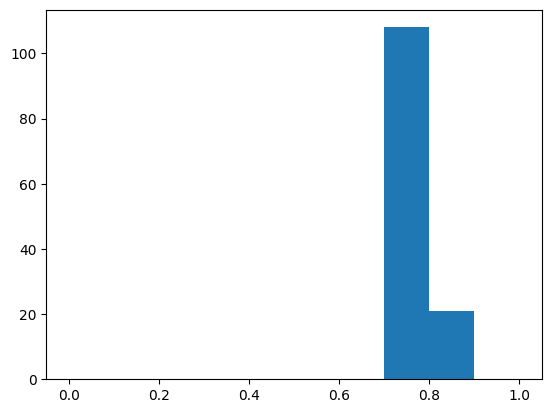

0.7327352687716484


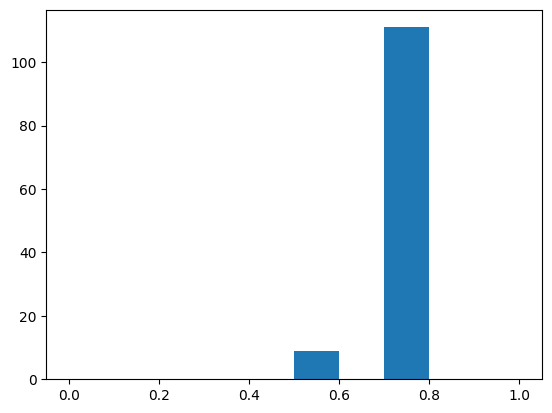

0.6714763613634331


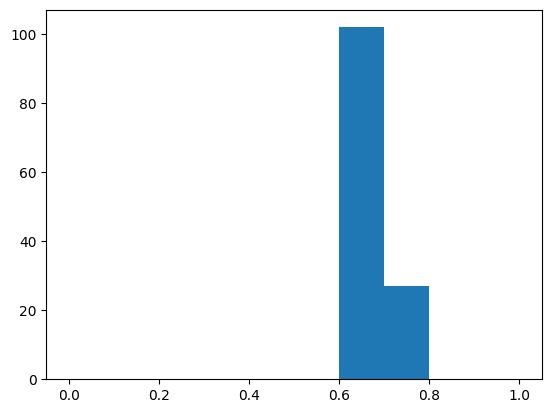

0.7509776432384816


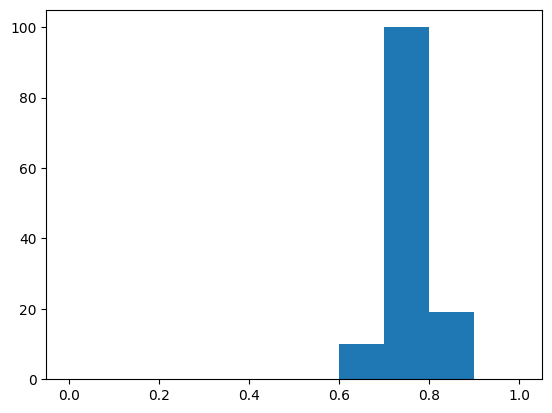

0.8111033333364384


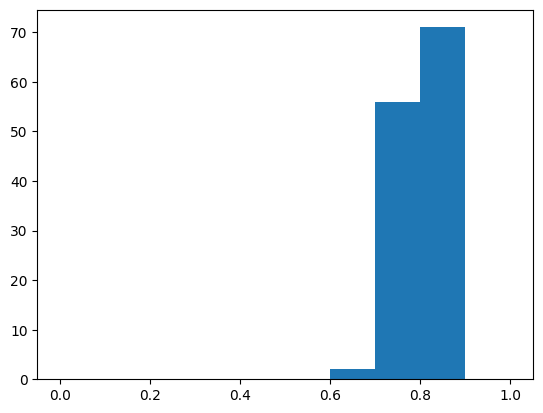

0.7846667790605176


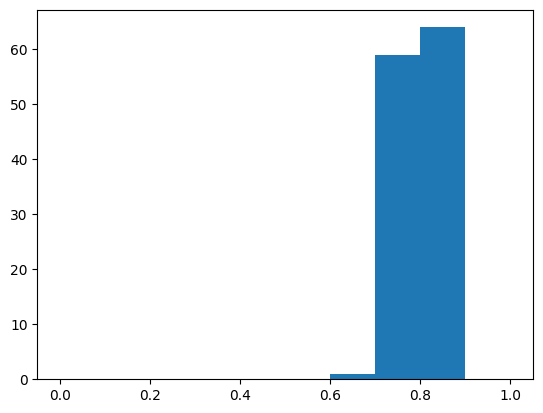

0.7635978721655332


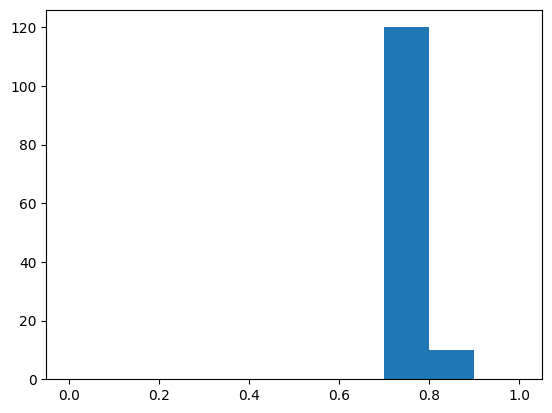

0.6934468258510936


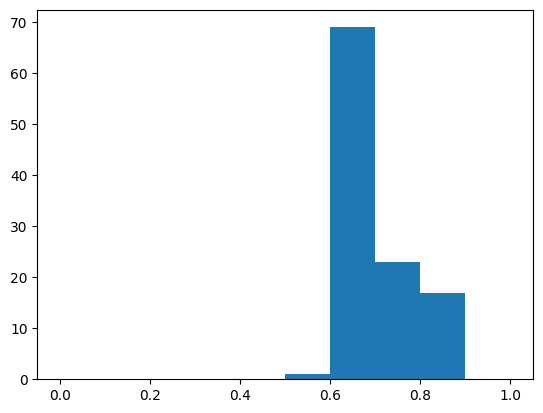

0.697106637695963


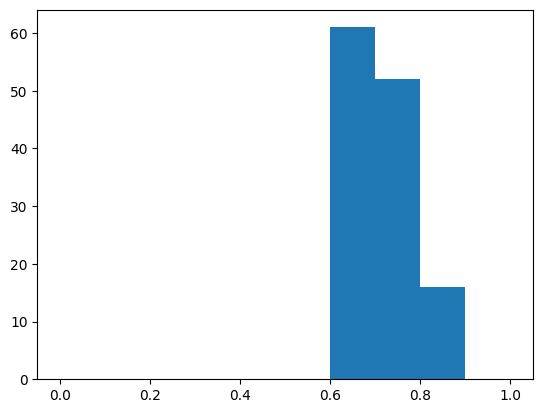

0.7416612307230631


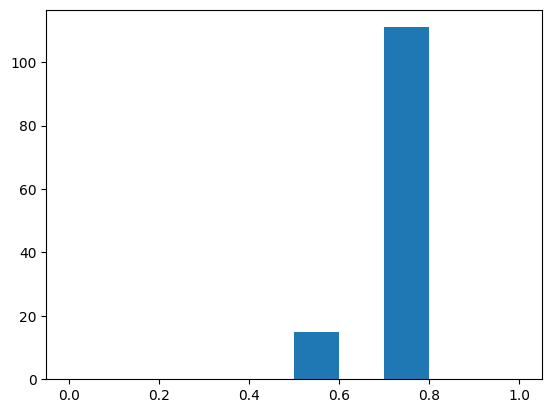

0.6775919152784717


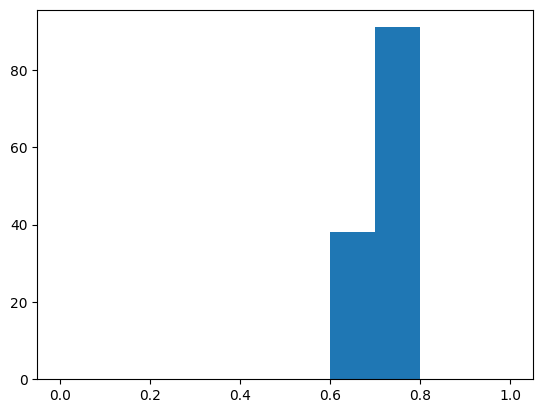

0.8792632864427197


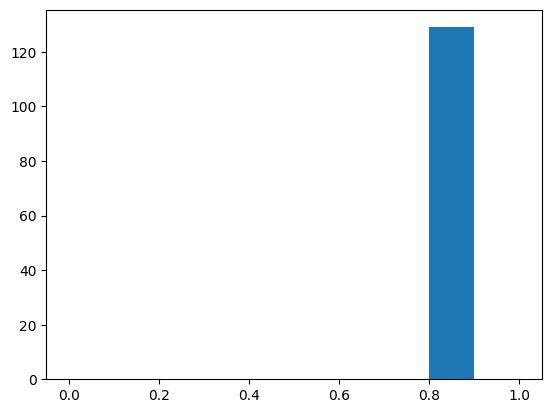

0.8765683922656747


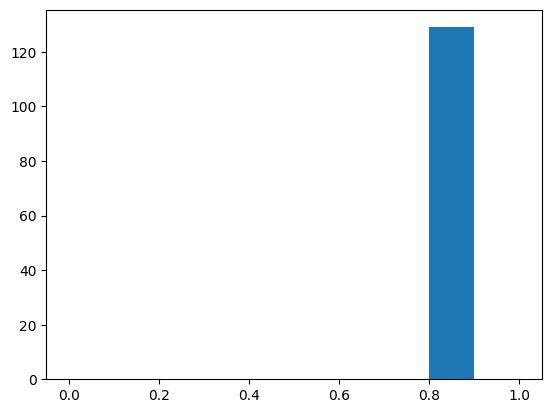

0.7218854261132387


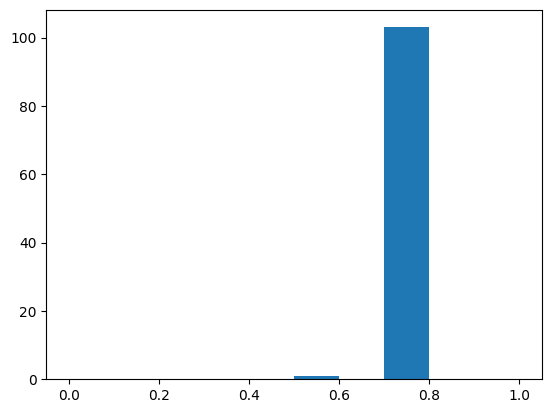

0.743469043894931


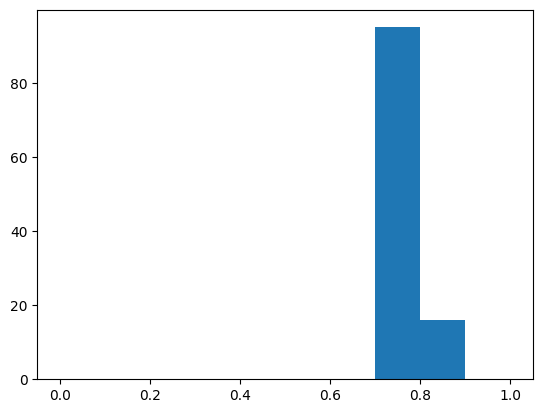

0.6801348933877871


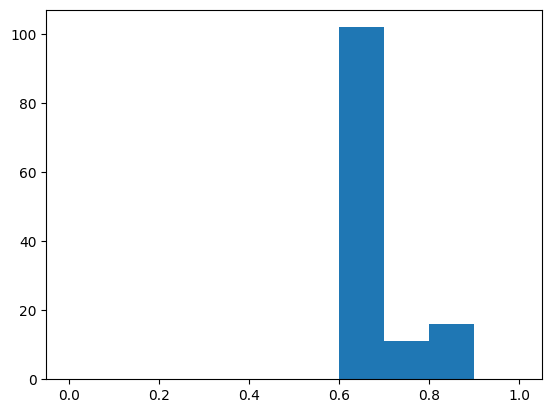

0.7216597990911515


KeyboardInterrupt: 

In [369]:
def plot_distribution_per_inchikey_with_little_distribution(selected_pairs, maximum_distance_between_extremes):
    inchikey_scores = {}
    for inchikey_1, inchikey_2, score in tqdm(selected_pairs):
        if inchikey_1 in inchikey_scores:
            inchikey_scores[inchikey_1].append(score)
        else:
            inchikey_scores[inchikey_1] = []
        if inchikey_2 in inchikey_scores:
            inchikey_scores[inchikey_2].append(score)
        else:
            inchikey_scores[inchikey_2] = []
    shuffled_inchikeys = list(inchikey_scores.keys())
    random.shuffle(shuffled_inchikeys)
    for inchikey in shuffled_inchikeys:
        scores = inchikey_scores[inchikey]
        if abs(min(scores) - max(scores)) < maximum_distance_between_extremes:
            print(sum(scores)/len(scores))
            plt.hist(scores, bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9,1.001])
            plt.show()
plot_distribution_per_inchikey_with_little_distribution(pair_generator_average_sampling[100].selected_inchikey_pairs, maximum_distance_between_extremes=0.3)
